In [216]:
import json
import os
import re
from typing import Dict, Any, Union, Tuple
from typing import List

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame

In [217]:
def load_json_data(file_path: str) -> pd.DataFrame:
    """Load data from JSON file."""
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    with open(file_path, 'r') as f:
        data = json.load(f)

    # Assuming that all items in the JSON file have the same structure
    keys: List[str] = list(data[0].keys())
    filtered_data: List[Dict[str, Any]] = [{key: item[key] for key in keys} for
                                           item in data]

    df: pd.DataFrame = pd.DataFrame(filtered_data)

    return df


def convert_to_universal_time_format(df: pd.DataFrame,
                                     to_period: str = 'D') -> pd.DataFrame:
    # Identify columns that match a regular expression pattern for "time"
    time_columns: List[str] = [col for col in df.columns if
                               re.match(r'.*time.*|.*date*.', col,
                                        re.IGNORECASE)]

    # Convert identified columns to datetime format and extract year and month
    for col in time_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].dt.to_period(to_period)

    # Group by year and month, and calculate the median of each group
    for col in time_columns:
        df = df.groupby(col).median().reset_index()

    return df


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process time columns in a dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe.

    Returns:
    pd.DataFrame: The processed dataframe.
    """
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*time.*|.*date*.', col, re.IGNORECASE)]

    if len(time_cols) == 1:
        df.rename(columns={time_cols[0]: 'time'}, inplace=True)

    # Handle multiple time indices
    if len(time_cols) > 1:
        for i, col in enumerate(time_cols[1:], start=1):
            df.rename(columns={col: f'time{i}'}, inplace=True)

    return df


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    """
    Merge two dataframes by time.

    Parameters:
    df1 (pd.DataFrame): The first dataframe.
    df2 (pd.DataFrame): The second dataframe.

    Returns:
    pd.DataFrame: The merged dataframe.
    """
    # Process time columns in both dataframes
    df1 = rename_time_columns_to_universal_format(df1)
    df2 = rename_time_columns_to_universal_format(df2)

    # Merge dataframes
    merged_df: pd.DataFrame = pd.merge(df1, df2, how='inner')

    return merged_df


def filter_by_years(df: pd.DataFrame,
                    years_to_analyze: List[int]) -> pd.DataFrame:
    """
    Filters a DataFrame based on a list of years.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to filter.
        years_to_analyze (List[int]): The list of years to keep.
        
    Returns:
        filtered_df (pd.DataFrame): The filtered DataFrame.
    """
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*time.*|.*date*.', col, re.IGNORECASE)]

    filtered_df: DataFrame = DataFrame()

    for col in time_cols:
        filtered_df = df[df[col].dt.year.isin(years_to_analyze)]

    return filtered_df


def calculate_correlation(df: pd.DataFrame, col1: str, col2: str) -> Tuple[
    Union[float, DataFrame], float, float]:
    """
    Calculate the correlation between two columns in a dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe.
    col1 (str): The name of the first column.
    col2 (str): The name of the second column.

    Returns:
    tuple: A tuple containing the Pearson, Kendall, and Spearman correlation coefficients.
    """
    correlation: Union[float, DataFrame] = df[col1].corr(df[col2])
    tau = df[col1].corr(df[col2], method='kendall')
    kelman = df[col1].corr(df[col2], method='spearman')
    return correlation, tau, kelman


def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str) -> None:
    """
    Function to plot a scatter plot from a dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    x_col (str): Name of the column to be plotted on the x-axis.
    y_col (str): Name of the column to be plotted on the y-axis.

    Returns:
    None
    """
    # Check if columns exist in dataframe
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError("One or both columns do not exist in the dataframe")

    # Check if columns contain numerical data
    if not pd.api.types.is_numeric_dtype(
            df[x_col]) or not pd.api.types.is_numeric_dtype(df[y_col]):
        raise TypeError("One or both columns are not numeric")

    plt.figure(figsize=(10, 8))
    plt.scatter(df[x_col], df[y_col])
    plt.title(f'Scatter plot of {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()


def plot_scatter_multiple(df: pd.DataFrame, x_col: str,
                          y_cols: List[str]) -> None:
    """
    Function to plot multiple scatter plots from a dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    x_col (str): Name of the column to be plotted on the x-axis.
    y_cols (List[str]): List of column names to be plotted on the y-axis.

    Returns:
    None
    """
    # Check if x column exists in dataframe
    if x_col not in df.columns:
        raise ValueError("X column does not exist in the dataframe")

    # Check if x column contains numerical data
    if not pd.api.types.is_numeric_dtype(df[x_col]):
        raise TypeError("X column is not numeric")

    # Check if all y columns exist in dataframe and contain numerical data
    for y_col in y_cols:
        if y_col not in df.columns:
            raise ValueError(
                f"Y column {y_col} does not exist in the dataframe")
        if not pd.api.types.is_numeric_dtype(df[y_col]):
            raise TypeError(f"Y column {y_col} is not numeric")

    plt.figure(figsize=(10, 8))
    for y_col in y_cols:
        plt.scatter(df[x_col], df[y_col], label=y_col)
    plt.title(f'Scatter plot of {x_col} vs multiple y-columns')
    plt.xlabel(x_col)
    plt.ylabel('Values')
    plt.legend()
    plt.show()


def calculate_correlations_and_plot(df: pd.DataFrame, col_list1: List[str],
                                    col_list2: List[str]) -> None:
    """
    Calculate correlations between each pair of columns from two lists in a DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    col_list1 (List[str]): List of column names to correlate with col_list2.
    col_list2 (List[str]): List of column names to correlate with col_list1.
    """
    for col1 in col_list1:
        for col2 in col_list2:
            if col1 != col2:
                print(
                    f"Correlation {col1} vs {col2}: {calculate_correlation(df, col1, col2)}")
            else:
                col_list2.remove(col1)
        plot_scatter_multiple(df, col1, col_list2)


def remove_non_numeric_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function removes columns from a DataFrame that are not of type float or int.
    The first column is ignored.

    Parameters:
    df (pd.DataFrame): Input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with non-numeric columns removed.
    """
    # Ignore the first column
    cols_to_drop = []
    for col in df.columns[1:]:
        if df[col].dtype not in ['float64', 'int64']:
            cols_to_drop.append(col)

    return df.drop(cols_to_drop, axis=1)


# TODO: Make it not so general (SRP)
def process(solar_data_file: os.path,
            satellite_data_file: os.path):
    # Define the list of years to analyze
    years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019, 2014]

    df_solar: DataFrame = load_json_data(solar_data_file)
    df_solar = convert_to_universal_time_format(df_solar)

    solar_column_names: List[str] = [col for col in df_solar.columns if
                                     not re.match(r'.*time.*|.*date*.', col,
                                                  re.IGNORECASE)]

    df_satellite: DataFrame = pd.read_csv(satellite_data_file)
    df_satellite = remove_non_numeric_data(df_satellite)
    df_satellite = convert_to_universal_time_format(df_satellite)

    filter_by_years(df_satellite, years_to_analyze)

    satellite_column_names: List[str] = [col for col in df_satellite.columns if
                                         not re.match(r'.*time.*|.*date*.', col,
                                                      re.IGNORECASE)]

    df_solar_satellite_merged: pd.DataFrame = merge_dataframes_by_time(
        df_solar,
        df_satellite)

    calculate_correlations_and_plot(df_solar_satellite_merged,
                                    satellite_column_names,
                                    solar_column_names
                                    )

In [218]:
import glob


def analyze_satellite(sat_name: str):
    observed_solar_cycle_data_path = '../data/swpc_observed_ssn.json'
    sat_csv_data_files: List[str] = glob.glob(
        os.path.join(f"../data/{sat_name}", "*.csv"))

    for sat_file in sat_csv_data_files:
        print(f"Analyzing {sat_file}")
        process(solar_data_file=observed_solar_cycle_data_path,
                satellite_data_file=os.path.abspath(sat_file))

Analyzing ../data/griffex/battery.csv
Correlation Battery vs swpc_ssn: (-0.05633533230487771, 0.0051619469492026875, 0.009183743692619008)


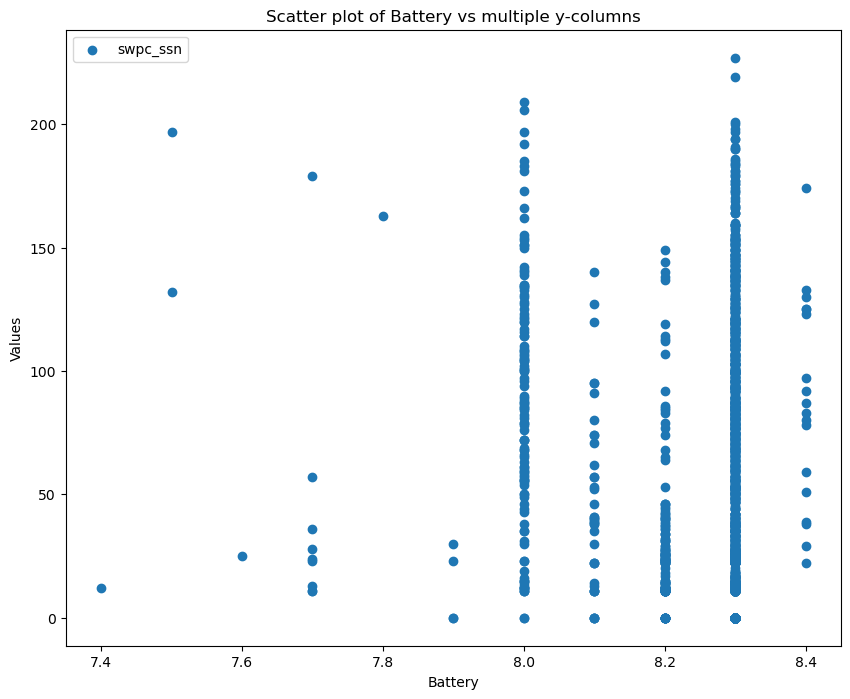

Analyzing ../data/griffex/battery_3v.csv
Correlation 3.3V vs swpc_ssn: (-1.2577623705904586e-15, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


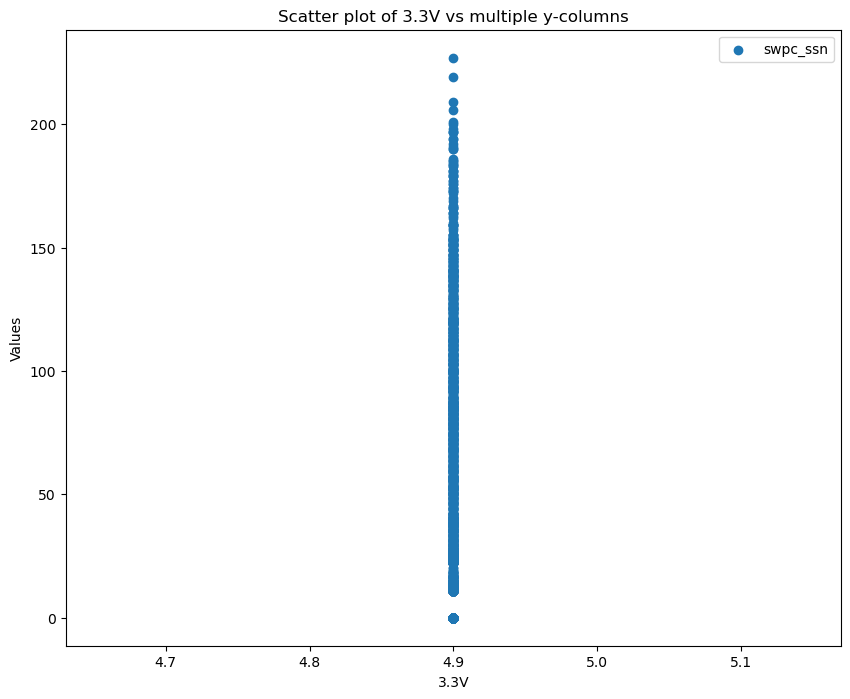

Analyzing ../data/griffex/battery_5v.csv
Correlation 5V vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


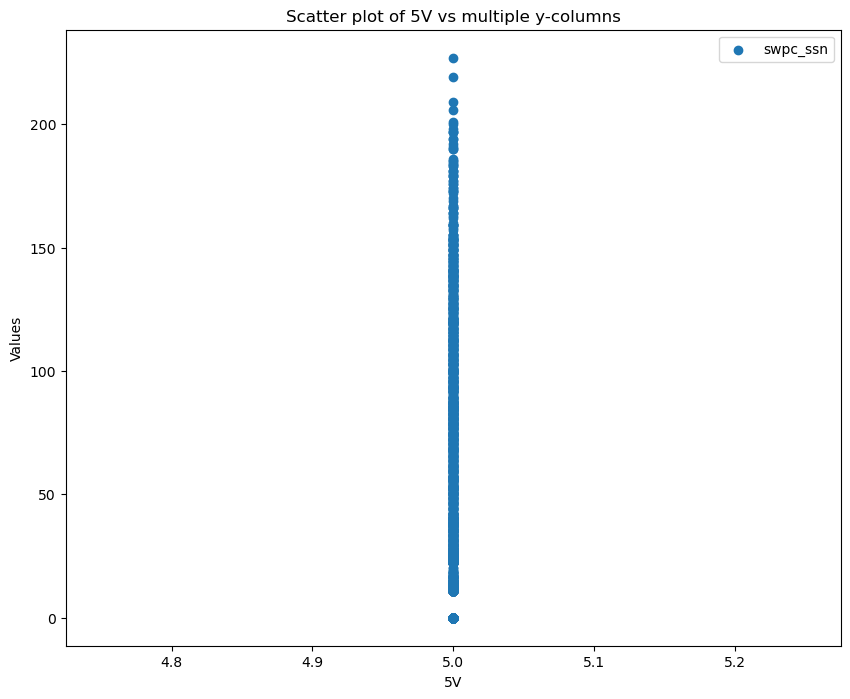

Analyzing ../data/griffex/bus_current.csv
Correlation Battery Bus vs swpc_ssn: (0.13672412903702072, 0.27477822293117526, 0.39612621911017304)


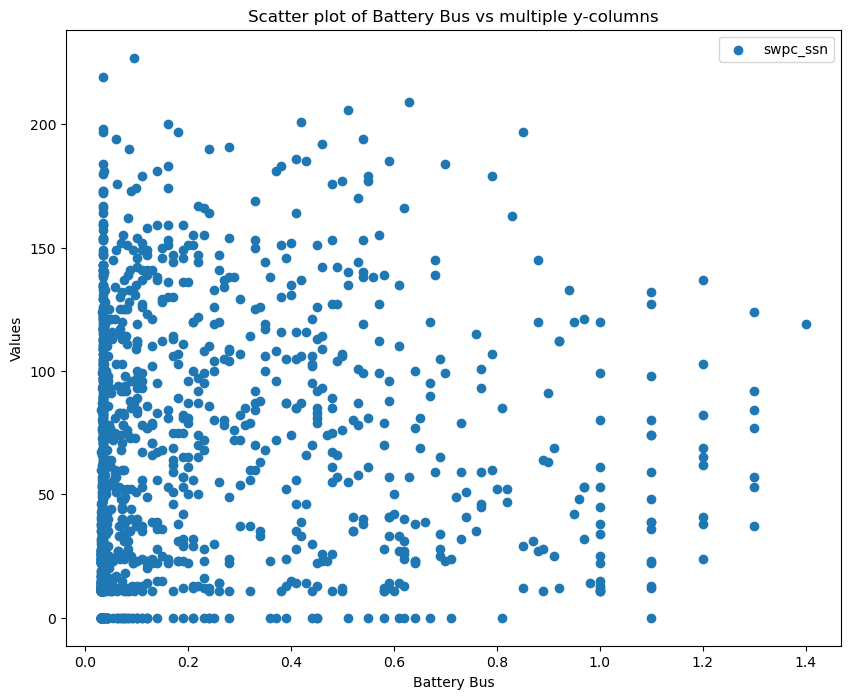

Analyzing ../data/griffex/bus_voltage.csv
Correlation Battery Bus vs swpc_ssn: (0.003239808274962762, 0.09204306050681259, 0.12023594381103614)


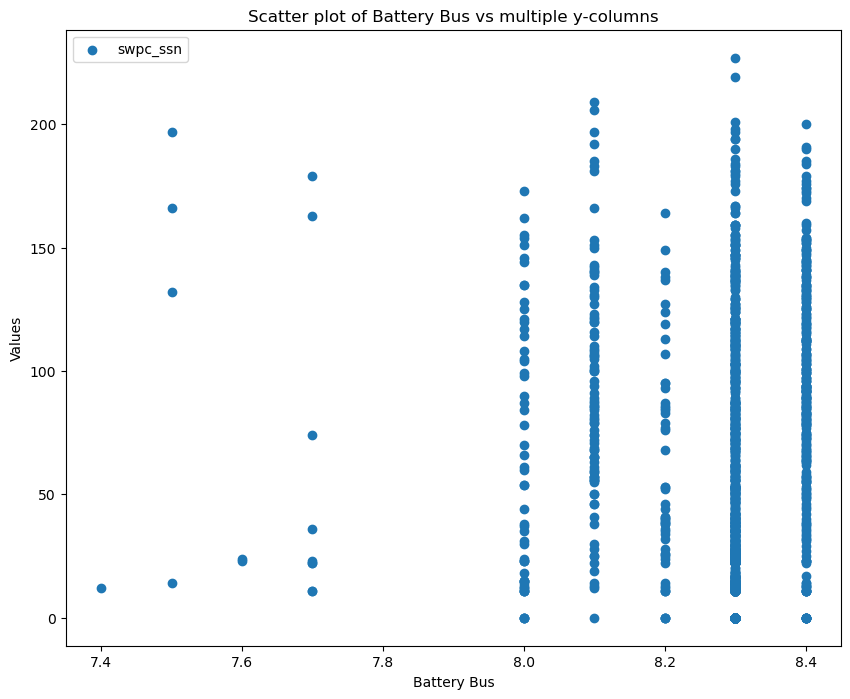

Analyzing ../data/griffex/data_mnt_usage.csv
Correlation 40379.median vs swpc_ssn: (0.46315355052211304, 0.32450245018819246, 0.4759659161682569)


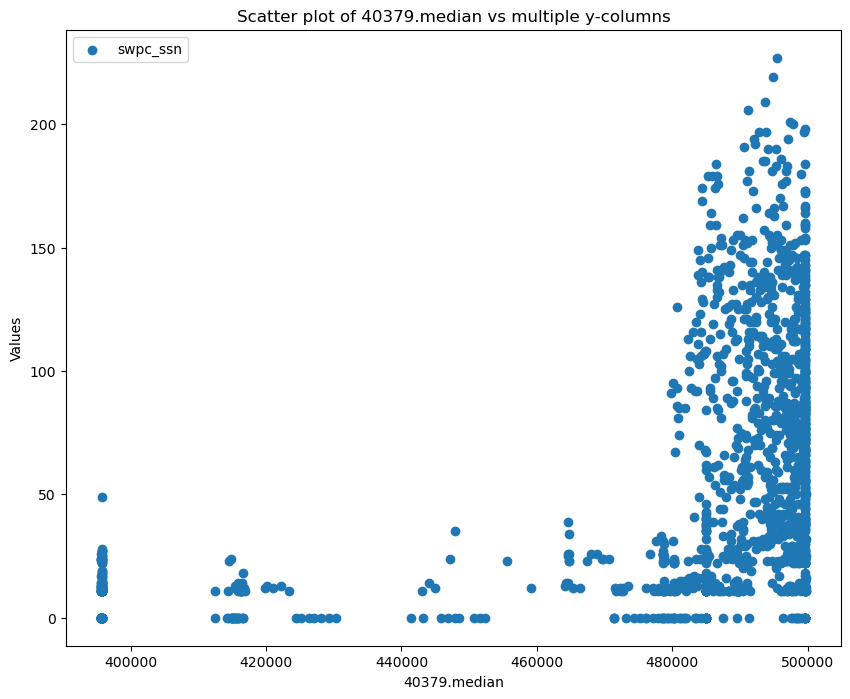

Analyzing ../data/griffex/memory_free_median.csv
Correlation 40379.freemem vs swpc_ssn: (-0.2553320454993292, -0.19699078323395622, -0.28660957028269796)


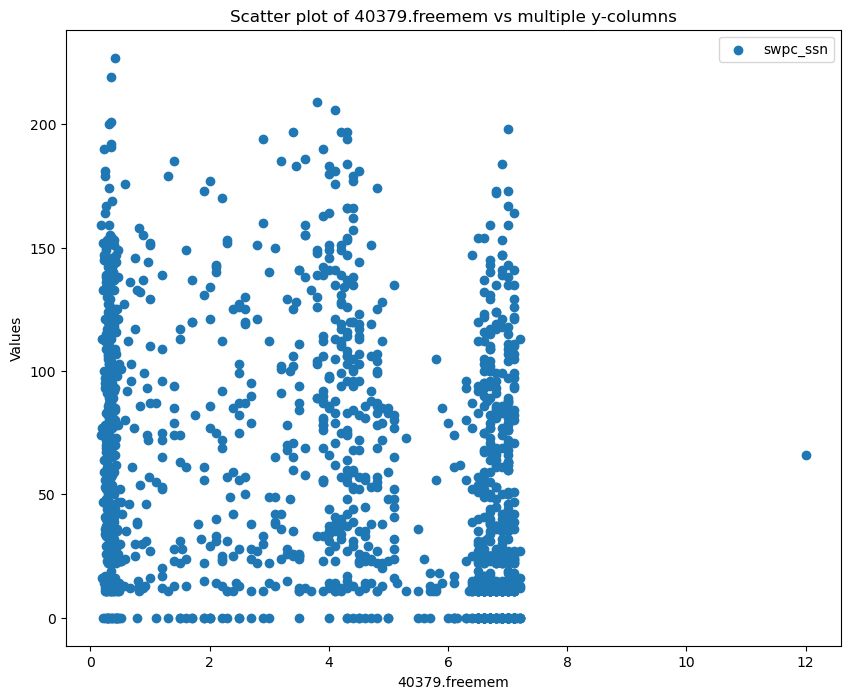

Analyzing ../data/griffex/memory_median.csv
Correlation 40379.median vs swpc_ssn: (0.023727671689518597, 0.022511671225207898, 0.027255477433036954)


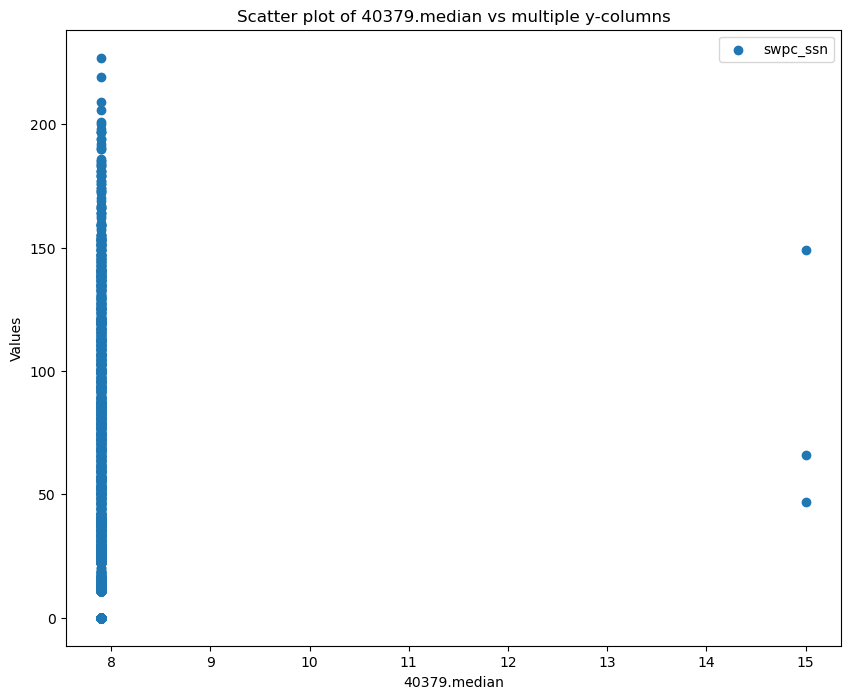

Analyzing ../data/griffex/resets.csv
Correlation resets vs swpc_ssn: (0.17805007116349097, 0.28077806323937066, 0.3894670351522071)


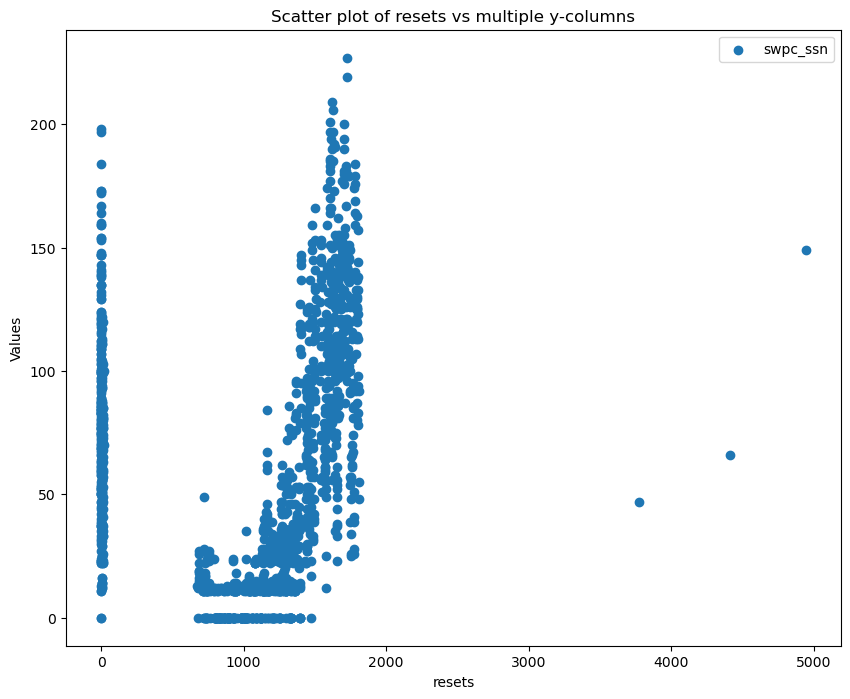

Analyzing ../data/griffex/rssi.csv
Correlation 40379.min vs swpc_ssn: (0.18531758277930818, 0.10434218347405477, 0.15340700721706893)


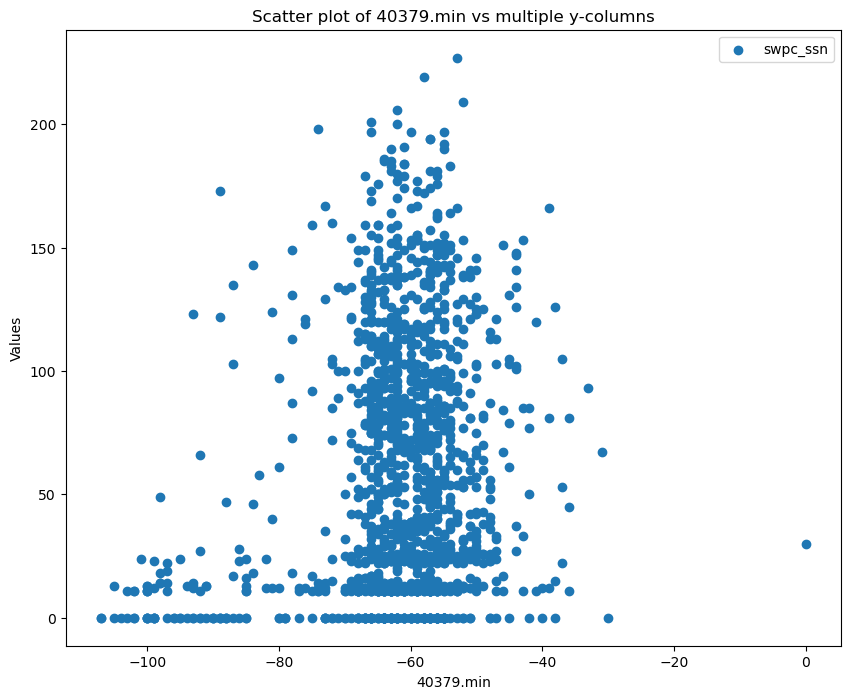

In [219]:
analyze_satellite('griffex')

Analyzing ../data/cas-5a/AGC Levels-data-2024-02-04 18 20 53.csv
Correlation VHF AGC vs swpc_ssn: (0.09824608531088937, 0.09006864929746124, 0.10999702789527843)


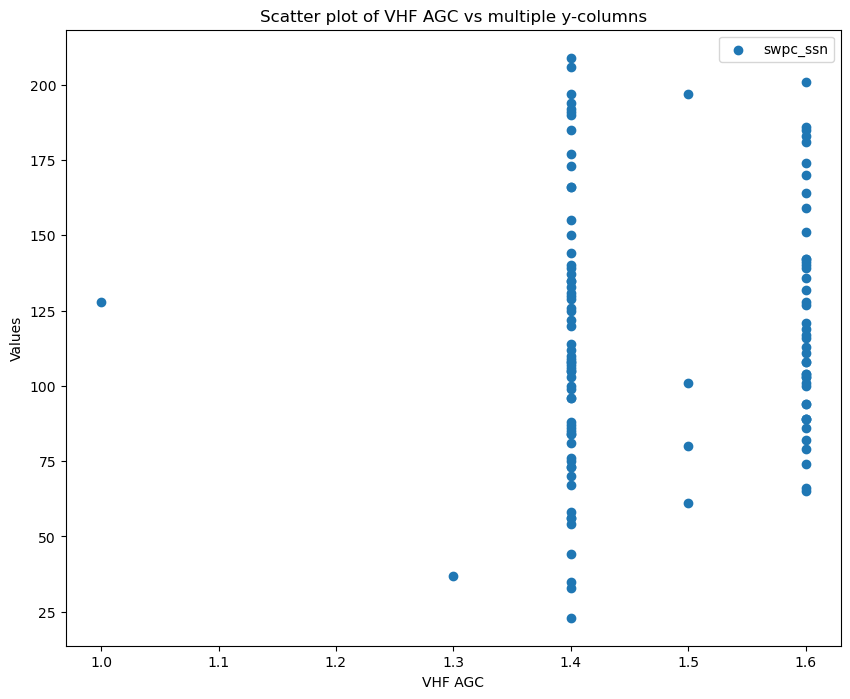

Analyzing ../data/cas-5a/Operating Mode-data-2024-02-04 18 21 28.csv
Analyzing ../data/cas-5a/Power Supply Voltage-data-2024-02-04 18 20 16.csv
Correlation 54684.mode_mode vs swpc_ssn: (0.12142101001190515, 0.23057339665182852, 0.35361993001509145)


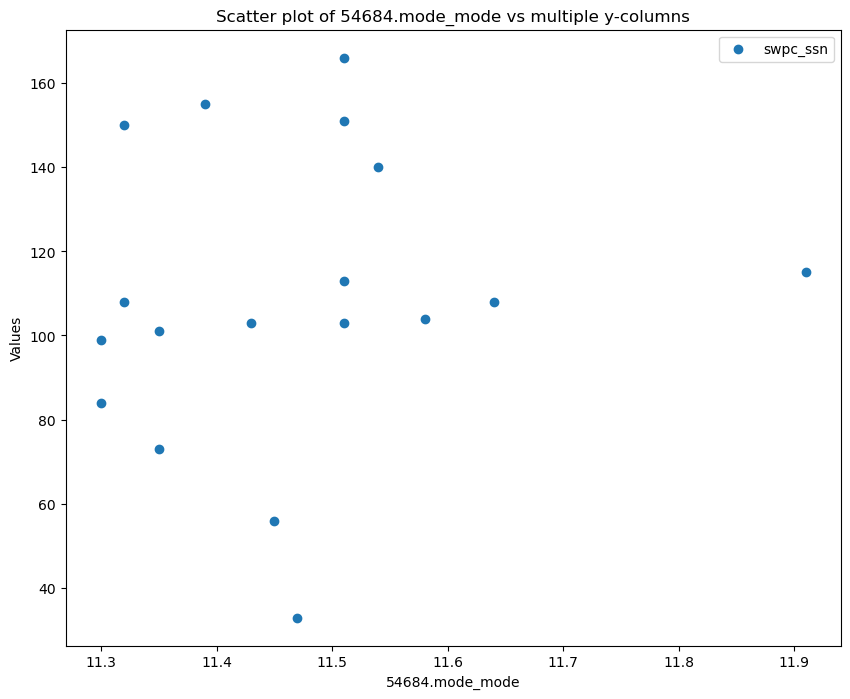

Analyzing ../data/cas-5a/RF Power-data-2024-02-04 18 20 49.csv
Correlation UHF1 Power vs swpc_ssn: (-0.15676750343342466, -0.13246747181362192, -0.1927394646248011)


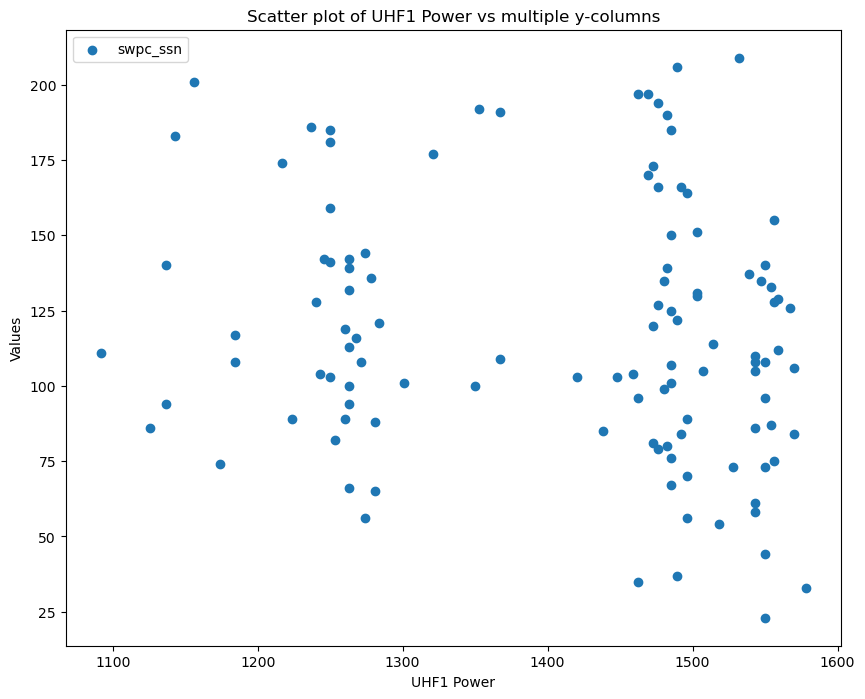

Analyzing ../data/cas-5a/System Currents-data-2024-02-04 18 20 40.csv
Correlation Primary Bus Current vs swpc_ssn: (-0.10212962782413144, -0.024528442570878228, -0.030105054109296783)


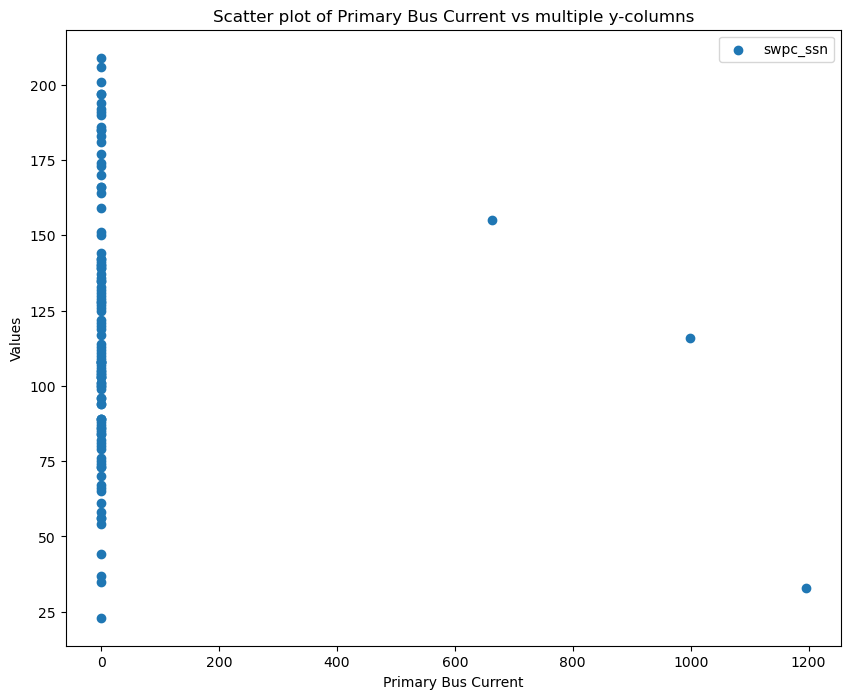

Analyzing ../data/cas-5a/System Temperatures (C)-data-2024-02-04 18 20 45.csv
Correlation IHU vs swpc_ssn: (0.014742294538607096, -0.009403302154266163, -0.008542958649201576)


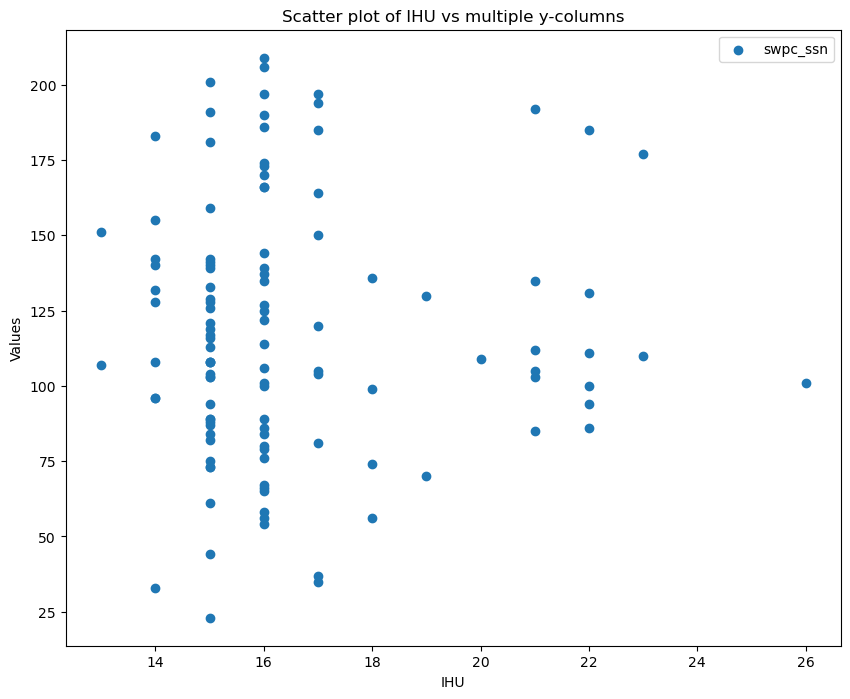

Analyzing ../data/cas-5a/System Temperatures-data-2024-02-04 18 20 32.csv
Correlation IHU vs swpc_ssn: (0.014742294538607096, -0.009403302154266163, -0.008542958649201576)


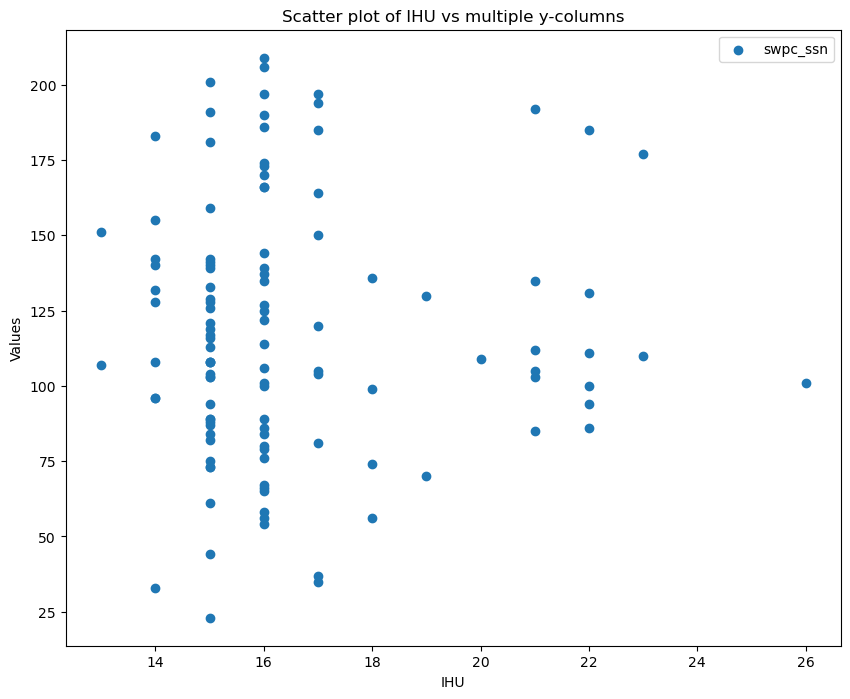

Analyzing ../data/cas-5a/Total Solar Array Current-data-2024-02-04 18 21 00.csv
Correlation Total Solar Array Current vs swpc_ssn: (0.1369086294587559, 0.03247210626412327, 0.040145991592160944)


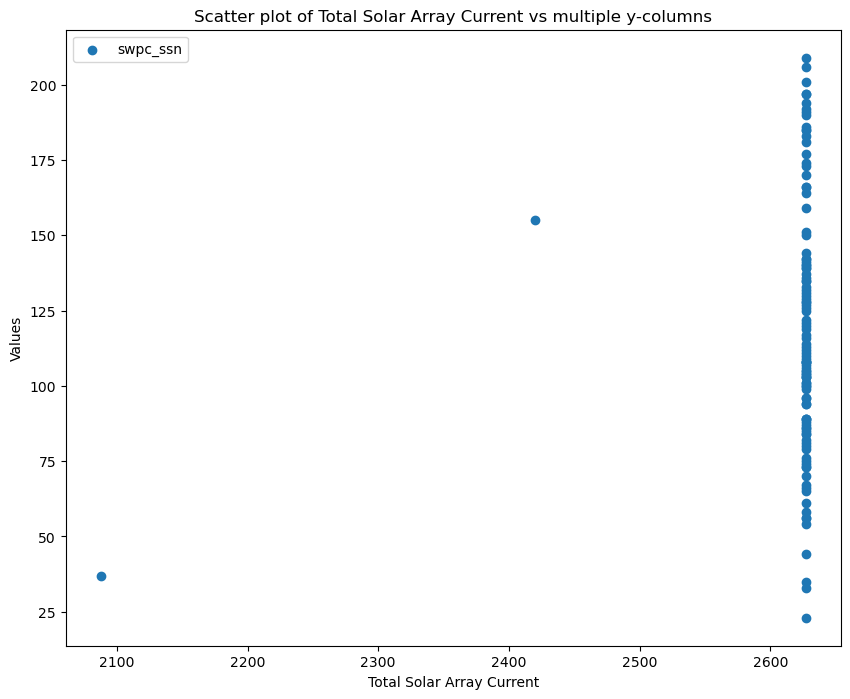

In [220]:
analyze_satellite('cas-5a')

Analyzing ../data/cubebel-1/EPS Reset-data-2024-02-04 18 15 37.csv
Correlation reseat vs swpc_ssn: (0.5918942117251357, 0.3784094723883098, 0.49899381760266887)


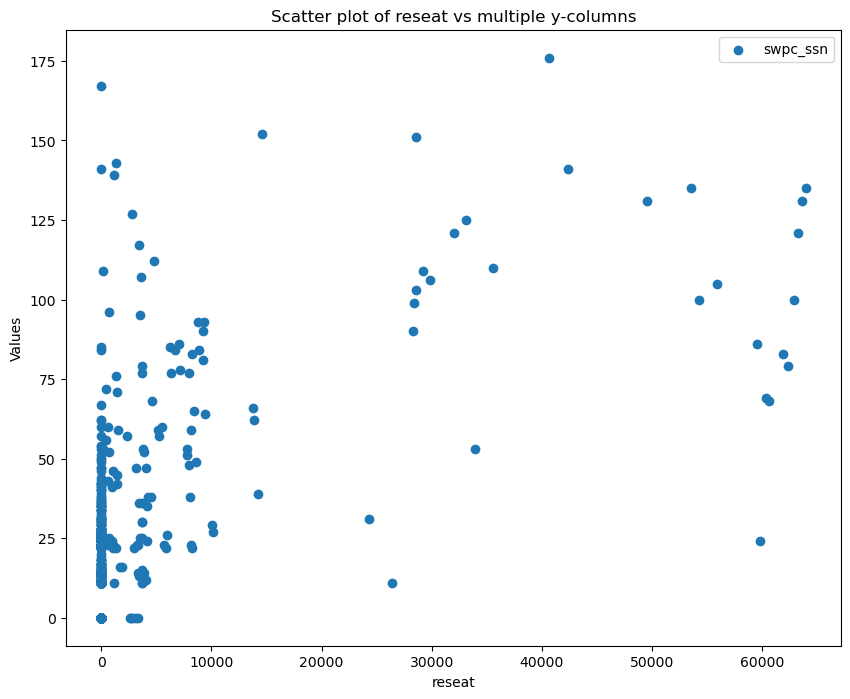

Analyzing ../data/cubebel-1/Frame count-data-2024-02-04 18 15 00.csv
Correlation Framecount vs swpc_ssn: (0.554271199314867, 0.6285633444485683, 0.8313510615110348)


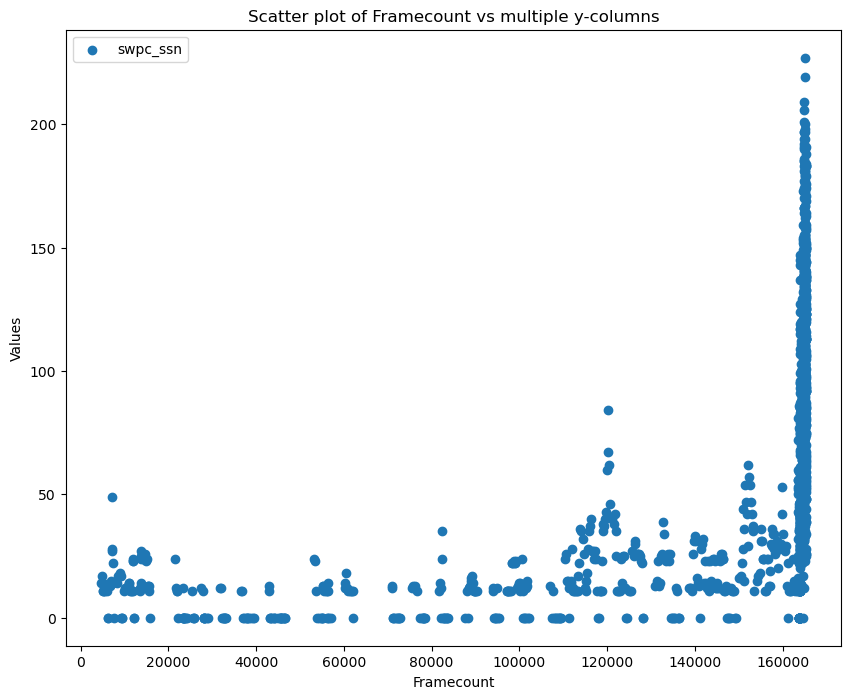

Analyzing ../data/cubebel-1/Ground Stations Leaderboard By Observed Frames-data-2024-02-04 18 15 35.csv
Correlation 1 East passes only vs swpc_ssn: (0.38985085447671536, 0.38057841525601127, 0.46136856878000515)


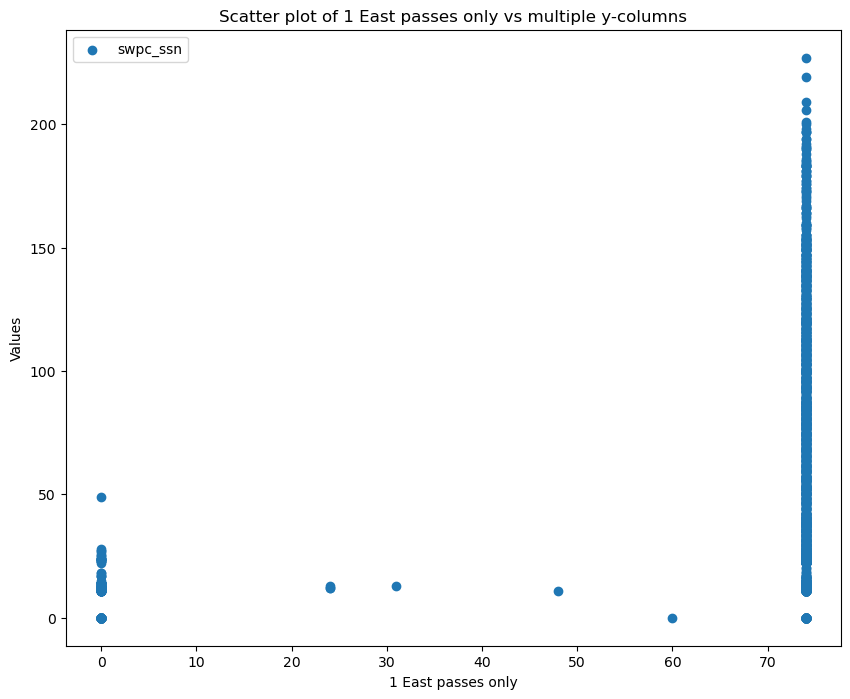

Analyzing ../data/cubebel-1/Last Frame-data-2024-02-04 18 15 07.csv
Correlation 43666.ctl vs swpc_ssn: (0.007788711705377543, 0.02212860361961925, 0.02660115220143276)


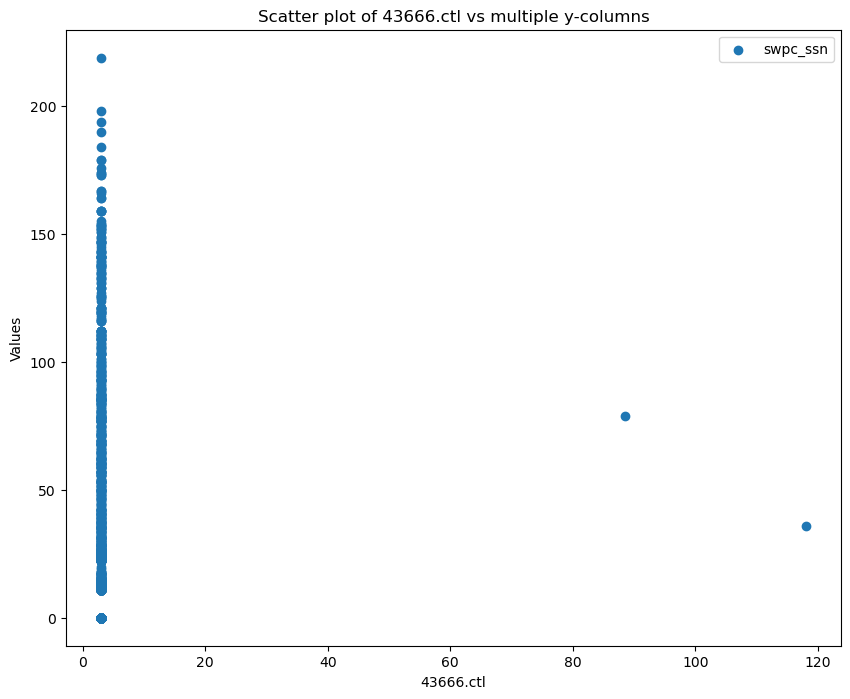

Analyzing ../data/cubebel-1/Solar Panel Currents-data-2024-02-04 18 15 15.csv
Correlation Panel X Current vs swpc_ssn: (0.12318551568737511, -0.011468451313746915, -0.021670033308069006)


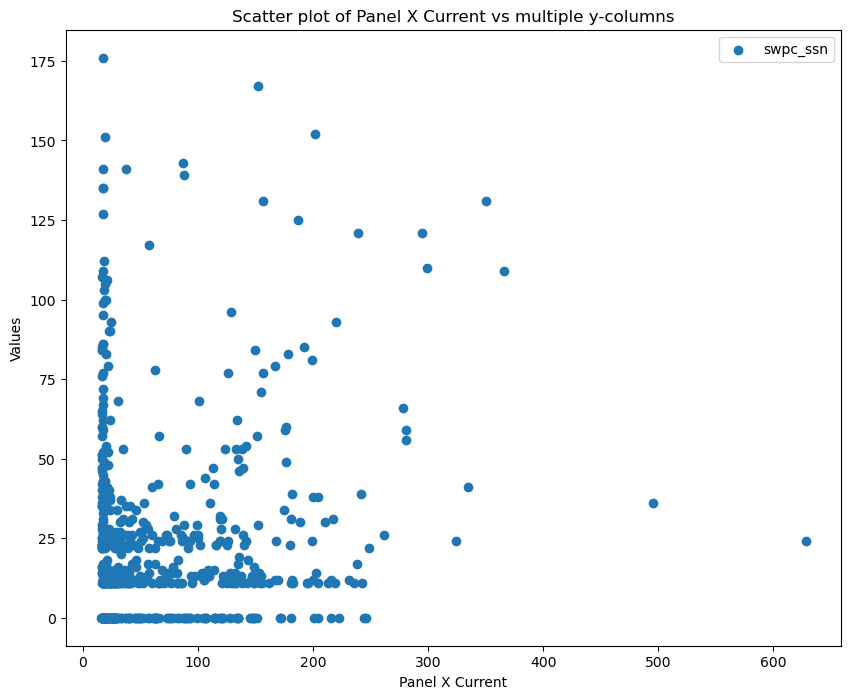

Analyzing ../data/cubebel-1/Solar Voltage-data-2024-02-04 18 15 20.csv
Correlation 43666.distinct vs swpc_ssn: (0.18077471127101538, 0.19735697842488076, 0.265121452157792)


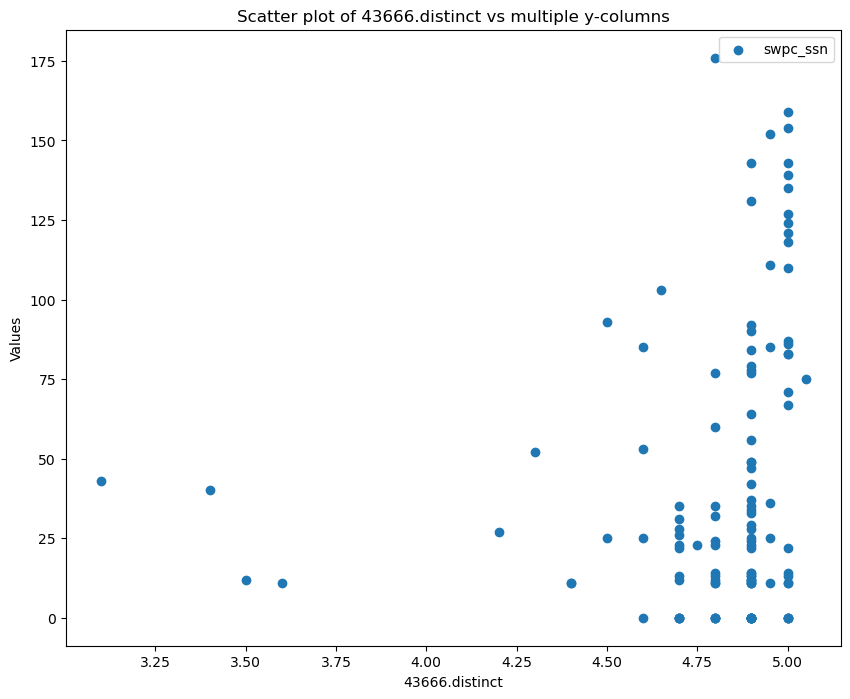

Analyzing ../data/cubebel-1/Stepup Voltage-data-2024-02-04 18 15 24.csv
Correlation 43666.distinct vs swpc_ssn: (0.13868002102024515, 0.19729415779351078, 0.2504780607638524)


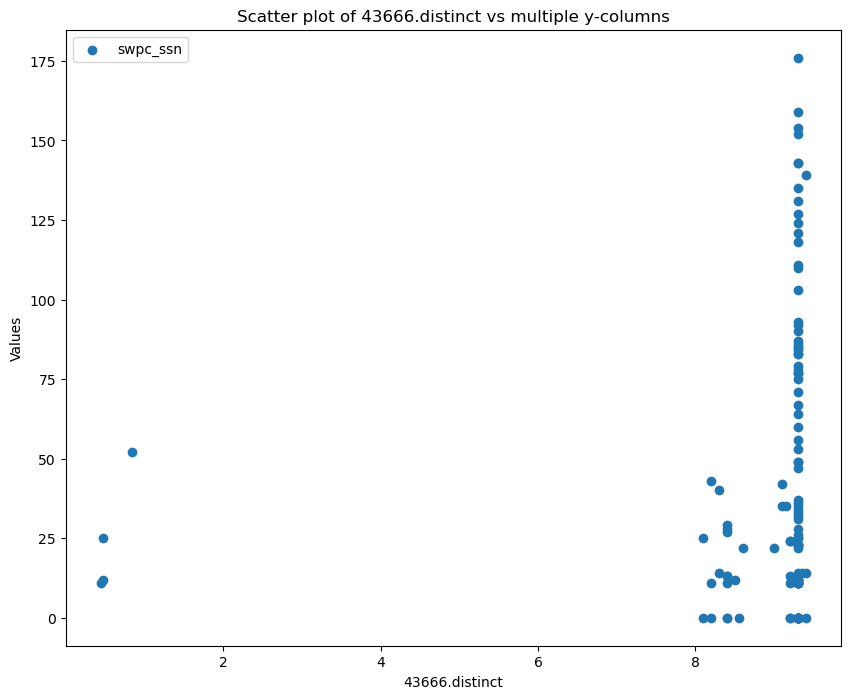

Analyzing ../data/cubebel-1/System 3.3V Voltage-data-2024-02-04 18 15 17.csv
Correlation 43666.distinct vs swpc_ssn: (-0.026503596099076522, -0.08259265975656294, -0.10026909635421952)


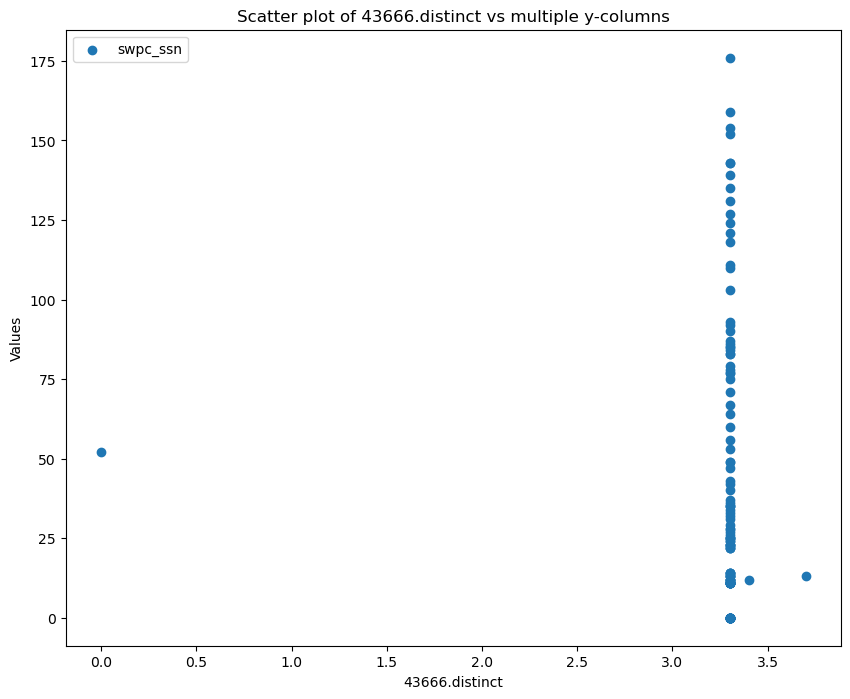

Analyzing ../data/cubebel-1/System 5V Voltage-data-2024-02-04 18 15 22.csv
Correlation 43666.distinct vs swpc_ssn: (-0.010007486535809882, 0.034547510107492956, 0.05107073212261531)


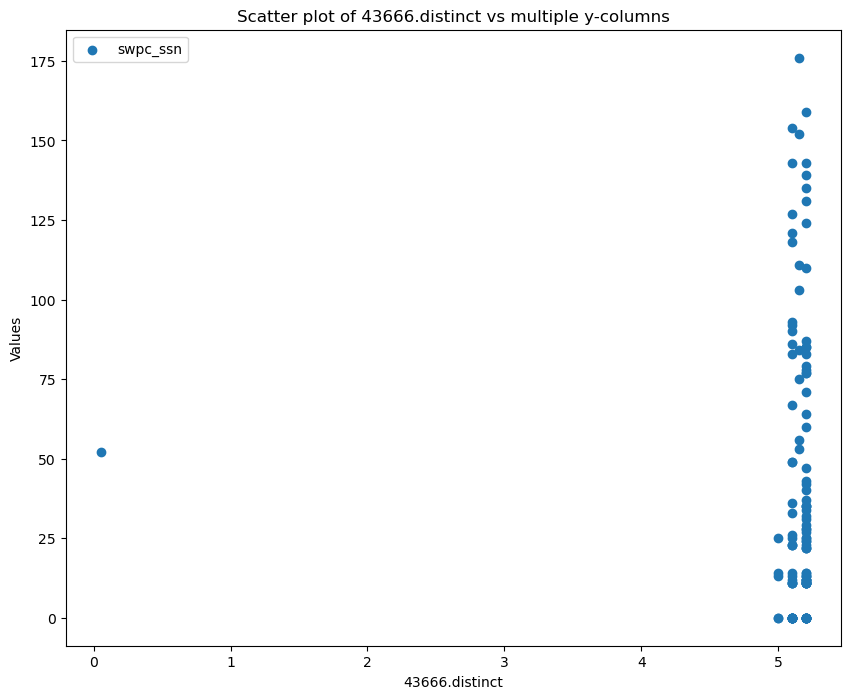

Analyzing ../data/cubebel-1/System Voltage-data-2024-02-04 18 15 04.csv
Correlation 43666.distinct vs swpc_ssn: (-0.07972983575444356, -0.02305782725228136, -0.02622339238129985)


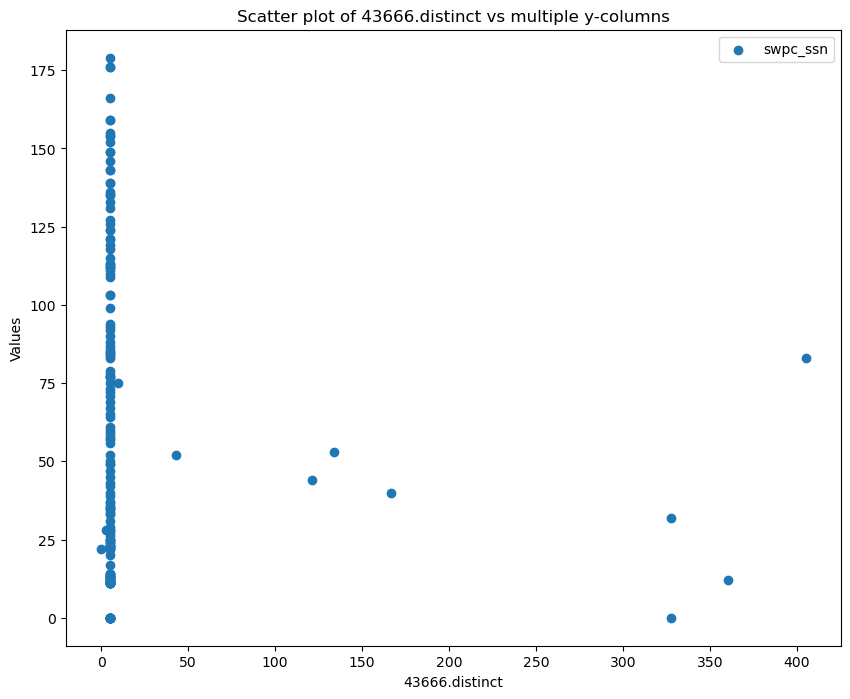

In [221]:
analyze_satellite('cubebel-1')

Analyzing ../data/cubebel-2/MB Uptime-data-2024-02-04 17 04 03.csv
Correlation 57175.tlm_mb vs swpc_ssn: (-0.03920938837919507, -0.016273330110514843, -0.0218143563391009)


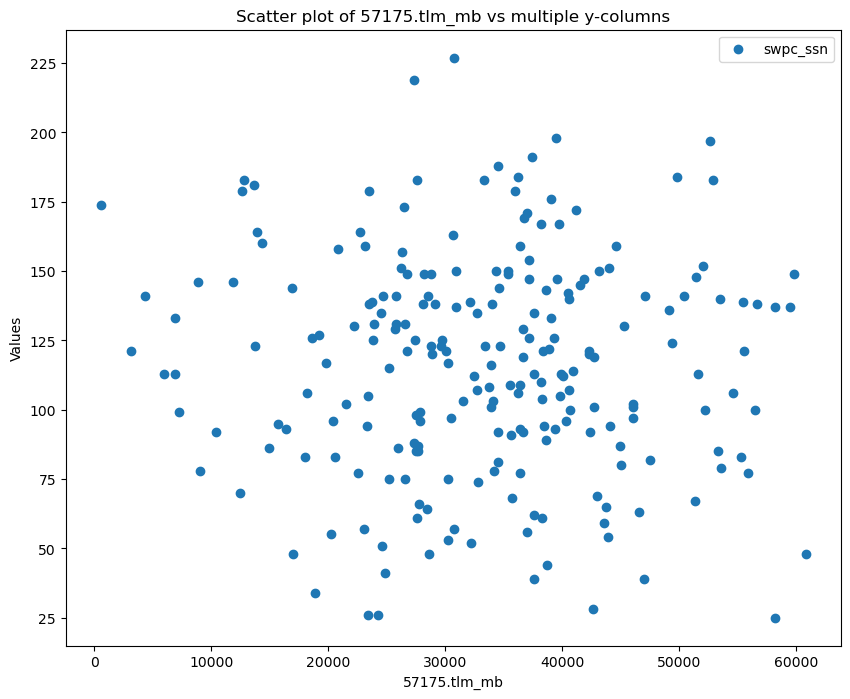

Analyzing ../data/cubebel-2/Resets-data-2024-02-04 17 03 55.csv
Correlation beacon_reset_total_cnt vs swpc_ssn: (0.06308189739717418, 0.031805614469253944, 0.047925029426530846)


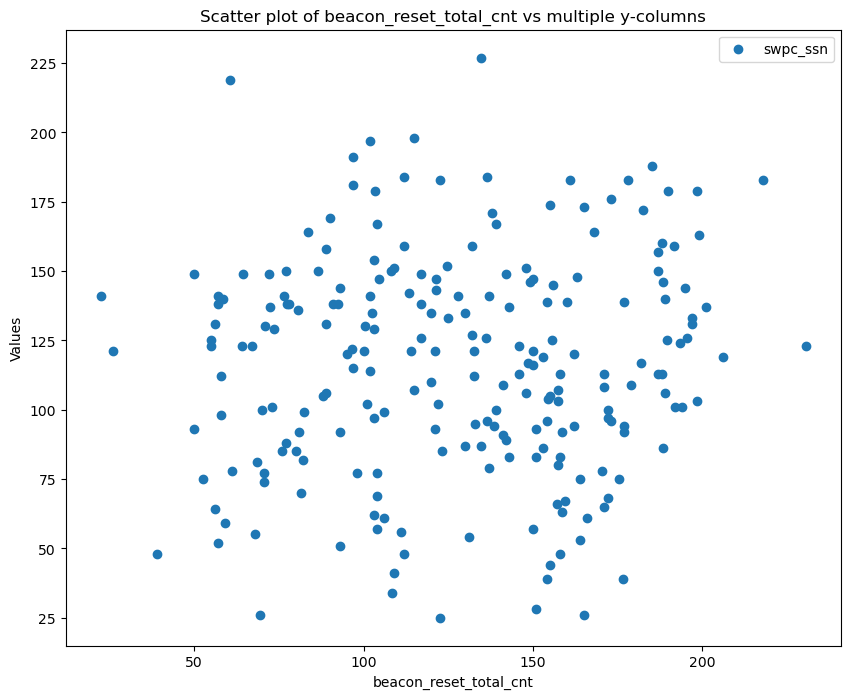

Analyzing ../data/cubebel-2/Solar Panel Current-data-2024-02-04 17 04 01.csv
Correlation tlm_mb_solarpanel_1_current() vs swpc_ssn: (0.20165144177141822, 0.05998507970674087, 0.07949192959089238)


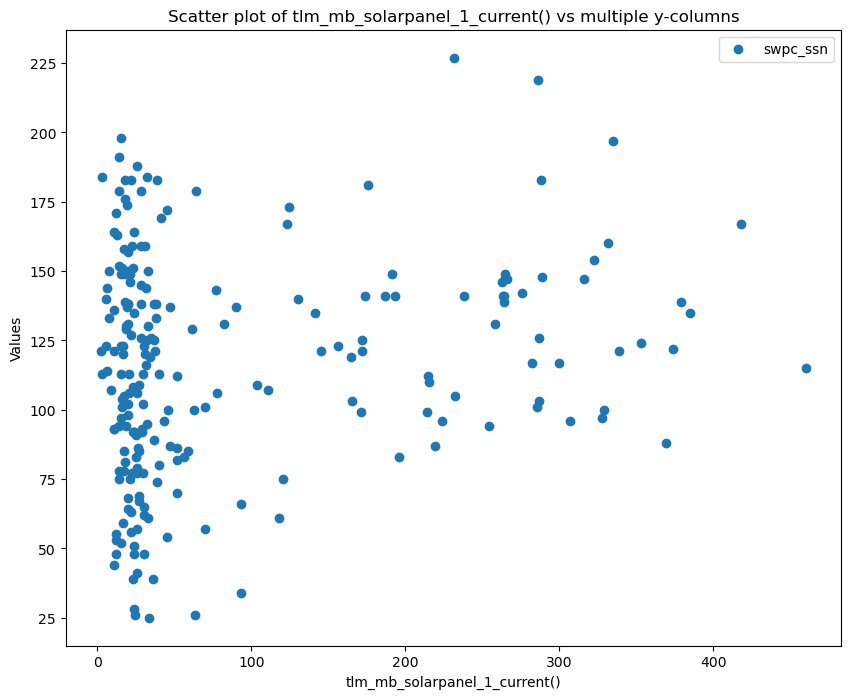

Analyzing ../data/cubebel-2/Solar Panel Temperatures-data-2024-02-04 17 03 40.csv
Correlation tlm_mb_solartemp_0_temp_0 vs swpc_ssn: (0.034366425753403936, -0.04279696273158506, -0.06787932799379075)


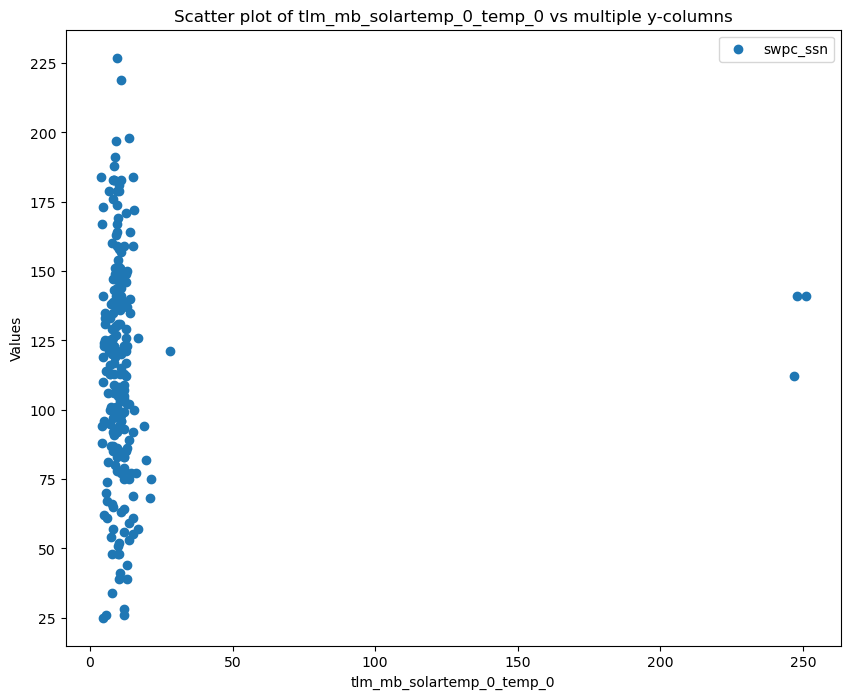

Analyzing ../data/cubebel-2/Solar Panel Voltages-data-2024-02-04 17 03 31.csv
Correlation tlm_mb_solarpanel_0_volt_pos vs swpc_ssn: (-0.022126762303537533, 0.09456866426411502, 0.12939294330430876)


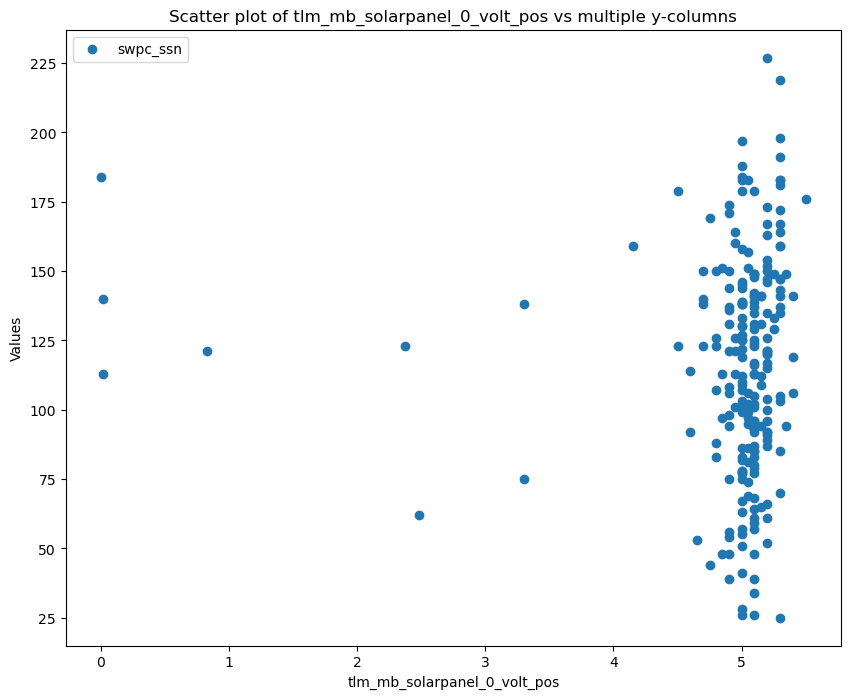

Analyzing ../data/cubebel-2/Solar Panels Current-data-2024-02-04 17 03 36.csv
Correlation 57175.distinct vs swpc_ssn: (0.3230075753530439, 0.25260828562166626, 0.30822504540385015)


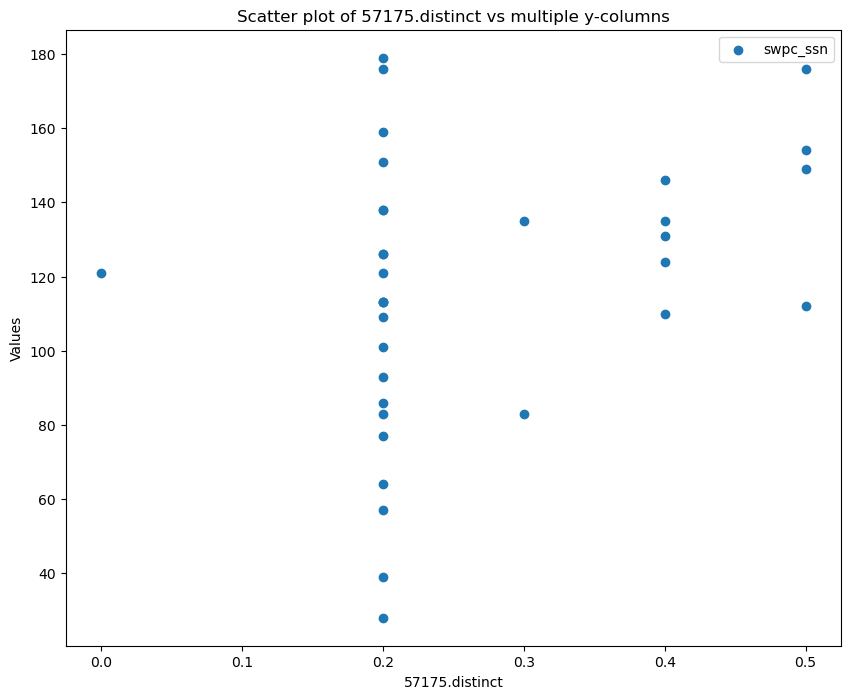

Analyzing ../data/cubebel-2/TRX Primary Current-data-2024-02-04 17 03 34.csv
Correlation 57175.distinct vs swpc_ssn: (-0.2094659266716358, -0.179495142361986, -0.21647874062259673)


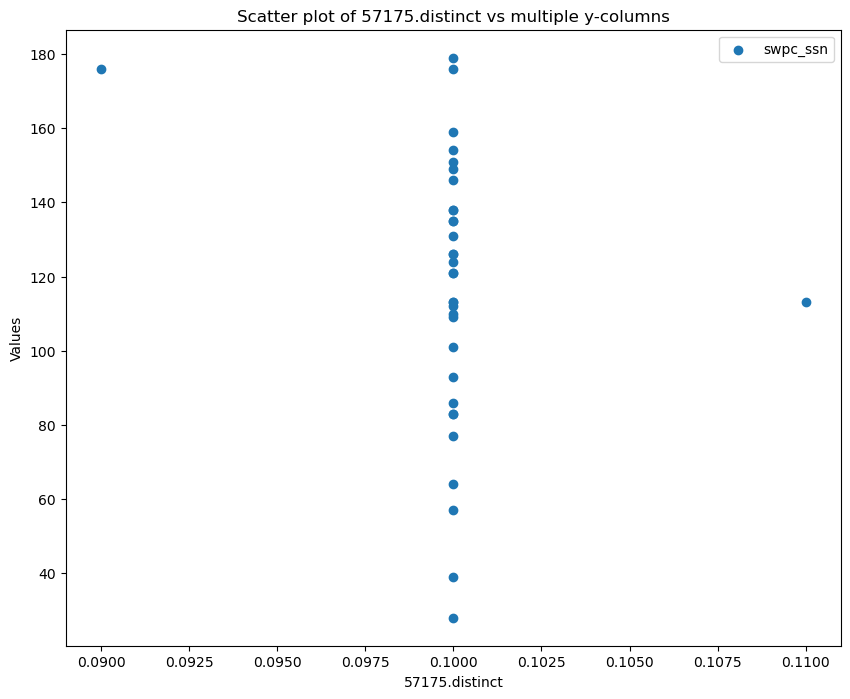

Analyzing ../data/cubebel-2/TRX Secondary Current-data-2024-02-04 17 03 33.csv
Correlation 57175.distinct vs swpc_ssn: (0.12304691605253801, 0.10452477866901551, 0.13884308005934465)


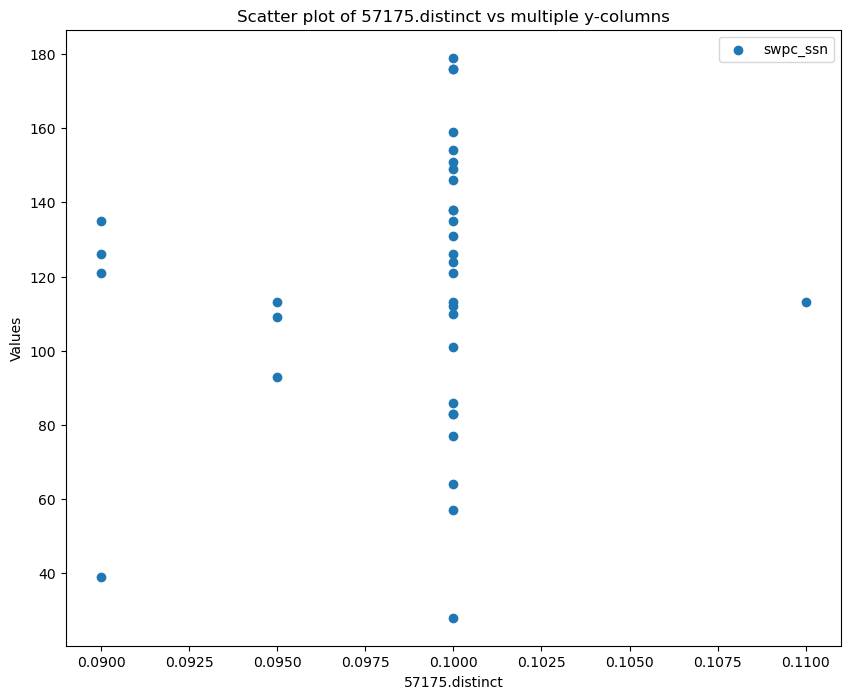

Analyzing ../data/cubebel-2/TRX Temperature-data-2024-02-04 17 03 41.csv
Correlation 57175.distinct vs swpc_ssn: (0.28411637494896697, 0.02891223361951317, 0.03975043040790226)


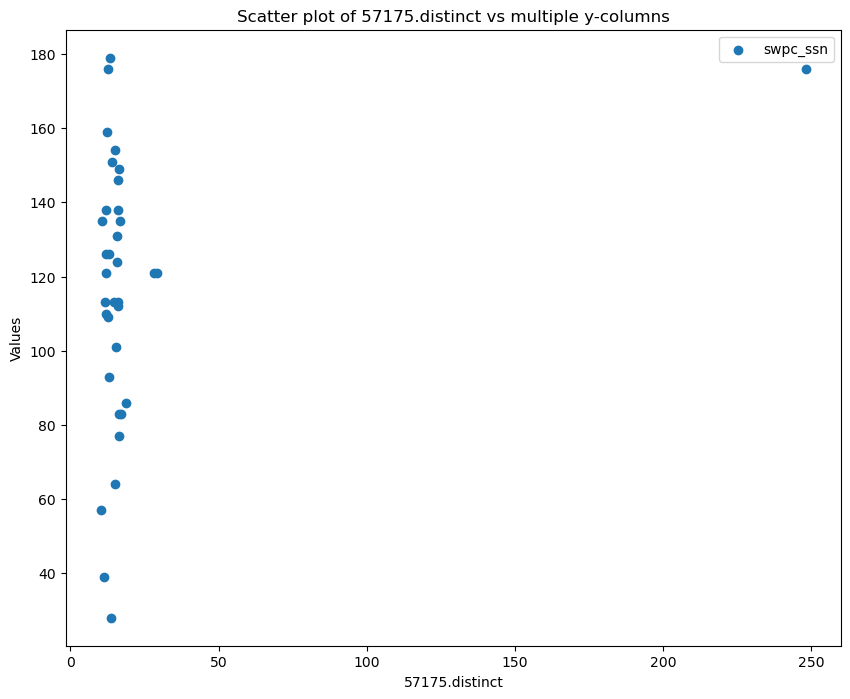

Analyzing ../data/cubebel-2/TRX Temperatures-data-2024-02-04 17 03 51.csv
Correlation tlm_trx_cmn_mcu_temp vs swpc_ssn: (-0.1337829948674821, -0.08701073040550991, -0.1272404403436875)


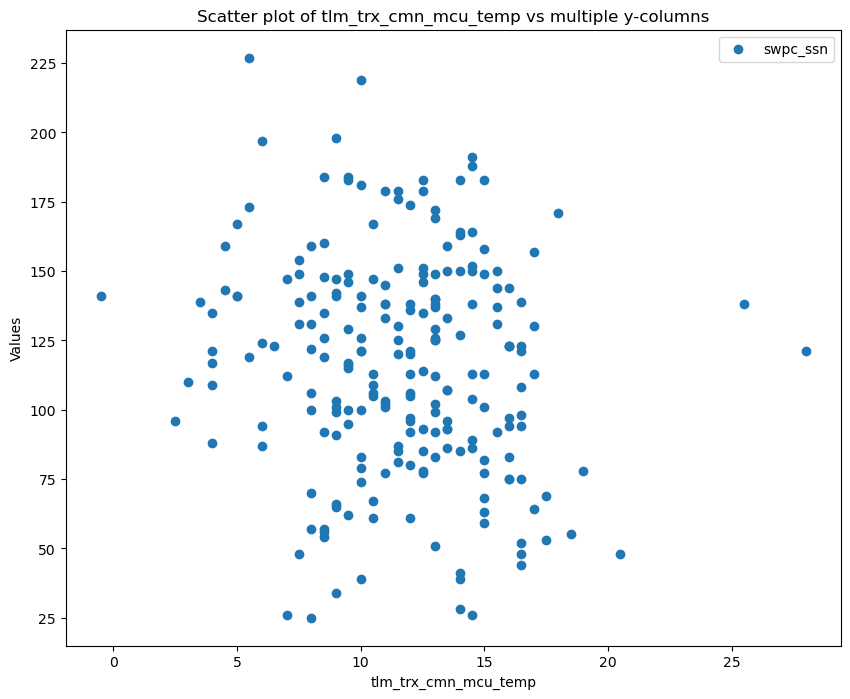

Analyzing ../data/cubebel-2/Voltages-data-2024-02-04 17 03 23.csv
Correlation tlm_mb_ant_1_v vs swpc_ssn: (0.004844633466461593, -0.0016313239741044382, -0.0020850223016425323)


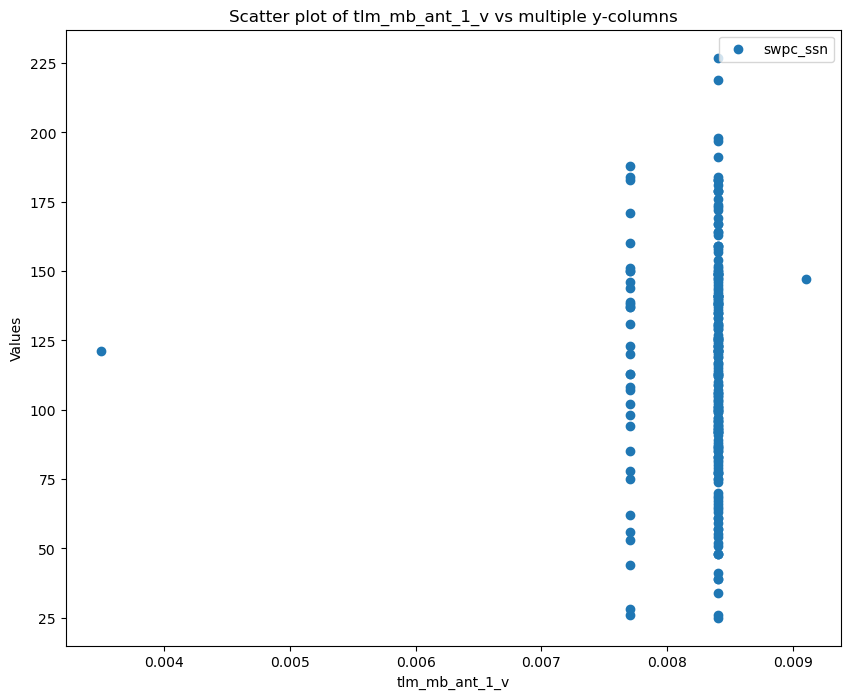

Analyzing ../data/cubebel-2/ADC Temperatures-data-2024-02-04 17 03 25.csv
Correlation tlm_mb_adc_temp_1 vs swpc_ssn: (0.014141174608712236, -0.07207605643073958, -0.10702702974543703)


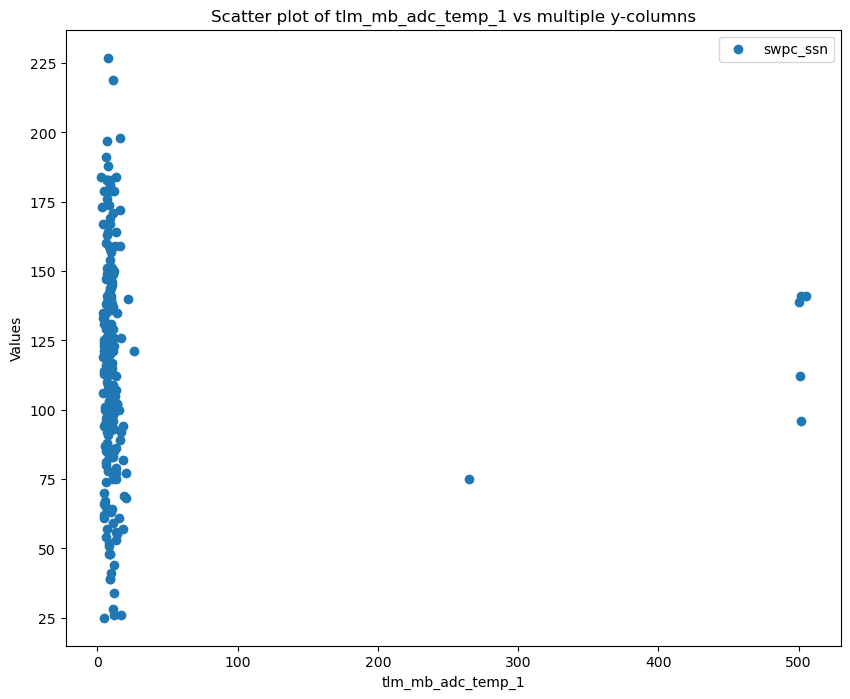

Analyzing ../data/cubebel-2/Battery 0 Temperature-data-2024-02-04 17 03 45.csv
Correlation 57175.distinct vs swpc_ssn: (0.28265432508077065, 0.09703821302589397, 0.14495417080322923)


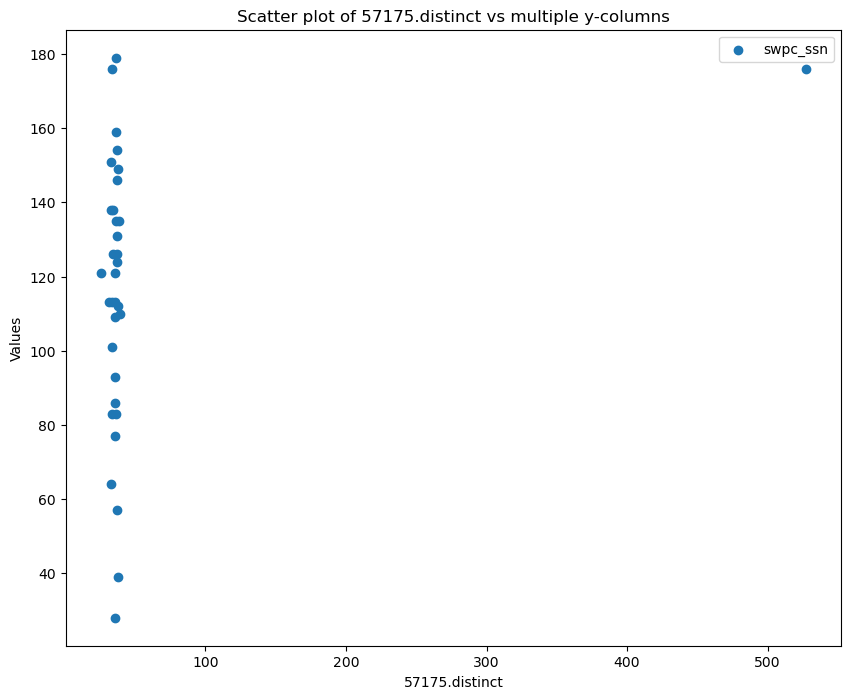

Analyzing ../data/cubebel-2/Battery 1 Temperature-data-2024-02-04 17 03 44.csv
Correlation 57175.distinct vs swpc_ssn: (0.28471175524295983, 0.09344420513604605, 0.161467937097268)


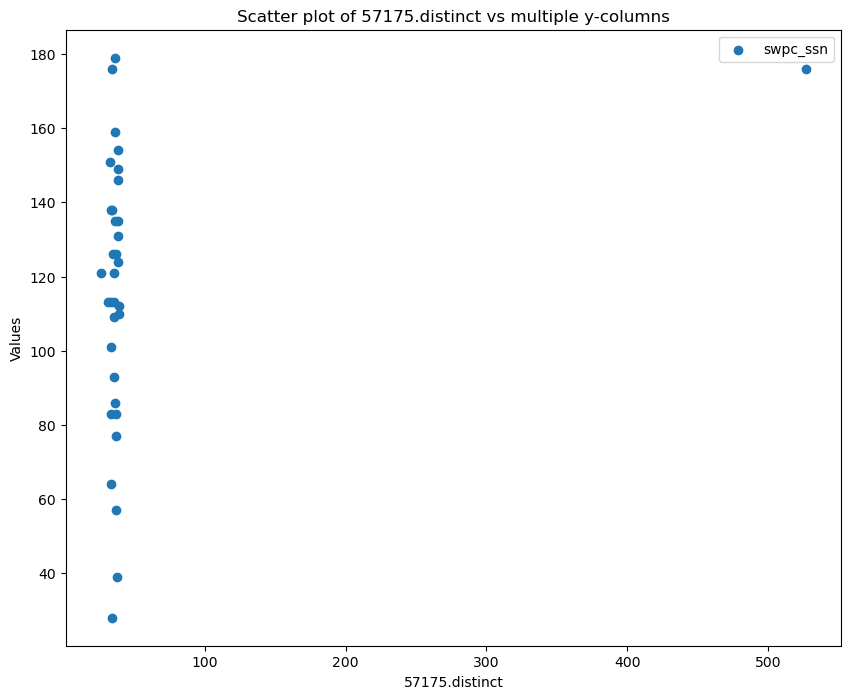

Analyzing ../data/cubebel-2/Battery Current-data-2024-02-04 17 03 28.csv
Correlation tlm_mb_bttpck_0_element_0_current vs swpc_ssn: (0.17798935959472656, 0.17539356203105674, 0.2275503868521716)


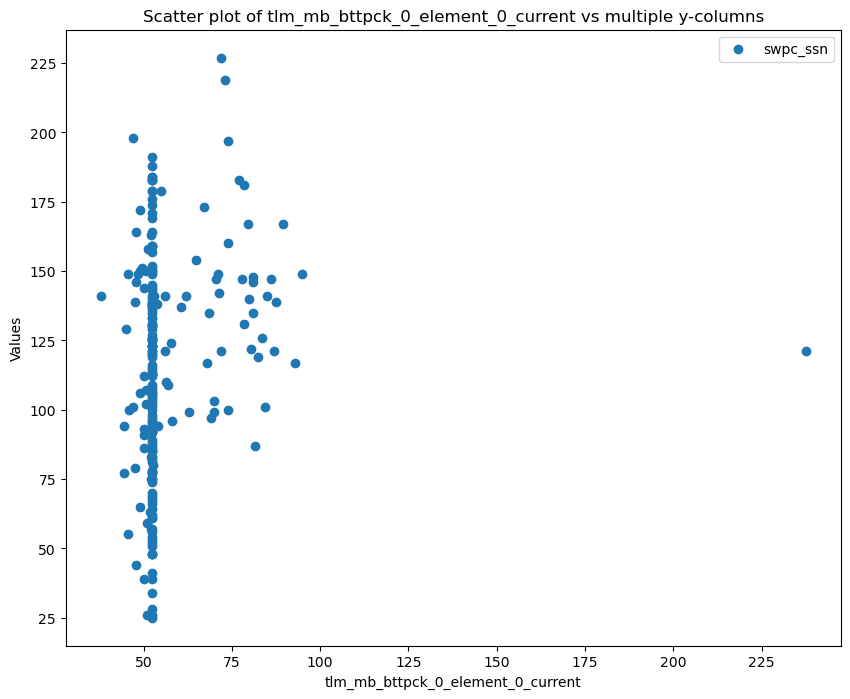

Analyzing ../data/cubebel-2/Battery Current-data-2024-02-04 17 03 47.csv
Correlation 57175.distinct vs swpc_ssn: (-0.016755896171278577, 0.1430397079704303, 0.19585071255436898)


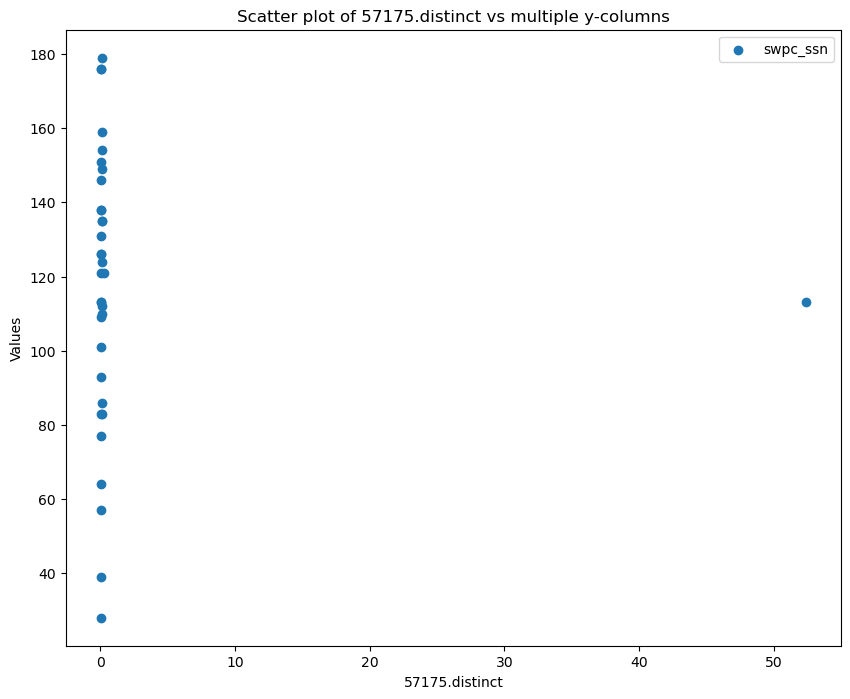

Analyzing ../data/cubebel-2/Battery Voltage-data-2024-02-04 17 03 32.csv
Correlation 57175.distinct vs swpc_ssn: (-0.08426406116216847, -0.24234588591919806, -0.326314095680748)


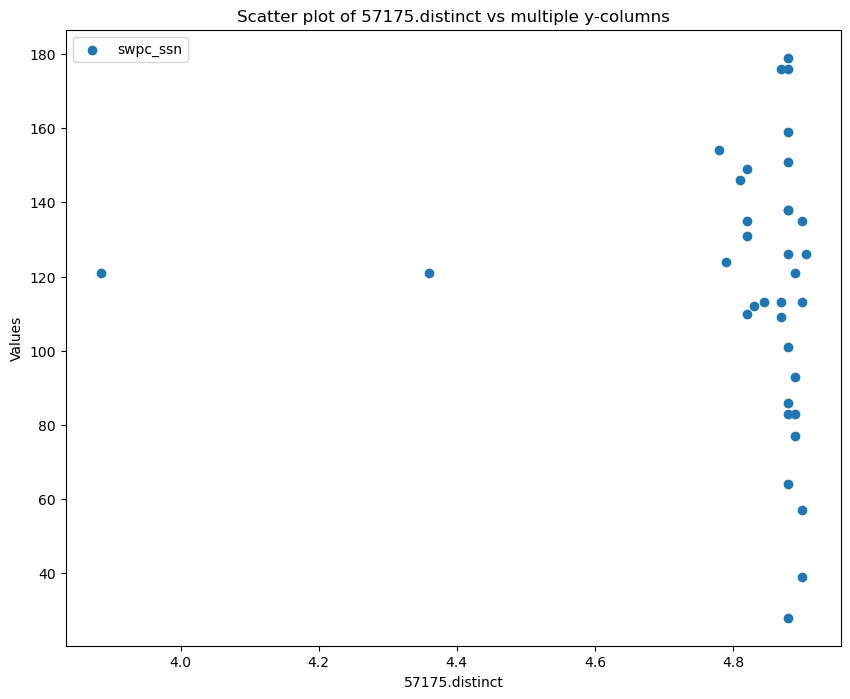

Analyzing ../data/cubebel-2/Digipeater -data-2024-02-04 17 04 08.csv
Correlation beacon_rx_settings vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


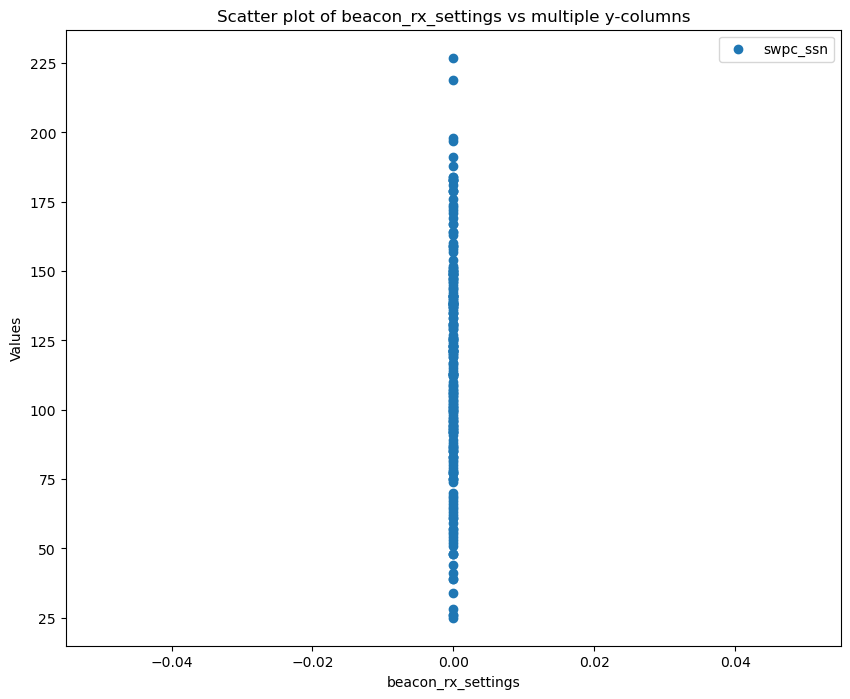

Analyzing ../data/cubebel-2/Ground Stations Leaderboard By Observed Frames-data-2024-02-04 17 03 20.csv
Correlation 9V1KG vs swpc_ssn: (0.314838698950454, 0.32326963017393173, 0.4074446470220524)


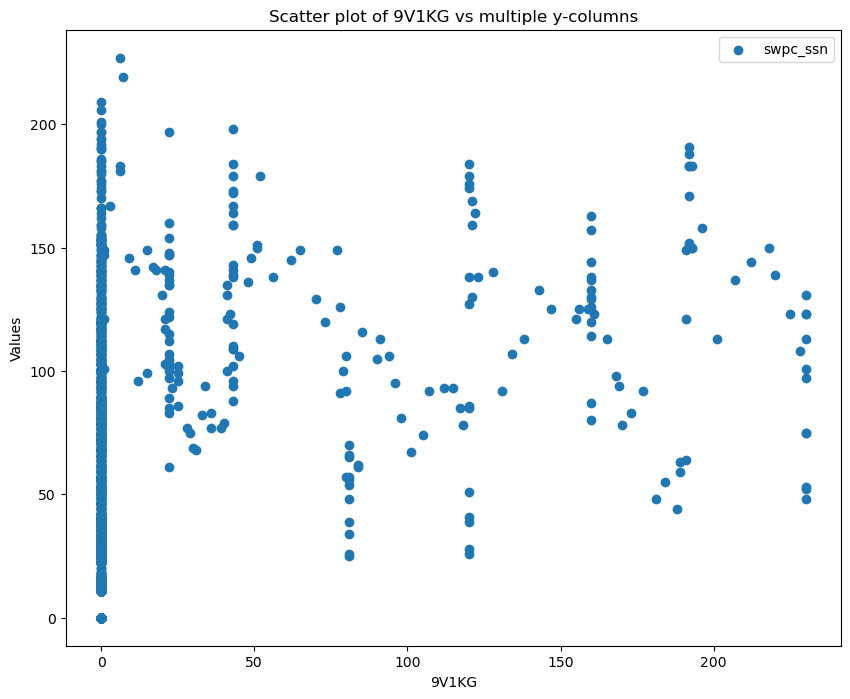

Analyzing ../data/cubebel-2/Last Frame Time-data-2024-02-04 17 04 11.csv
Correlation 57175.ctl vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


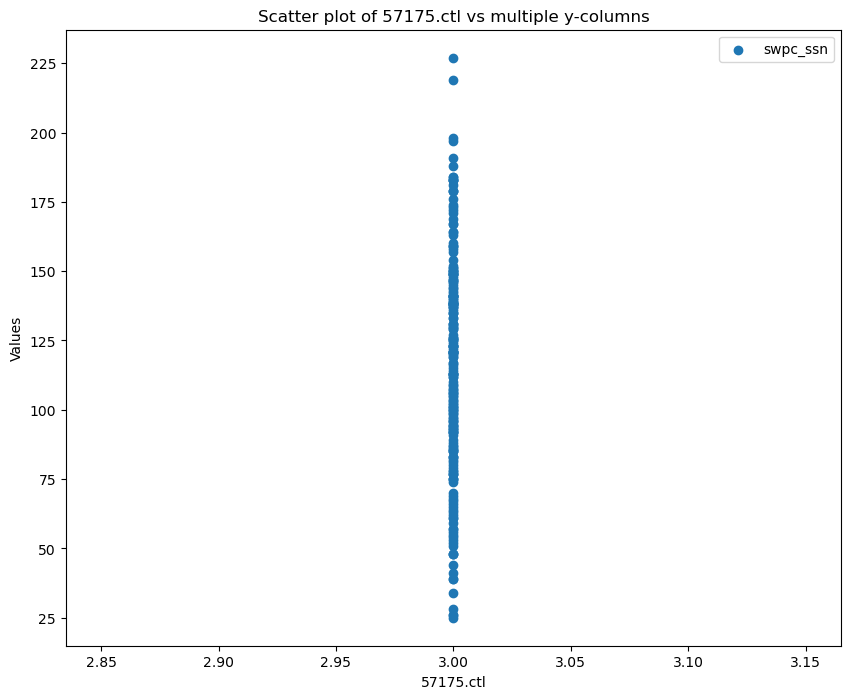

In [222]:
analyze_satellite('cubebel-2')

Analyzing ../data/delfi-pq/Battery Voltage-data-2024-02-04 18 18 26.csv
Correlation 51074.mode vs swpc_ssn: (0.15240721181559955, 0.08720415986797538, 0.10814943333611993)


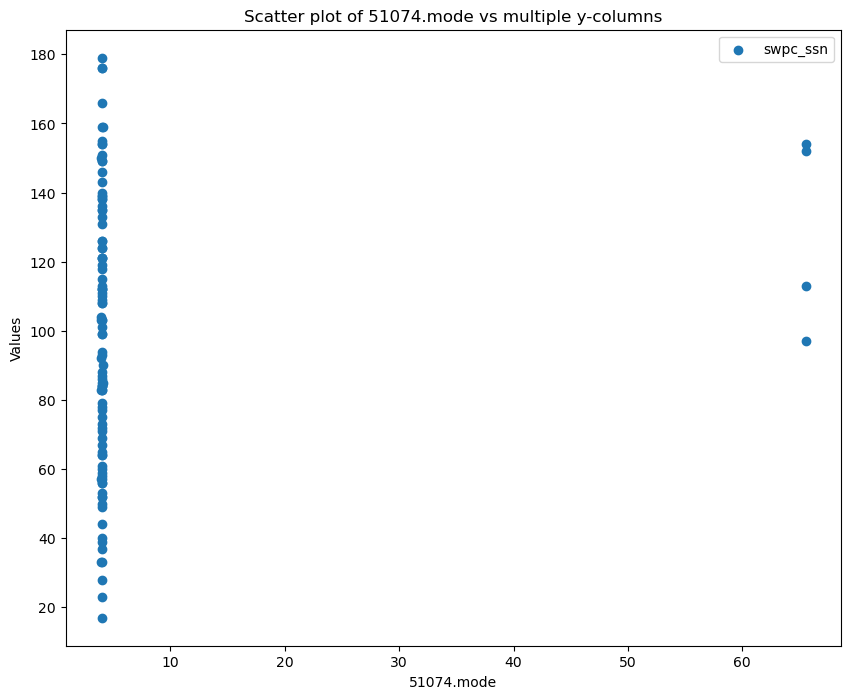

Analyzing ../data/delfi-pq/Currents-data-2024-02-04 18 18 43.csv
Correlation Current vs swpc_ssn: (-0.04249925894302116, -0.039862636061729, -0.0580247347444164)


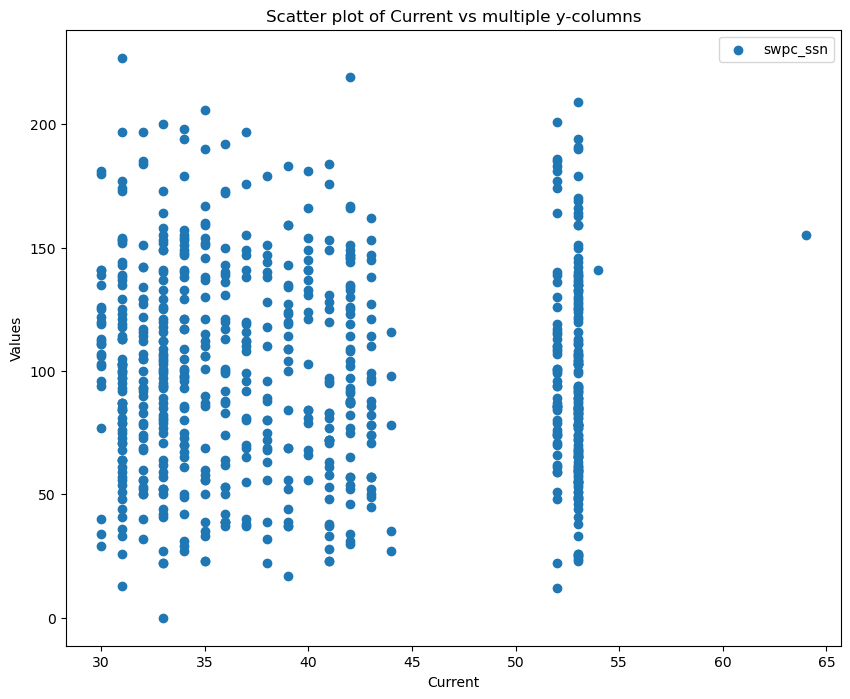

Analyzing ../data/delfi-pq/Last Frame Rcvd By-data-2024-02-04 18 18 39.csv
Analyzing ../data/delfi-pq/Solar Panel Currents-data-2024-02-04 18 18 54.csv
Correlation Cell Xm vs swpc_ssn: (0.09008220346801377, 0.03794476984513911, 0.052047479334271826)


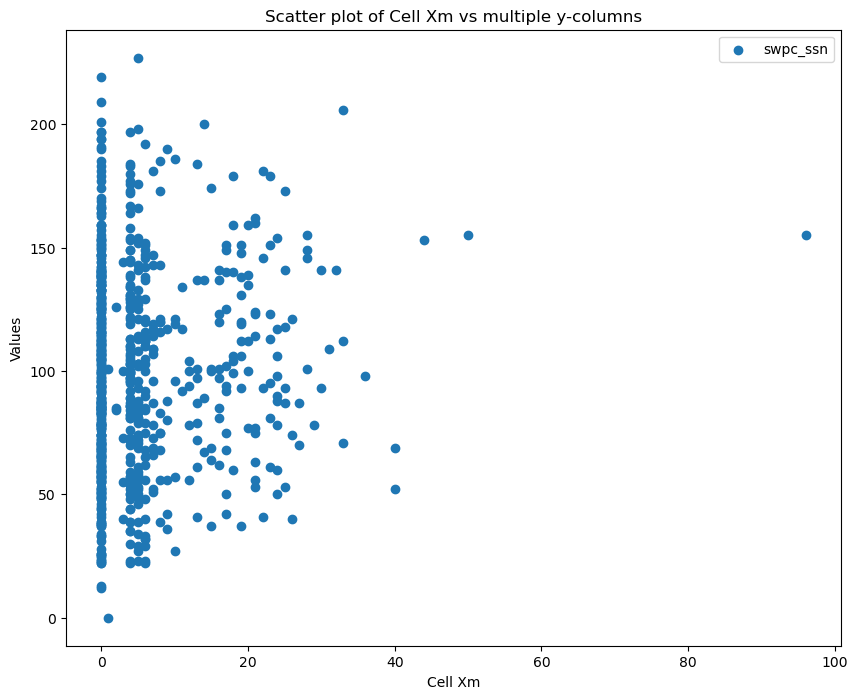

Analyzing ../data/delfi-pq/Solar Panel Voltages-data-2024-02-04 18 18 49.csv
Analyzing ../data/delfi-pq/System Temperatures (C)-data-2024-02-04 18 18 45.csv
Correlation Temp vs swpc_ssn: (-0.0486885209969075, -0.04403388828312254, -0.06346565557009469)


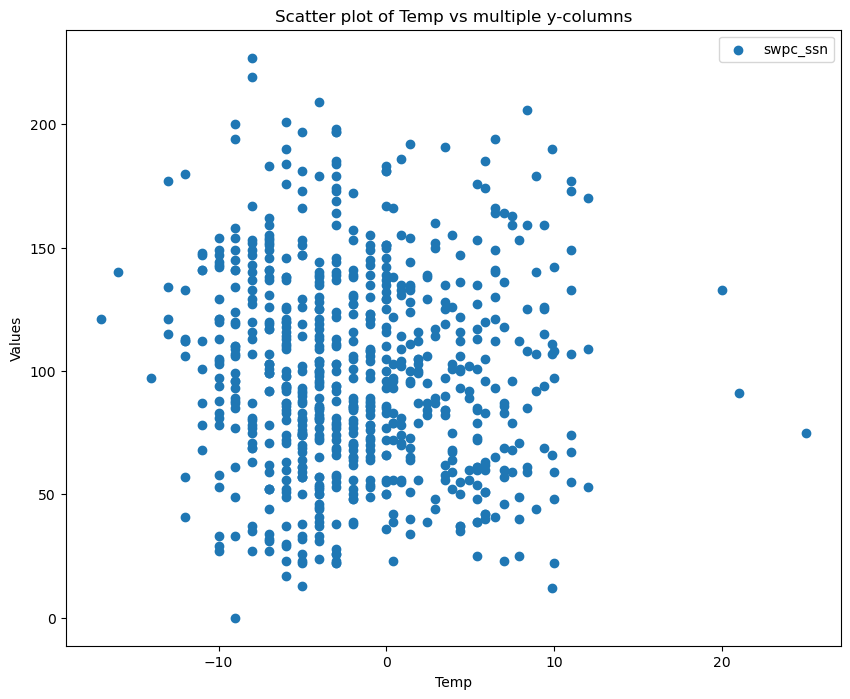

In [223]:
analyze_satellite('delfi-pq')

Analyzing ../data/dhabisat/Estimation Mode-data-2024-02-04 18 19 32.csv
Analyzing ../data/dhabisat/Latitude _ Longitude-data-2024-02-04 18 20 00.csv
Correlation Latitude vs swpc_ssn: (0.011348841236622083, 0.0070558541329502214, 0.008718167262398864)


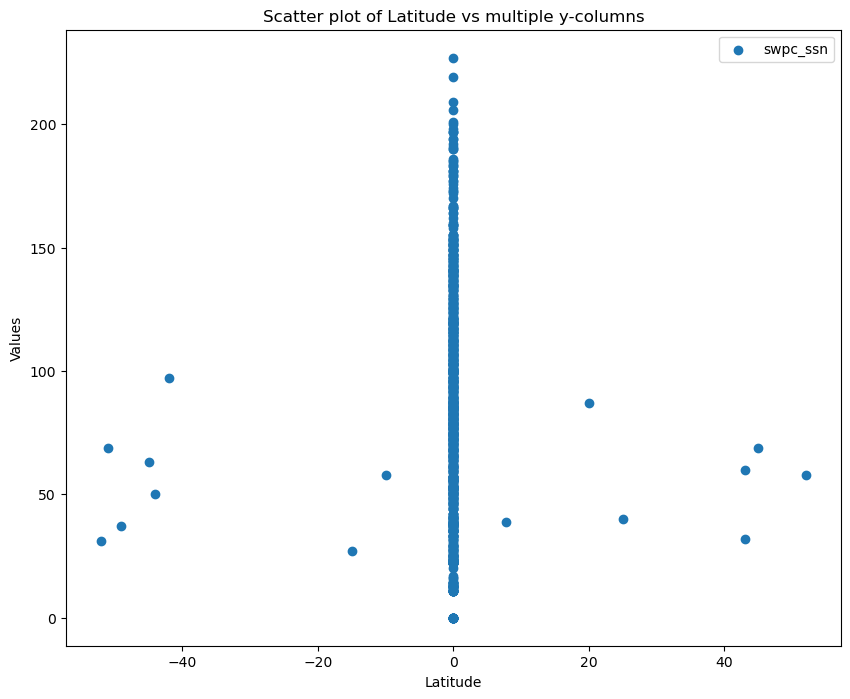

Analyzing ../data/dhabisat/Messages-data-2024-02-04 18 19 20.csv
Analyzing ../data/dhabisat/OBC Mode-data-2024-02-04 18 19 01.csv
Analyzing ../data/dhabisat/OBC Reset Counter-data-2024-02-04 18 19 25.csv
Correlation OBC Reset Counter vs swpc_ssn: (0.5692809894119778, 0.4227728255565579, 0.5844551948604333)


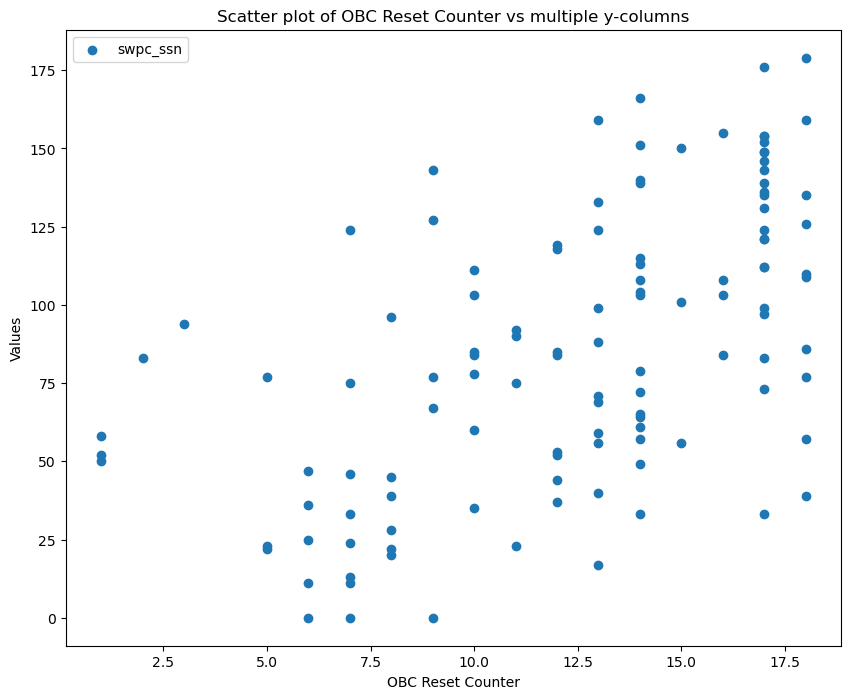

Analyzing ../data/dhabisat/OBC UNIX Timestamp-data-2024-02-04 18 19 16.csv
Analyzing ../data/dhabisat/Position-data-2024-02-04 18 19 57.csv
Correlation X Position vs swpc_ssn: (0.060327606291762446, 0.04238704393286187, 0.05192124471827751)


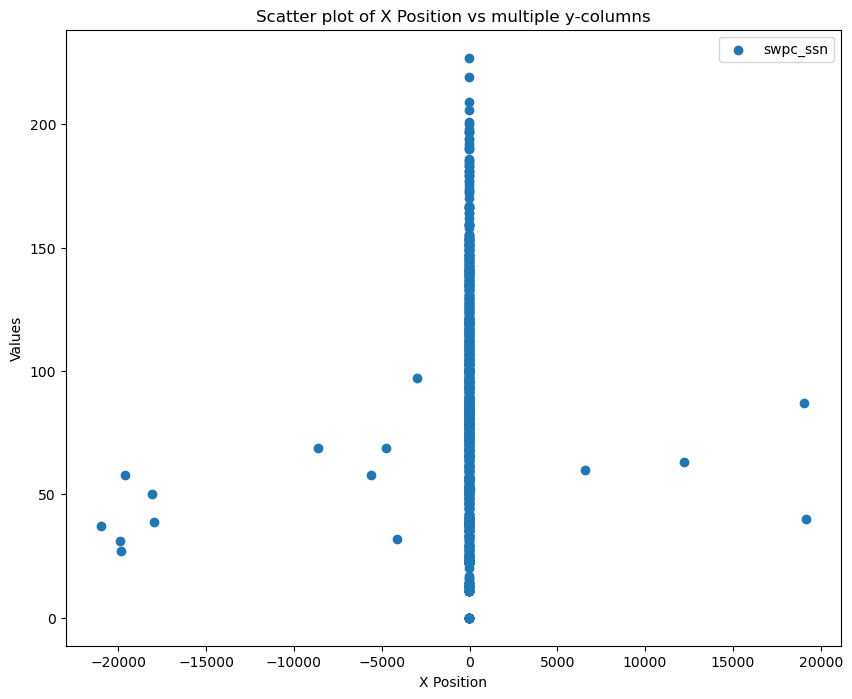

Analyzing ../data/dhabisat/Power-data-2024-02-04 18 19 51.csv
Analyzing ../data/dhabisat/Reset Counters-data-2024-02-04 18 19 15.csv
Correlation OBC Reset Count vs swpc_ssn: (0.5793429651245532, 0.44353334995673827, 0.6096214435917657)


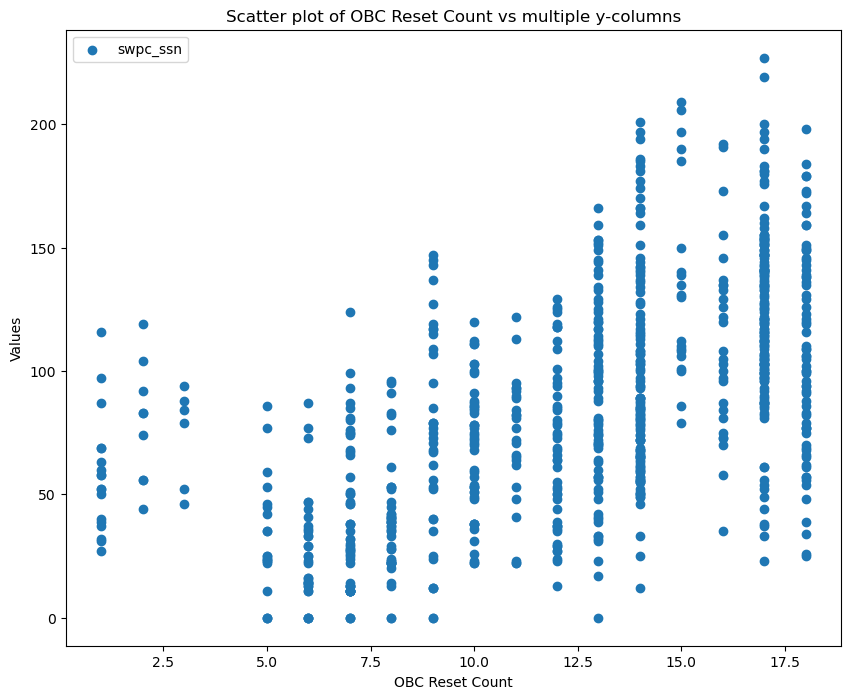

Analyzing ../data/dhabisat/Run Mode-data-2024-02-04 18 19 24.csv
Analyzing ../data/dhabisat/Subsystem Safety Criteria-data-2024-02-04 18 19 26.csv
Analyzing ../data/dhabisat/Velocity-data-2024-02-04 18 20 03.csv
Correlation X Velocity vs swpc_ssn: (0.0031158731313645966, -0.018300709156814327, -0.022588323767765865)


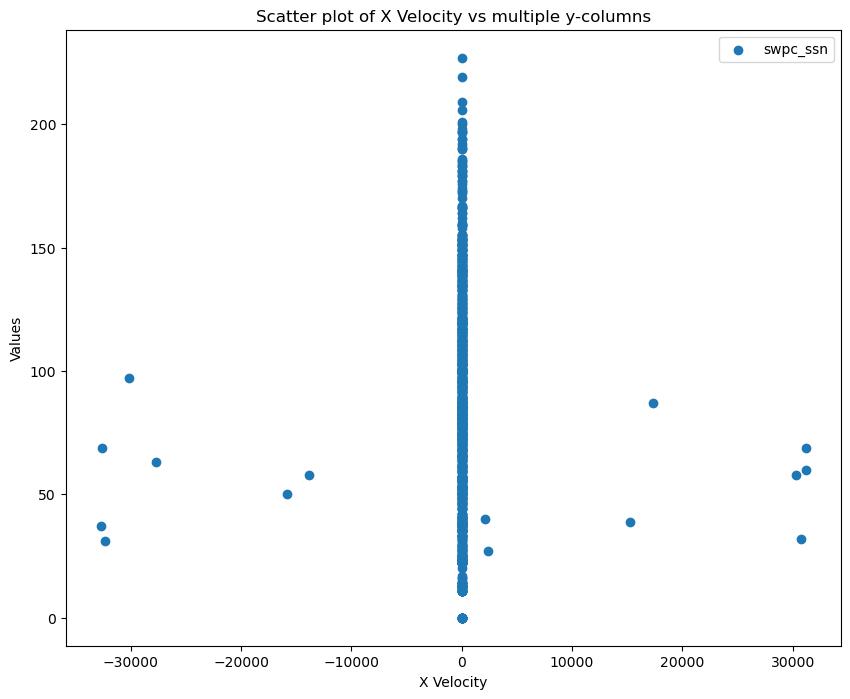

Analyzing ../data/dhabisat/Wheel Speeds-data-2024-02-04 18 19 54.csv
Correlation X Wheel Speed vs swpc_ssn: (-0.09188944294849445, -0.08006616452415628, -0.0976881761059848)


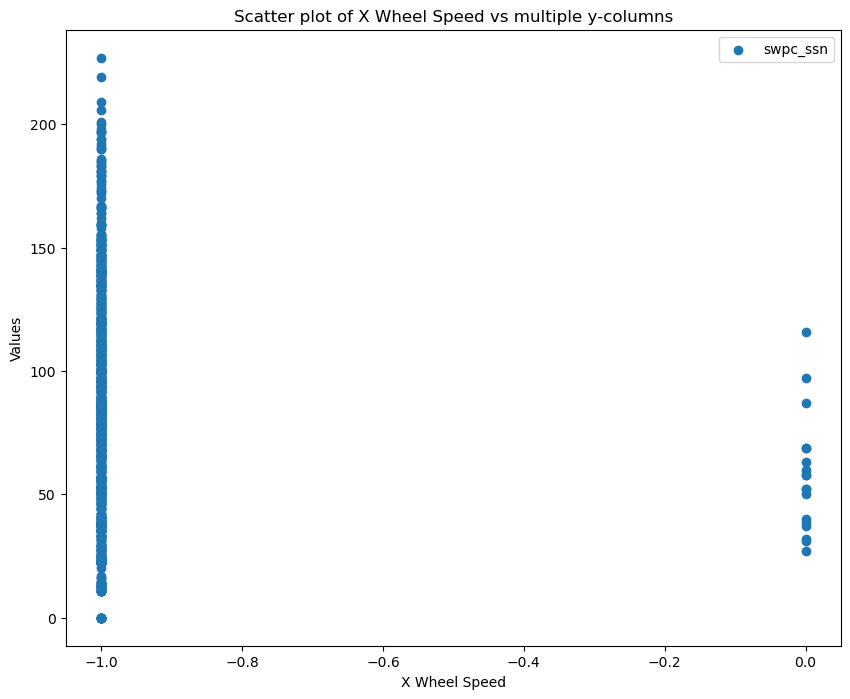

Analyzing ../data/dhabisat/ADCS Power Lines-data-2024-02-04 18 19 38.csv
Analyzing ../data/dhabisat/Altitude-data-2024-02-04 18 20 06.csv
Correlation Altitute vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


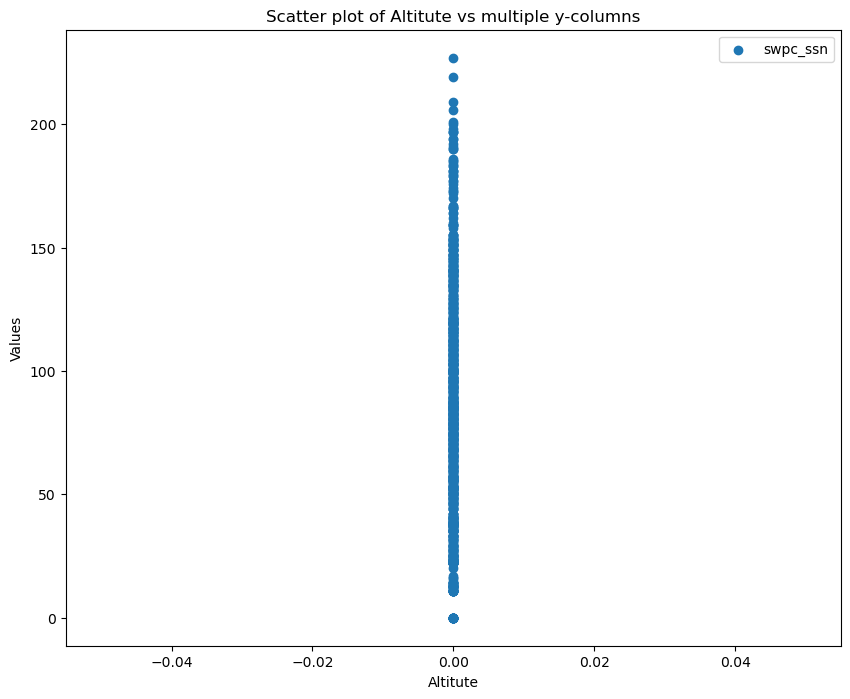

Analyzing ../data/dhabisat/Angular Rates-data-2024-02-04 18 19 41.csv
Correlation X Angular Rate vs swpc_ssn: (-0.07938819030038663, -0.07690365103159753, -0.09424534884509796)


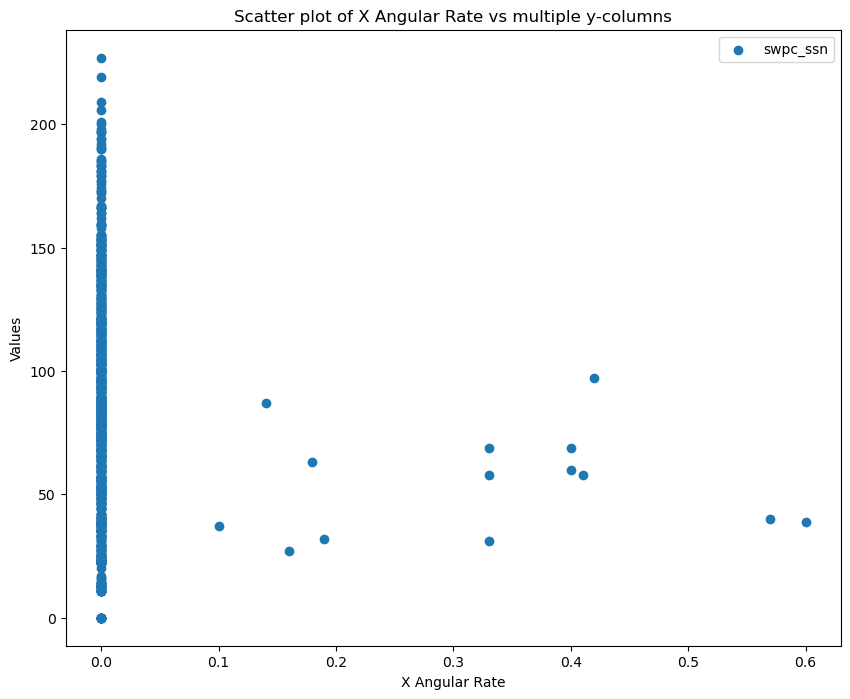

Analyzing ../data/dhabisat/Battery Voltage-data-2024-02-04 18 19 30.csv
Analyzing ../data/dhabisat/Control Mode-data-2024-02-04 18 19 34.csv
Analyzing ../data/dhabisat/ECEF Position-data-2024-02-04 18 20 09.csv
Correlation ECEF Position X vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


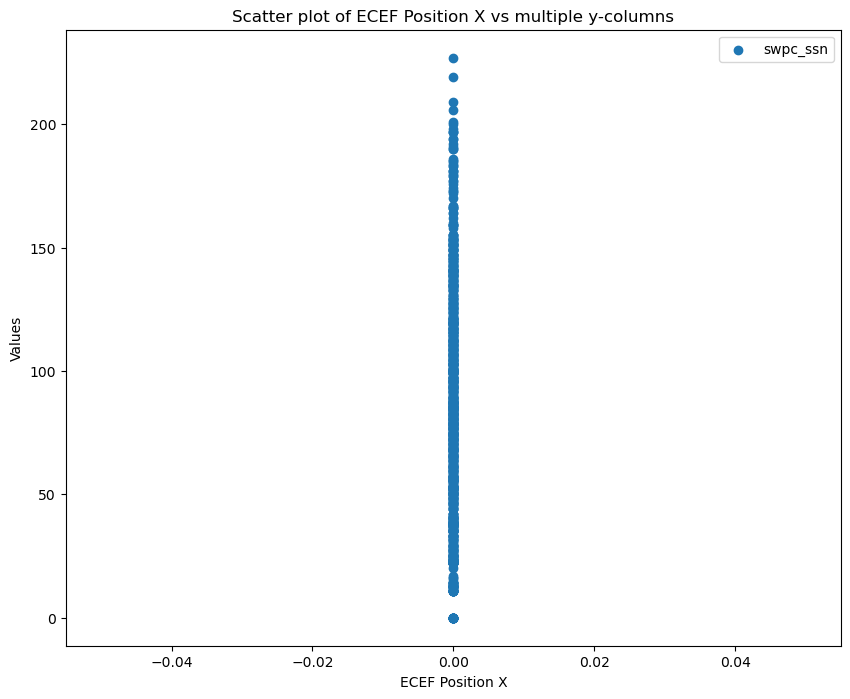

Analyzing ../data/dhabisat/EPS Last Error-data-2024-02-04 18 19 28.csv
Correlation EPS Last Error vs swpc_ssn: (0.12655498289219538, 0.10295637387482215, 0.1252283392480259)


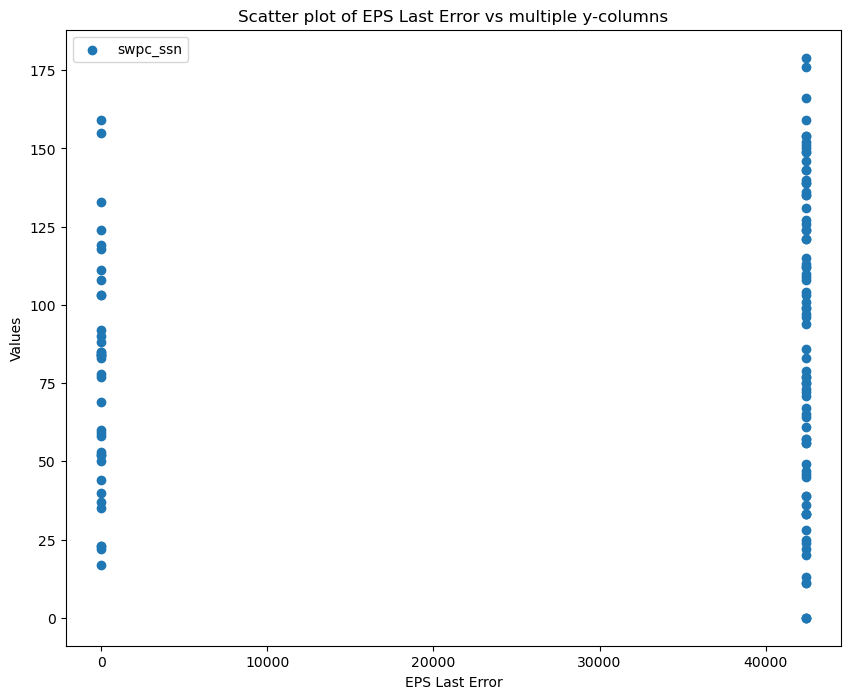

Analyzing ../data/dhabisat/EPS Last Reset Cause-data-2024-02-04 18 19 18.csv
Analyzing ../data/dhabisat/EPS Mode-data-2024-02-04 18 18 59.csv
Analyzing ../data/dhabisat/Estimated Angular Rates-data-2024-02-04 18 19 43.csv
Correlation Estimated X Angular Rate vs swpc_ssn: (-0.039515661439522766, -0.03398200601136489, -0.04143452771262478)


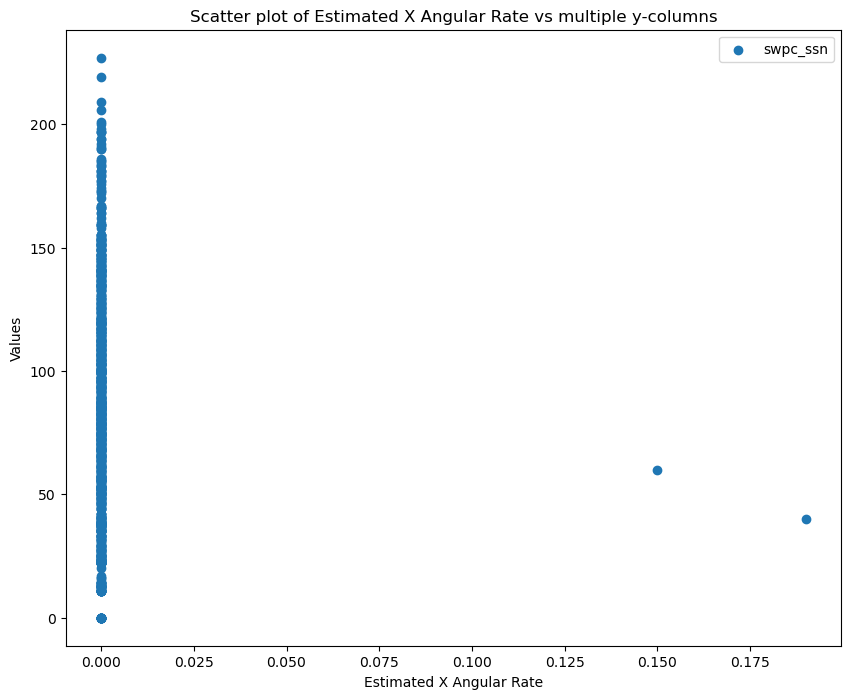

Analyzing ../data/dhabisat/Estimated Quaternions-data-2024-02-04 18 19 46.csv
Correlation Estimated Q1 vs swpc_ssn: (-0.09188944294849445, -0.08006616452415628, -0.0976881761059848)


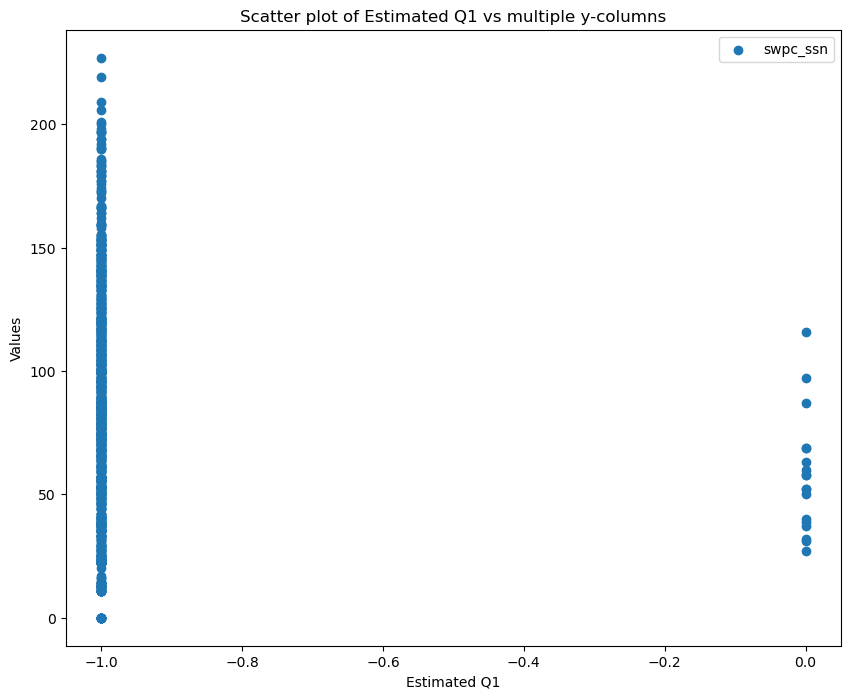

Analyzing ../data/dhabisat/Estimated Roll_Pitch_Yaw-data-2024-02-04 18 19 49.csv
Correlation Estimated Roll Angle vs swpc_ssn: (-0.09188944294849445, -0.08006616452415628, -0.0976881761059848)


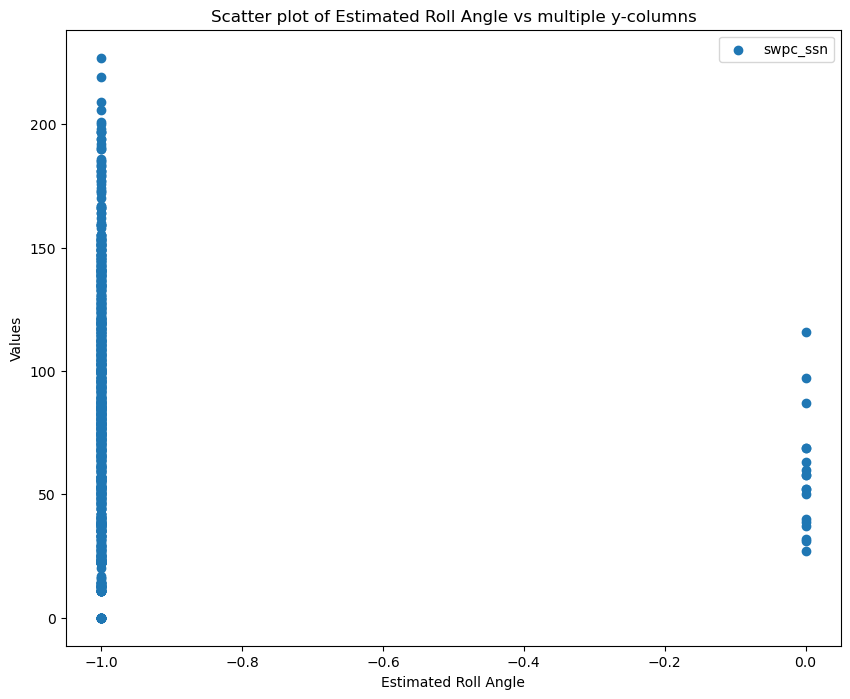

In [224]:
analyze_satellite('dhabisat')

Analyzing ../data/geoscan-edelveis/-data-2024-02-04 18 18 06.csv
Correlation Batteriesoltage vs swpc_ssn: (0.036138371202044314, 0.020395238659781757, 0.030006195647520932)


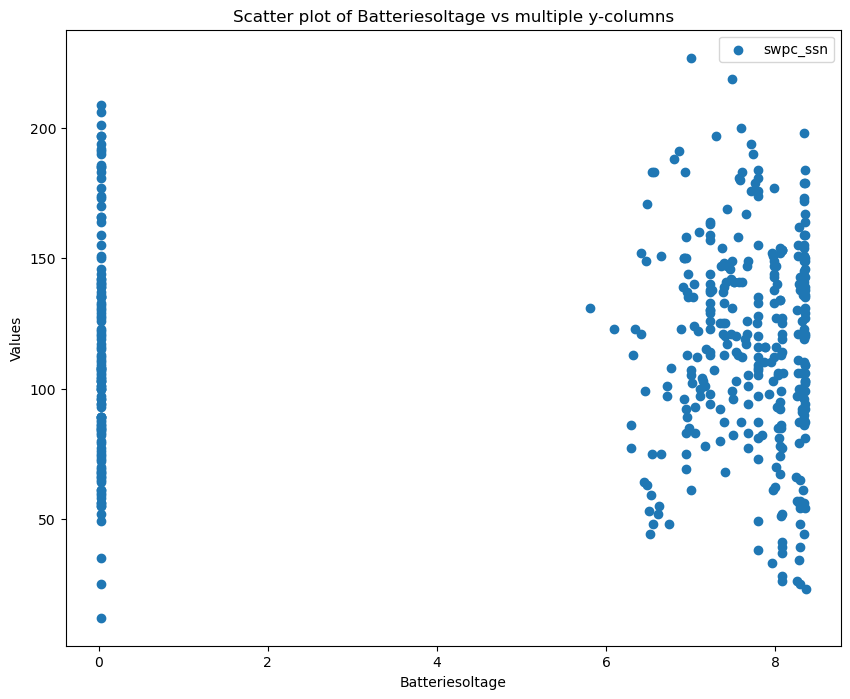

Analyzing ../data/geoscan-edelveis/Callsign-data-2024-02-04 18 18 08.csv
Analyzing ../data/geoscan-edelveis/Data last trasmitted-data-2024-02-04 18 17 53.csv
Analyzing ../data/geoscan-edelveis/Days on Orbit-data-2024-02-04 18 17 14.csv
Analyzing ../data/geoscan-edelveis/Ground Stations Leaderboard By Observed Telemetry Frames-data-2024-02-04 18 17 31.csv
Correlation ArgusNavis vs swpc_ssn: (0.4904698571990434, 0.423227822705112, 0.5330236437961954)


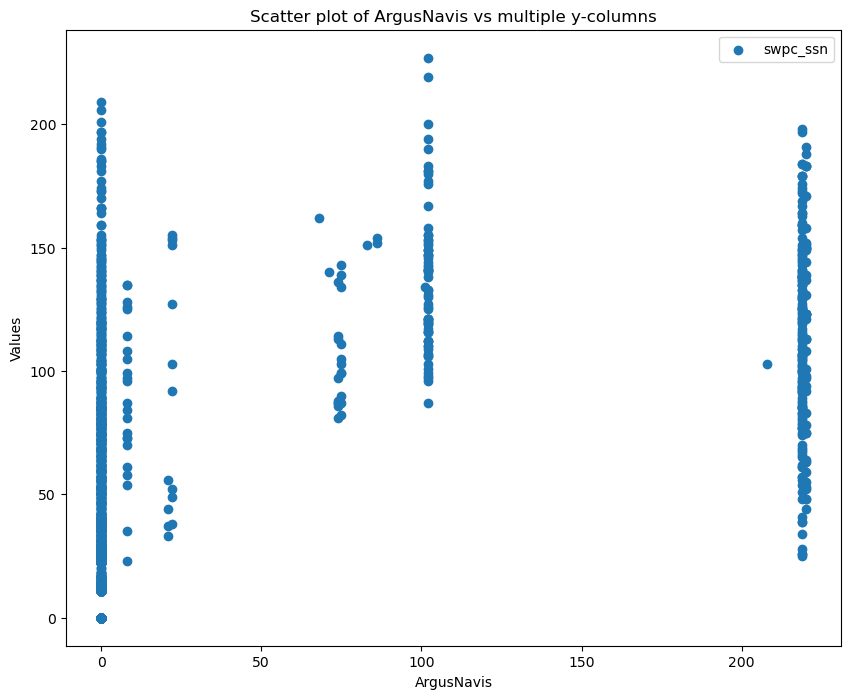

Analyzing ../data/geoscan-edelveis/Kilometers Passed on Orbit-data-2024-02-04 18 17 16.csv
Correlation 53385.obc_stamp vs swpc_ssn: (0.04438506952521352, 0.04051348096798995, 0.06106875125644223)


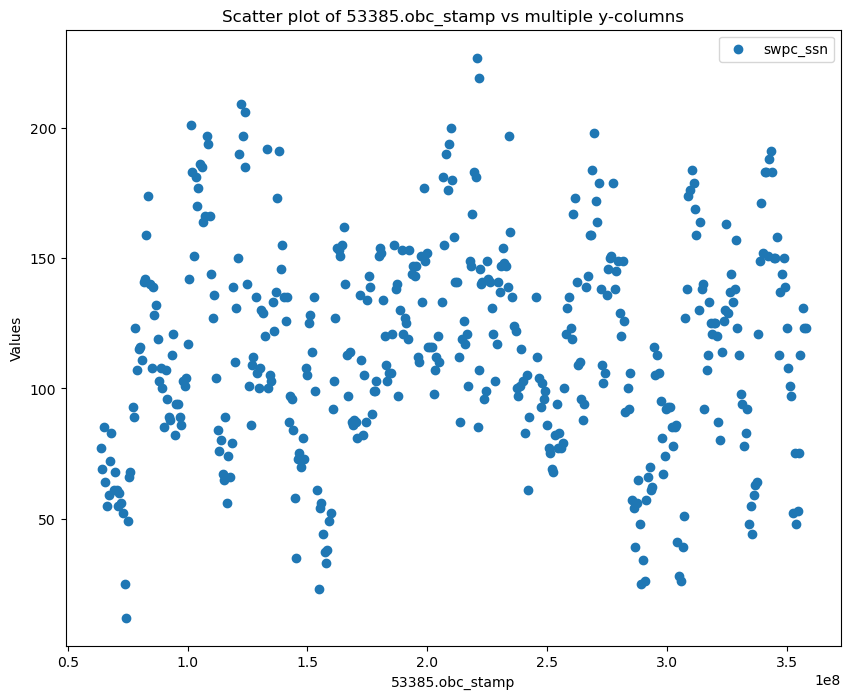

Analyzing ../data/geoscan-edelveis/Msg Type-data-2024-02-04 18 18 09.csv
Analyzing ../data/geoscan-edelveis/RSSI-data-2024-02-04 18 16 56.csv
Correlation Comm UHF Modem RSSI vs swpc_ssn: (0.09104870362804733, 0.07495365646607387, 0.10560696405923865)


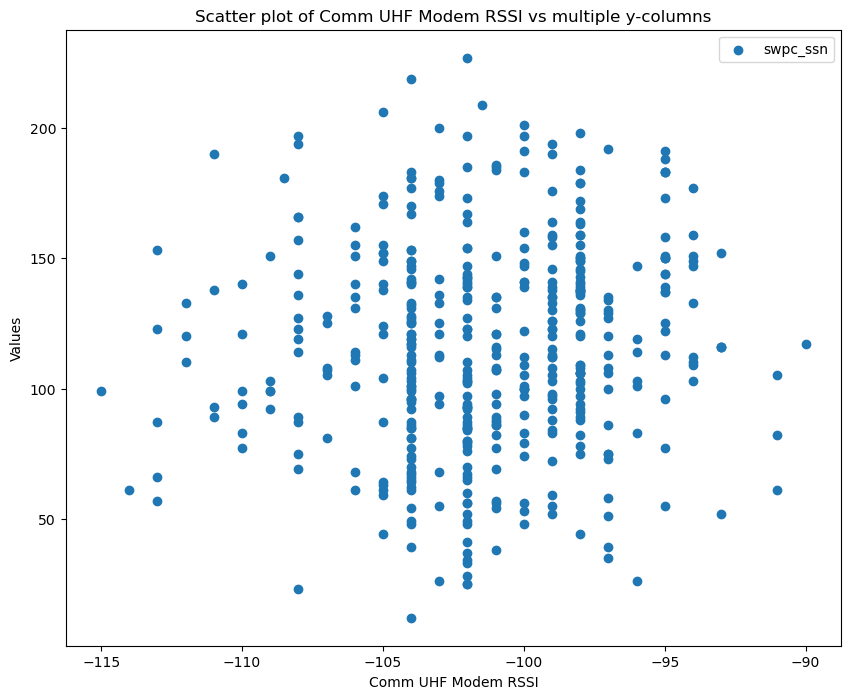

Analyzing ../data/geoscan-edelveis/Satellite-data-2024-02-04 18 17 48.csv
Analyzing ../data/geoscan-edelveis/Selected Telemetry Frames Count-data-2024-02-04 18 17 41.csv
Correlation cumulative_sum vs swpc_ssn: (0.534878689050491, 0.6139720485330565, 0.8075958065387653)


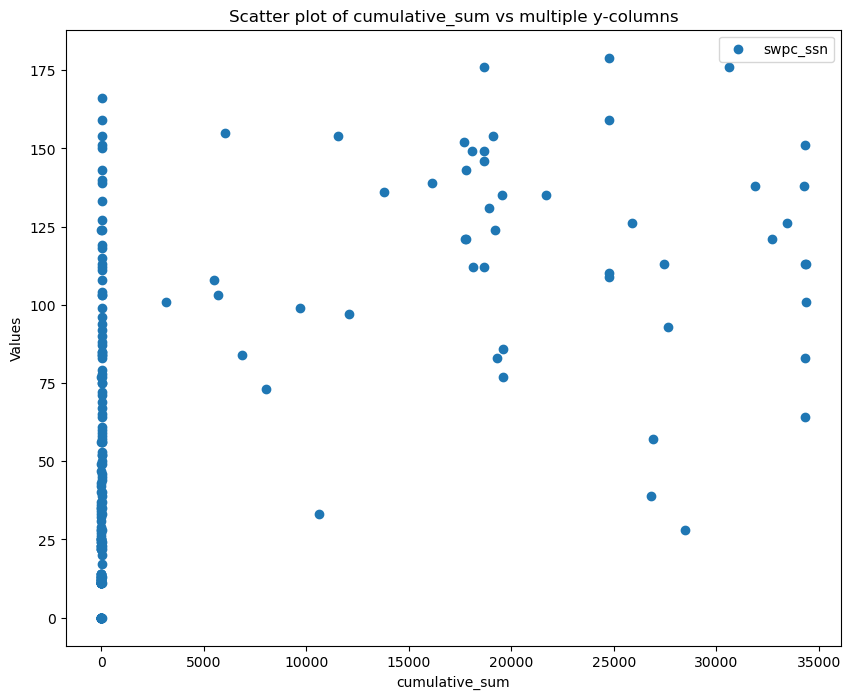

Analyzing ../data/geoscan-edelveis/System Temperatures-data-2024-02-04 18 17 00.csv


In [226]:
analyze_satellite('geoscan-edelveis')

Analyzing ../data/grbalpha/Battery voltage-data-2024-02-04 18 23 55.csv
Analyzing ../data/grbalpha/COM MCU Voltage-data-2024-02-04 18 24 19.csv
Correlation 47959.mcu_10mv vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


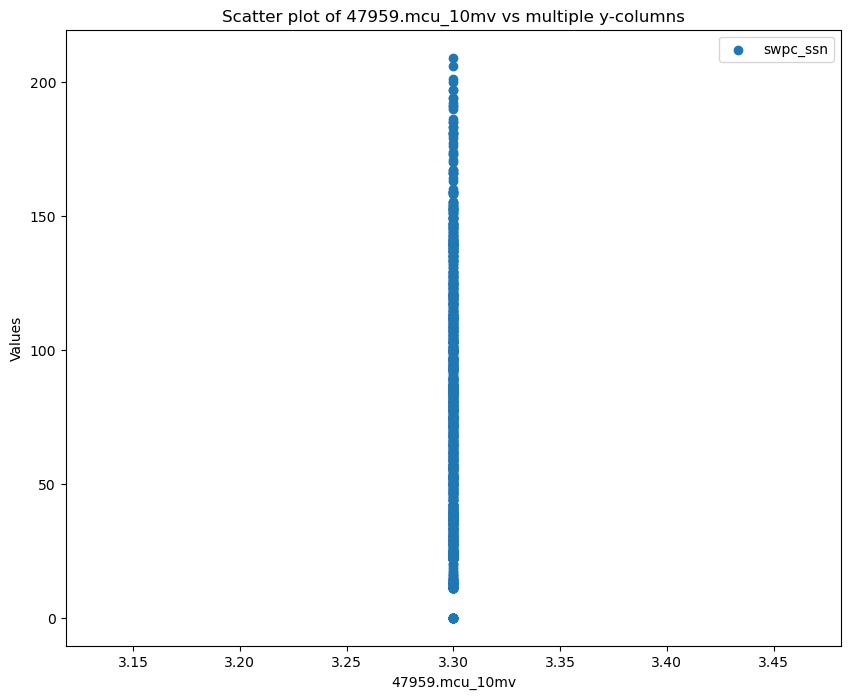

/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


Analyzing ../data/grbalpha/Observing station leaderboard-data-2024-02-04 18 24 44.csv
Correlation count vs swpc_ssn: (nan, nan, nan)


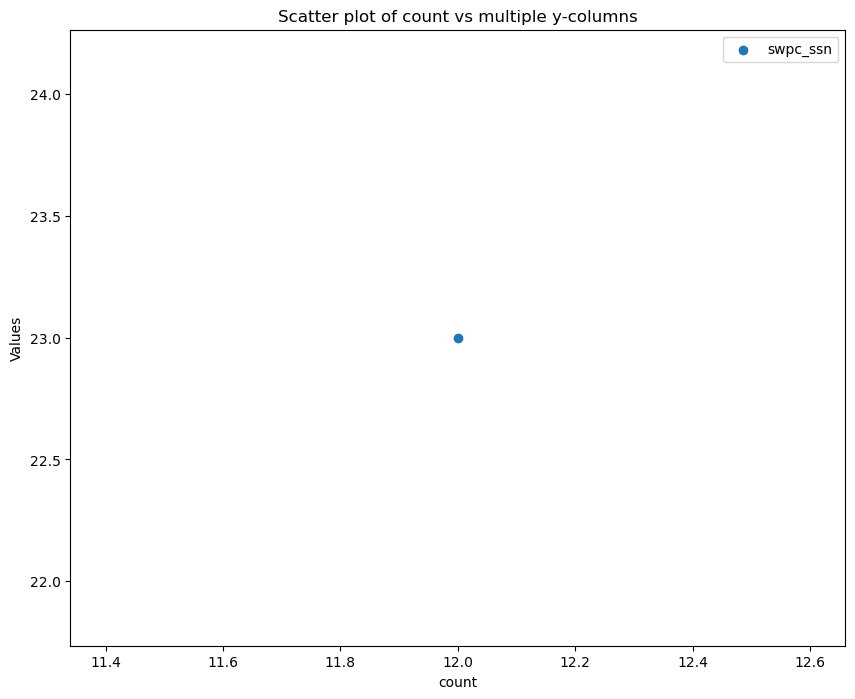

In [227]:
analyze_satellite('grbalpha')

Analyzing ../data/ledsat/Battery Current-data-2024-02-04 18 14 43.csv
Correlation Total current coming from solar panels vs swpc_ssn: (-0.019856481553725828, -0.27074873909025304, -0.34641262261892436)


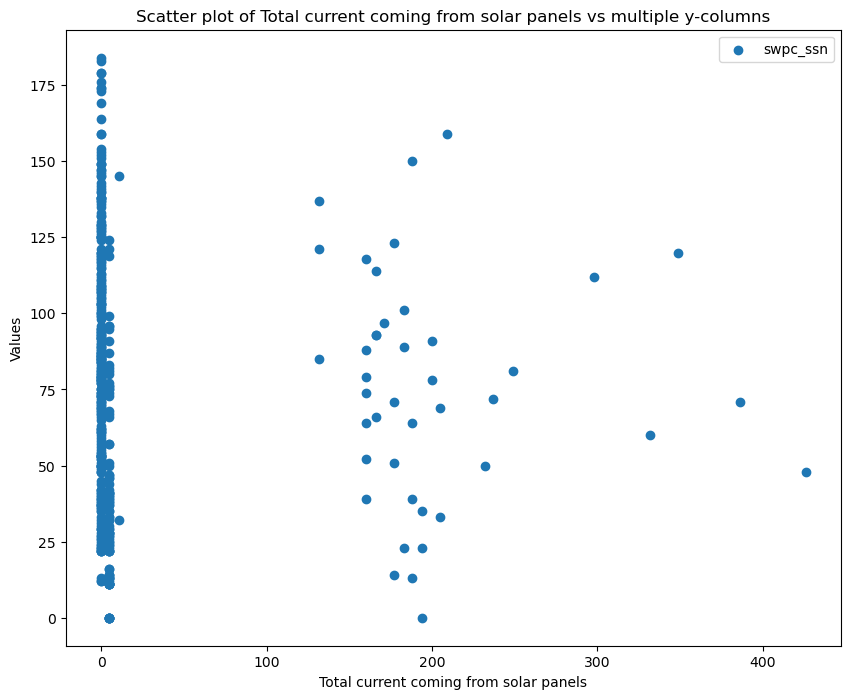

Analyzing ../data/ledsat/Battery Voltage-data-2024-02-04 18 14 22.csv
Analyzing ../data/ledsat/Last Frame Rcvd By-data-2024-02-04 18 14 41.csv
Analyzing ../data/ledsat/Solar Panel Temperatures-data-2024-02-04 18 14 53.csv
Correlation +X solar panel vs swpc_ssn: (-0.03952950465220578, -0.008764757209664546, -0.014055204429377088)


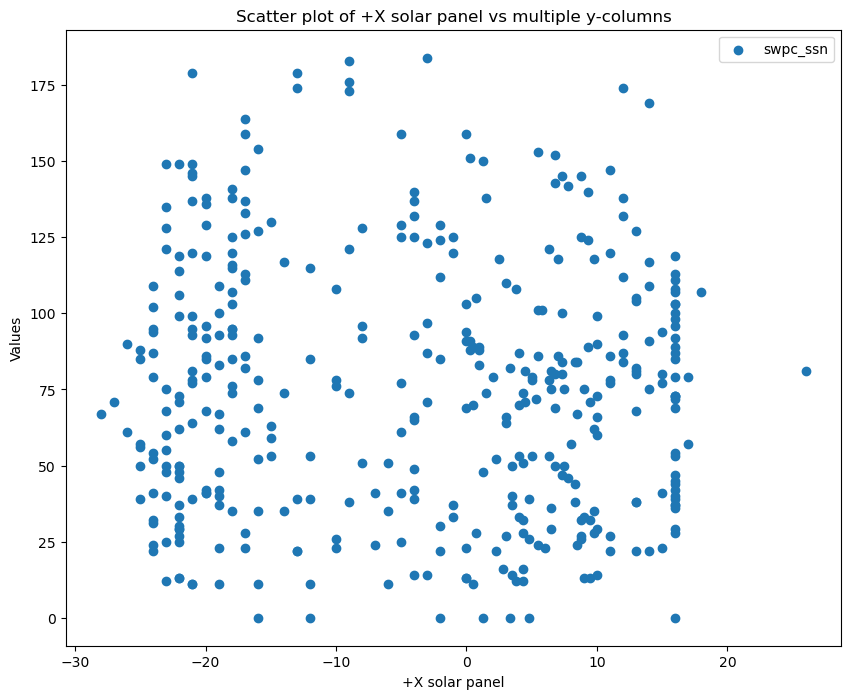

Analyzing ../data/ledsat/System Temperatures (C)-data-2024-02-04 18 14 48.csv
Analyzing ../data/ledsat/Temperatures-data-2024-02-04 18 14 39.csv
Correlation X axis MPPT vs swpc_ssn: (0.19803837403739197, 0.1765768272482411, 0.24113078533366528)


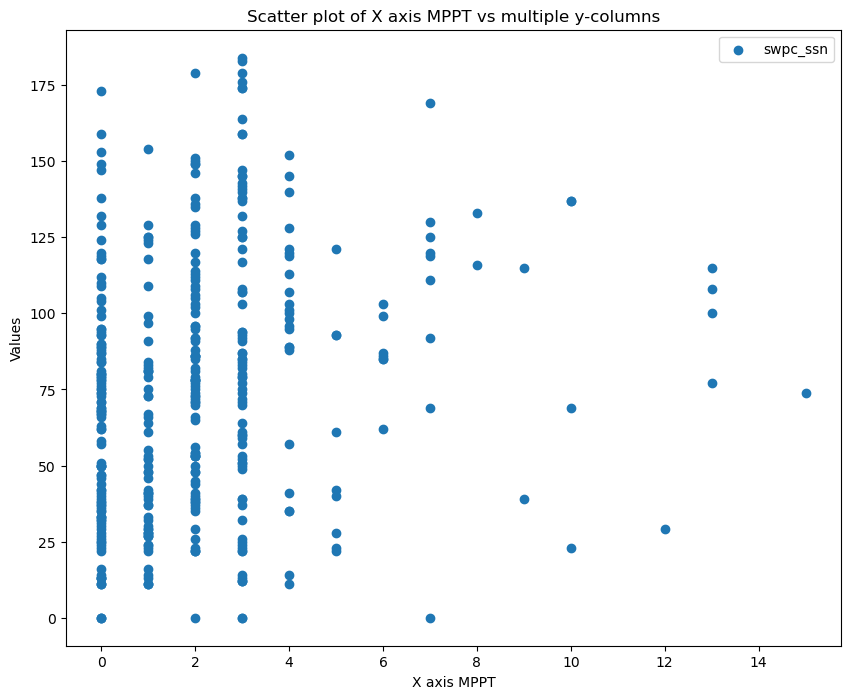

In [228]:
analyze_satellite('ledsat')

Analyzing ../data/ops-sat/Active Transceiver Configuration-data-2024-02-04 18 21 41.csv
Correlation 44878.mode vs swpc_ssn: (0.15328036522496197, 0.14217416584584225, 0.1725486775668712)


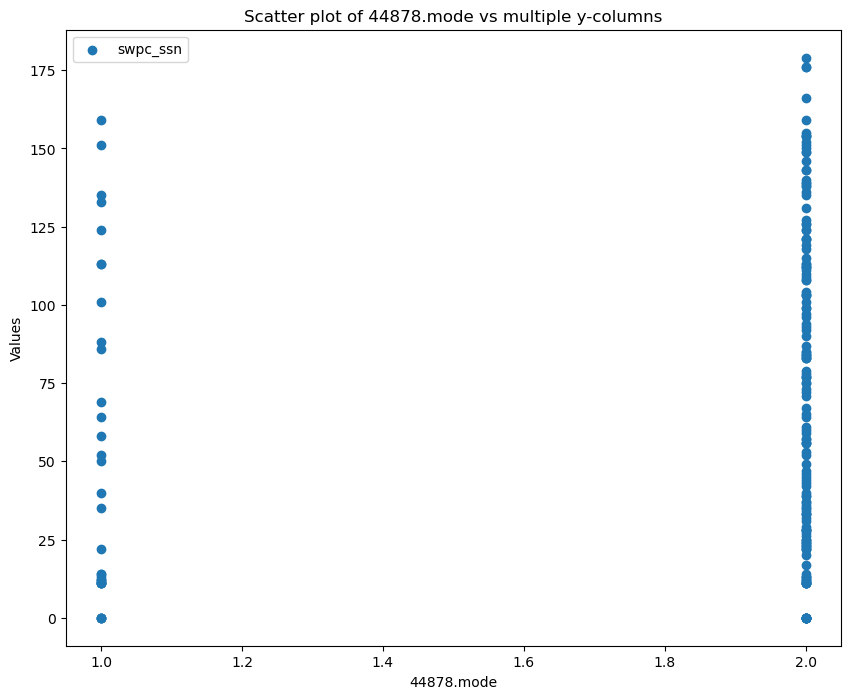

Analyzing ../data/ops-sat/Last Frame Rcvd By-data-2024-02-04 18 21 39.csv
Analyzing ../data/ops-sat/Last frame-data-2024-02-04 18 21 34.csv
Correlation 44878.last vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


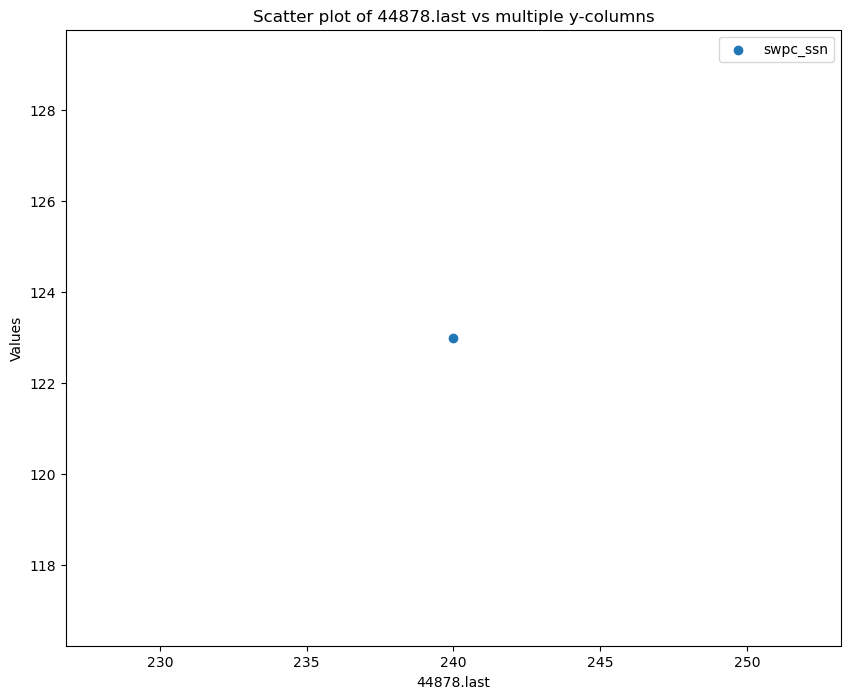

Analyzing ../data/ops-sat/Last RX Frequency Offset-data-2024-02-04 18 21 44.csv
Correlation 44878.mode vs swpc_ssn: (-0.1787243752541007, -0.2429687701330934, -0.3397847873246419)


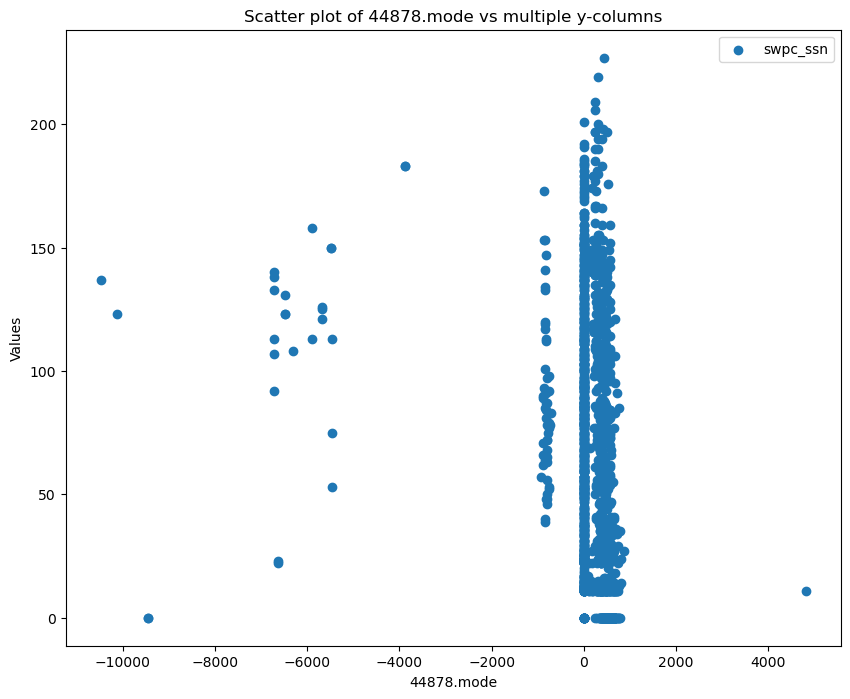

Analyzing ../data/ops-sat/Last valid RX packet timestamp-data-2024-02-04 18 21 46.csv


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [230]:
analyze_satellite('ops-sat')

Analyzing ../data/ramsat/Battery Charge Regulator Input Voltages-data-2024-02-04 18 16 26.csv
Analyzing ../data/ramsat/Battery Charging Status-data-2024-02-04 18 16 35.csv
Correlation 0 = discharge, 1 = charge vs swpc_ssn: (0.010530829247106521, 0.0074219994752550205, 0.009233069930511562)


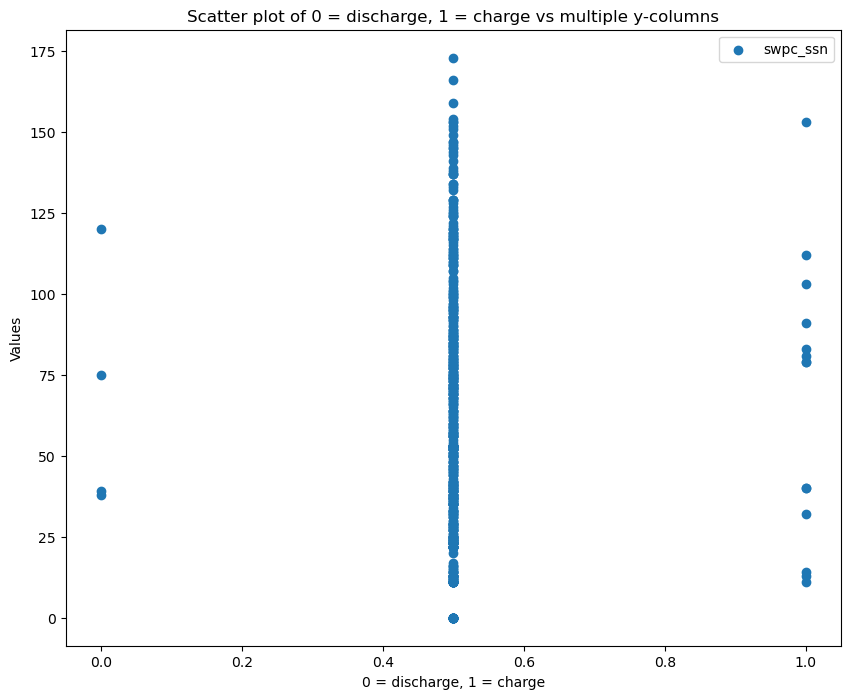

Analyzing ../data/ramsat/Battery Current (magnitude)-data-2024-02-04 18 16 33.csv
Correlation Battery current magnitude vs swpc_ssn: (0.04262855821354702, 0.036610901977828646, 0.05070762513166518)


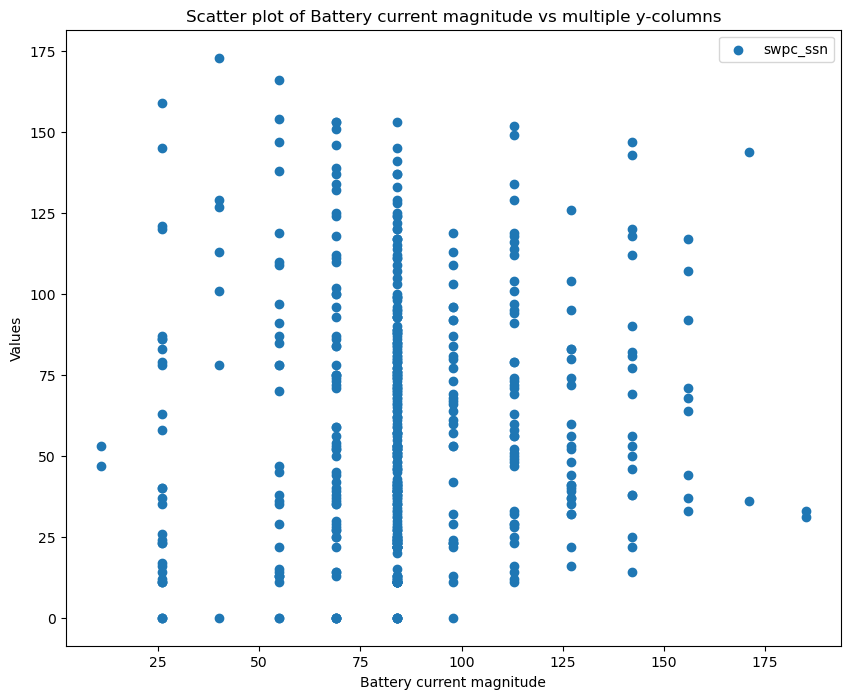

Analyzing ../data/ramsat/Battery Voltage-data-2024-02-04 18 16 12.csv
Analyzing ../data/ramsat/Current Feeding BCRs-data-2024-02-04 18 16 37.csv
Correlation Current feeding BCR1 (+X panel) vs swpc_ssn: (-0.10938338131229036, -0.04423340095536464, -0.05611842157267163)


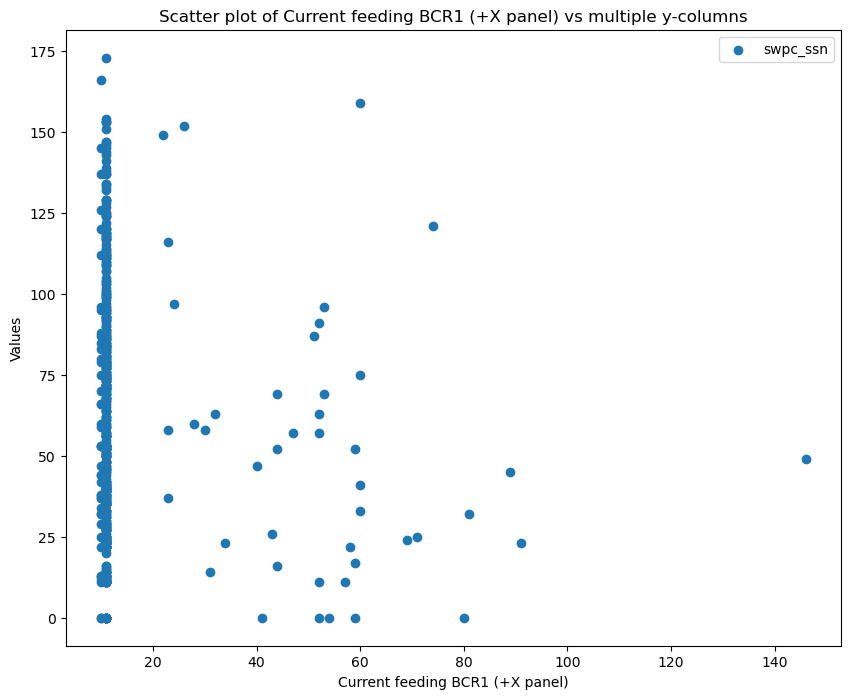

Analyzing ../data/ramsat/Elevation-data-2024-02-04 18 16 44.csv
Correlation Elevation (onboard prediction) vs swpc_ssn: (0.02981696417037133, -0.2297984743196735, -0.32198191160940903)


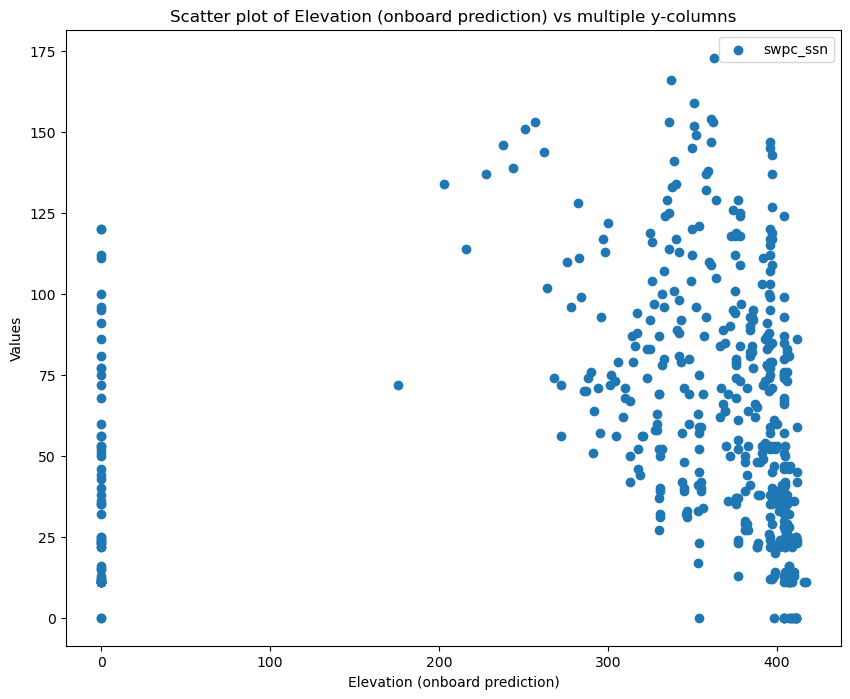

Analyzing ../data/ramsat/Last Frame Rcvd By-data-2024-02-04 18 16 32.csv
Analyzing ../data/ramsat/Longitude and Latitude-data-2024-02-04 18 16 43.csv
Correlation Longitude (prediction) vs swpc_ssn: (-0.032273164347221654, -0.040373591388467626, -0.05961618680142986)


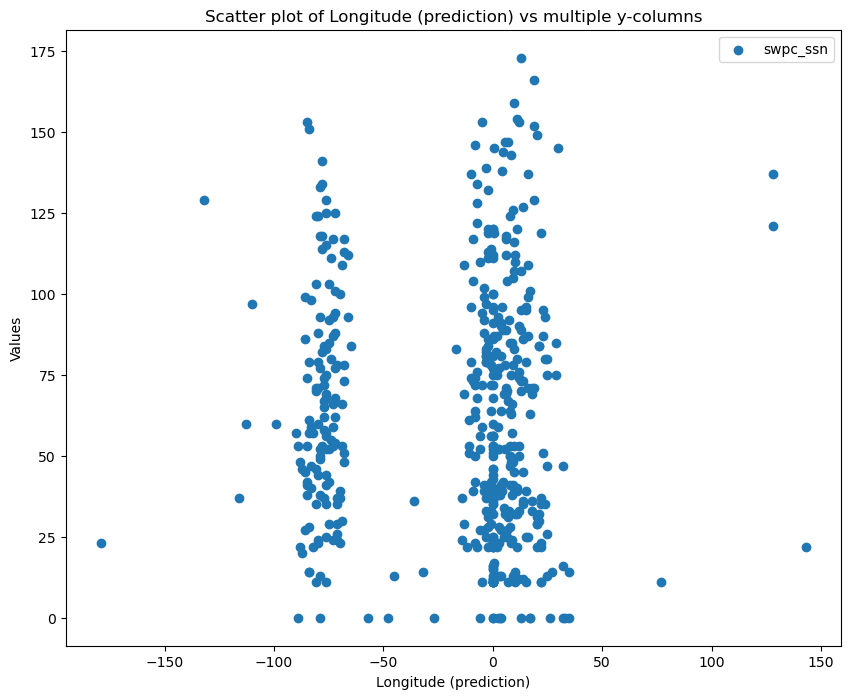

Analyzing ../data/ramsat/Magnetic Field (Body Frame)-data-2024-02-04 18 16 39.csv
Correlation X-axis vs swpc_ssn: (0.021373320836430263, 0.0041191162107821755, 0.0033361218113460334)


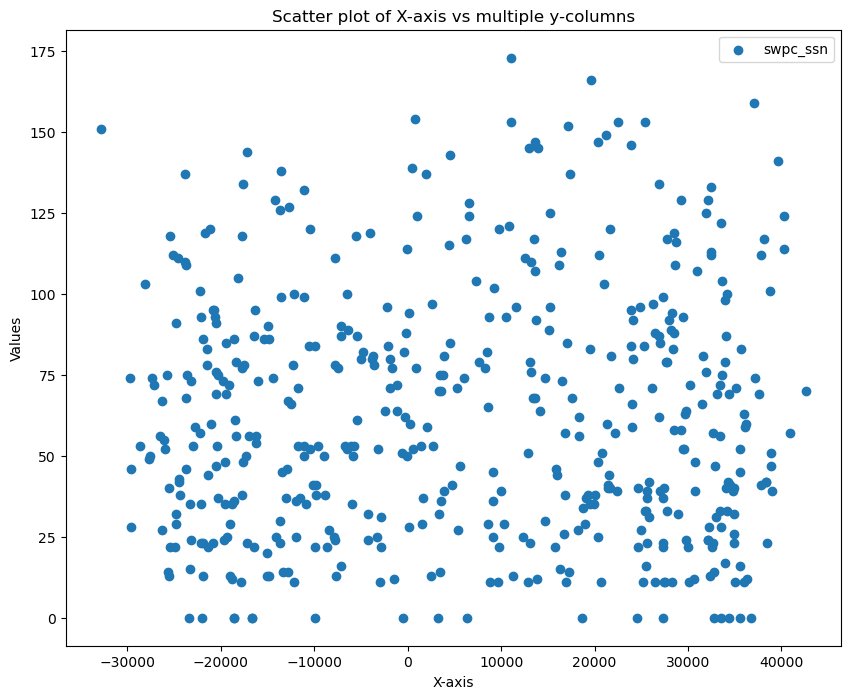

Analyzing ../data/ramsat/Sun Sensors-data-2024-02-04 18 16 30.csv
Correlation Sun Sensor -Xa vs swpc_ssn: (-0.21668439609073345, -0.11952164825240776, -0.15598281354683782)


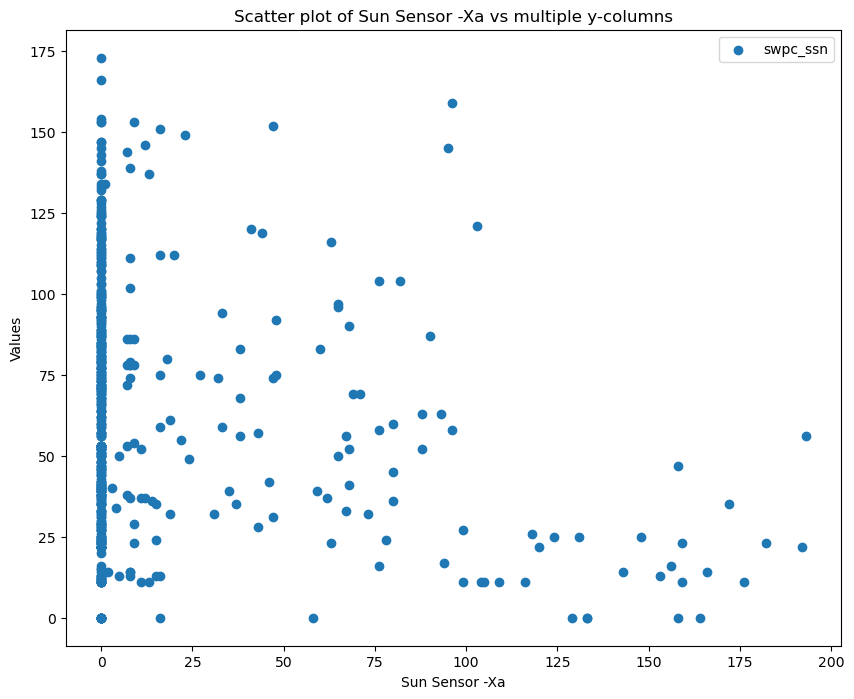

Analyzing ../data/ramsat/System Temperatures (C)-data-2024-02-04 18 16 41.csv
Correlation +X panel vs swpc_ssn: (0.10641015166907092, 0.03154320788217926, 0.052314909106261534)


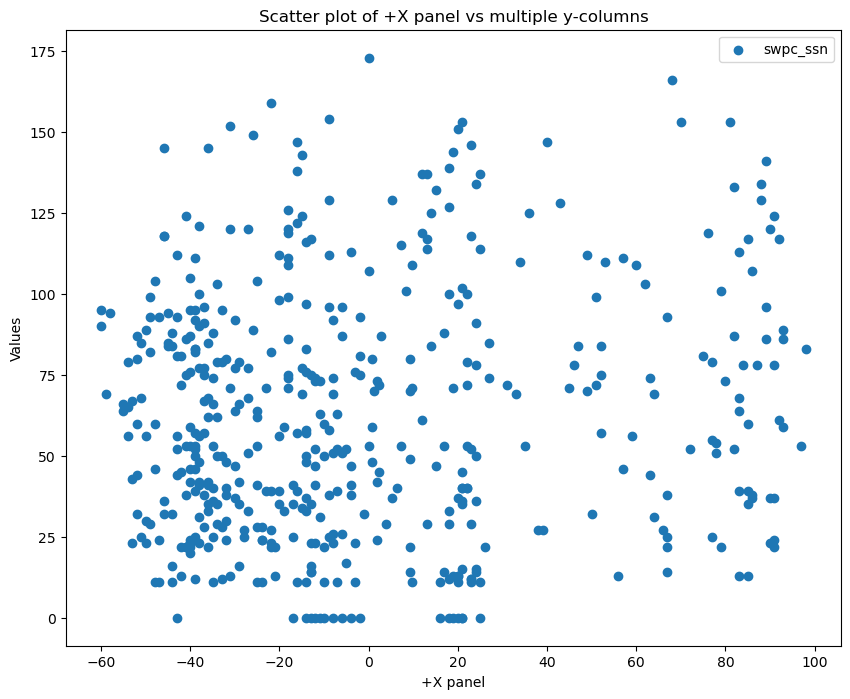

In [231]:
analyze_satellite('ramsat')

Analyzing ../data/veronika/PSU Cur. Out-data-2024-02-04 18 22 29.csv
Analyzing ../data/veronika/PSU GWD Timeout-data-2024-02-04 18 23 28.csv
Analyzing ../data/veronika/PSU Resets in orbit-data-2024-02-04 18 22 14.csv
Correlation 58261.psu_reset_cnt vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


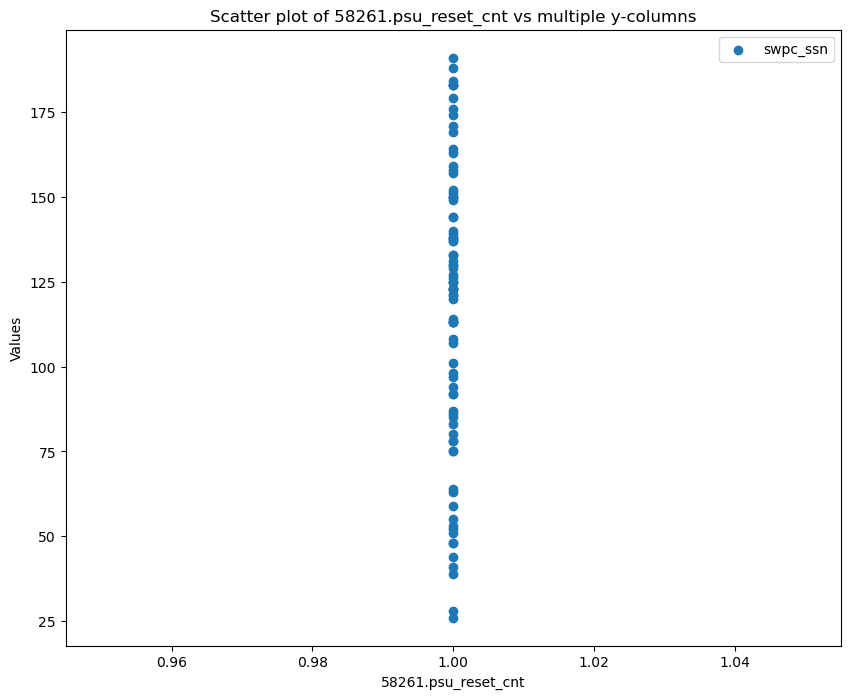

Analyzing ../data/veronika/PSU Temperatures (°C)-data-2024-02-04 18 22 17.csv
Correlation Battery vs swpc_ssn: (0.2556114417626183, 0.1892583246525563, 0.28234340566356175)


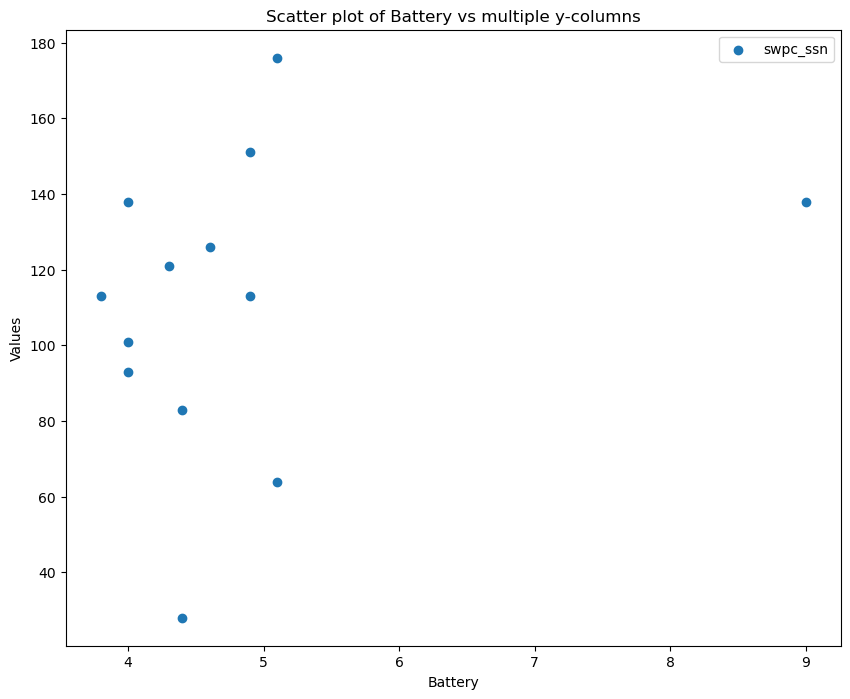

Analyzing ../data/veronika/PSU Uptime (s)-data-2024-02-04 18 22 22.csv
Correlation 58261.mode vs swpc_ssn: (0.09230411585257117, -0.0519524333466131, -0.024793482509275887)


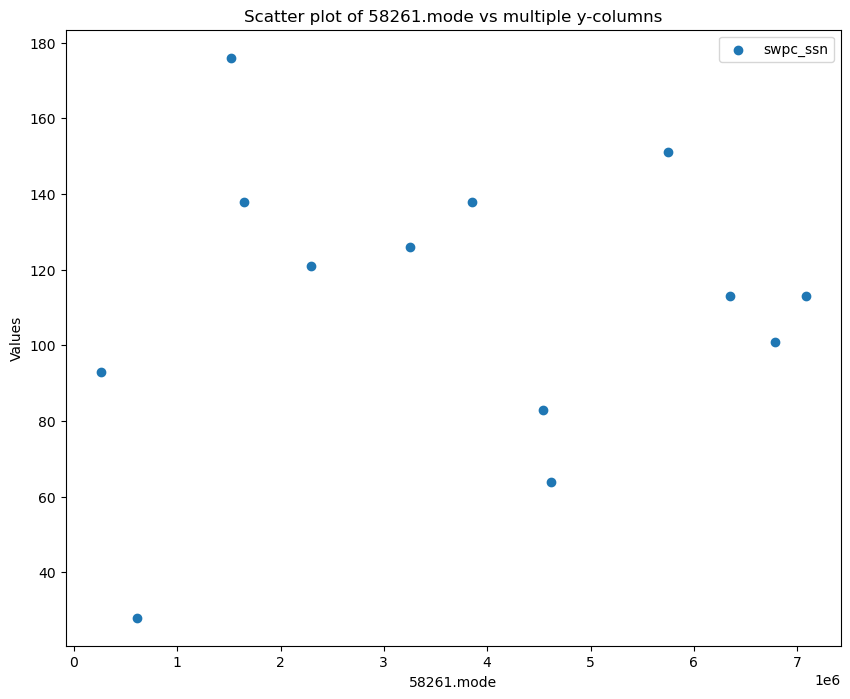

Analyzing ../data/veronika/PSU Uptime Tot. (s)-data-2024-02-04 18 22 24.csv
Correlation 58261.mode vs swpc_ssn: (0.09230411585257117, -0.0519524333466131, -0.024793482509275887)


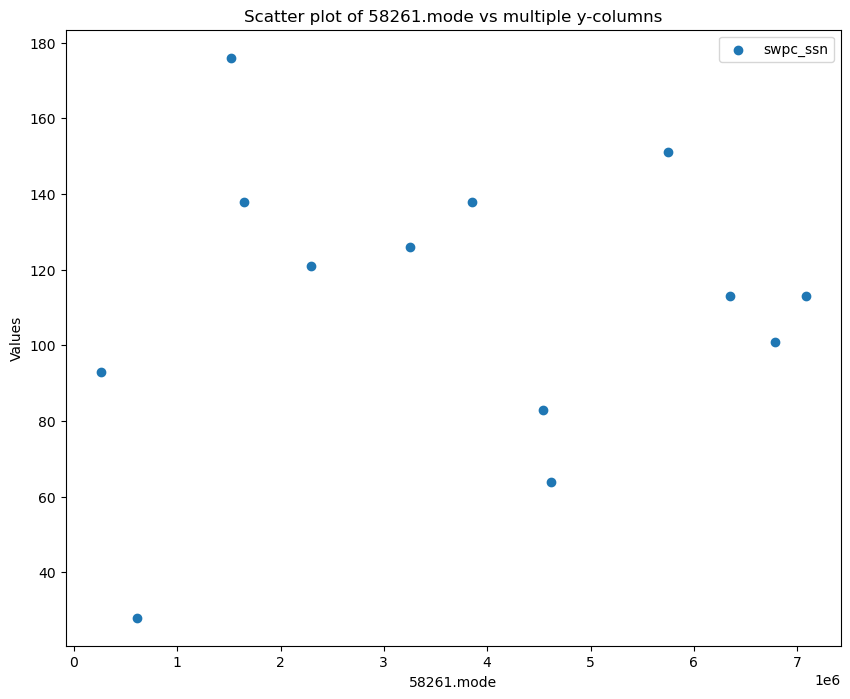

Analyzing ../data/veronika/PSU Uptime Tot.-data-2024-02-04 18 22 51.csv
Analyzing ../data/veronika/PSU Uptime-data-2024-02-04 18 22 49.csv
Analyzing ../data/veronika/Radio RSSI-data-2024-02-04 18 22 46.csv
Correlation UHF Act vs swpc_ssn: (0.19780596259651267, 0.12471320349156775, 0.18079810884879874)


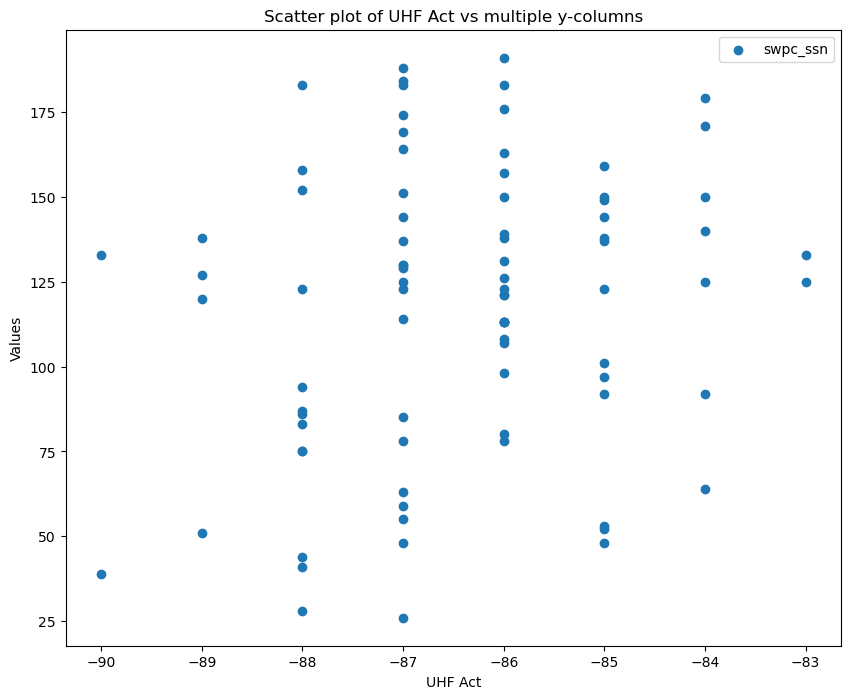

Analyzing ../data/veronika/System state-data-2024-02-04 18 22 12.csv
Analyzing ../data/veronika/Transmitted message-data-2024-02-04 18 23 22.csv
Analyzing ../data/veronika/UHF Digipeater usage-data-2024-02-04 18 22 58.csv
Correlation 58261.mode vs swpc_ssn: (0.21471666569320857, -0.026669037353133248, 0.015235515517624728)


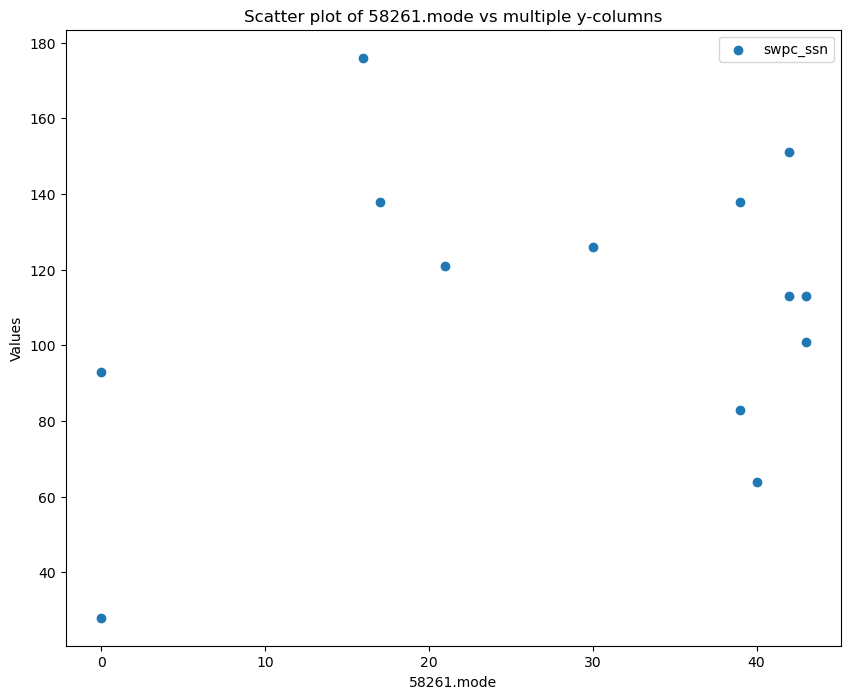

Analyzing ../data/veronika/UHF last digipeater user-data-2024-02-04 18 23 24.csv
Analyzing ../data/veronika/UHF Last temperatures-data-2024-02-04 18 23 09.csv
Analyzing ../data/veronika/UHF Received packets-data-2024-02-04 18 23 16.csv
Correlation 58261.mode vs swpc_ssn: (0.3324105676753036, -0.039735970711951306, 0.006915635937205746)


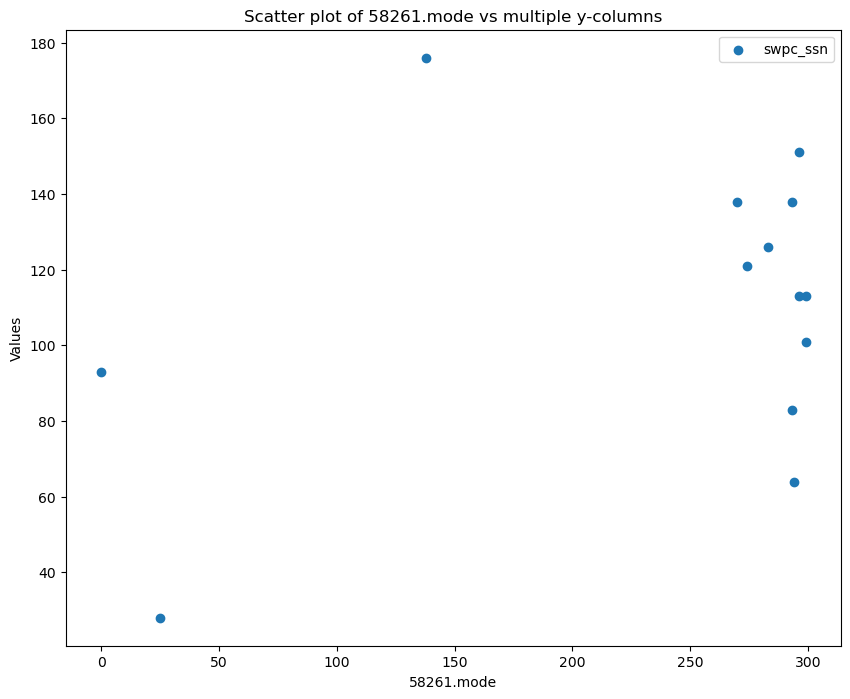

Analyzing ../data/veronika/UHF Resets-data-2024-02-04 18 23 14.csv
Correlation 58261.mode vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


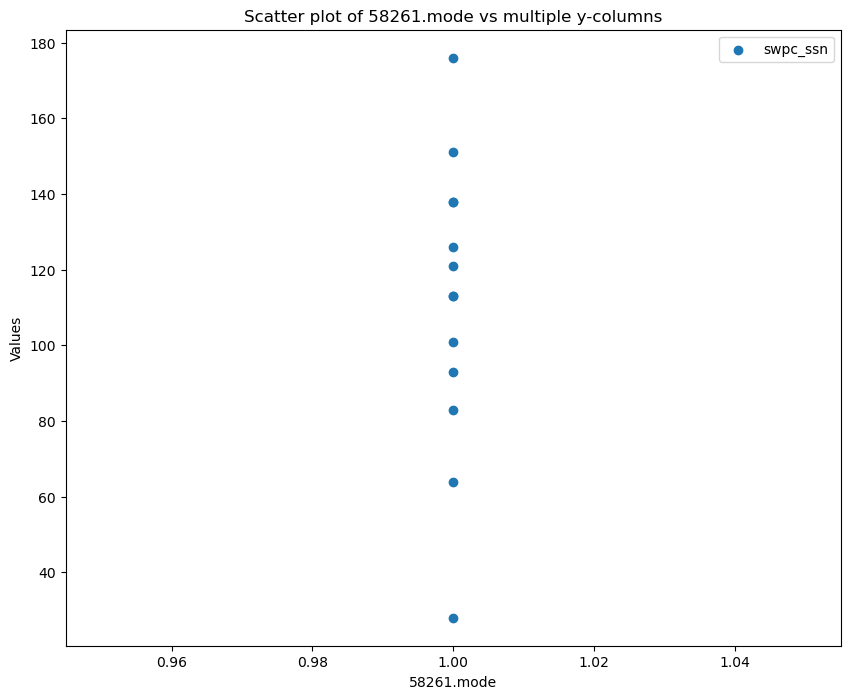

Analyzing ../data/veronika/UHF RF Resets-data-2024-02-04 18 23 26.csv
Correlation 58261.mode vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


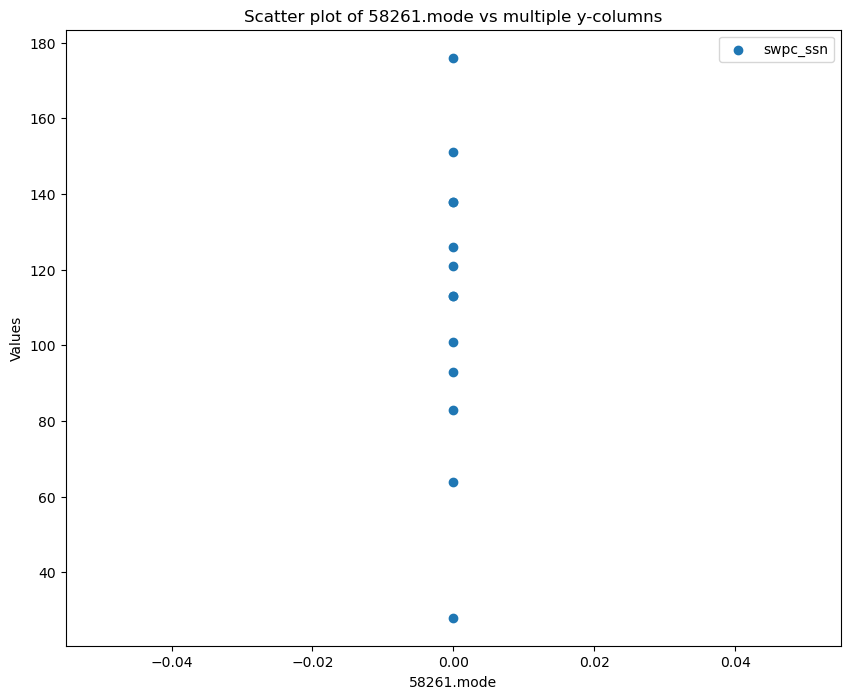

Analyzing ../data/veronika/UHF Temperatures-data-2024-02-04 18 23 12.csv
Analyzing ../data/veronika/UHF Transmitted packets-data-2024-02-04 18 23 19.csv
Correlation 58261.mode vs swpc_ssn: (0.04947440917428154, -0.0519524333466131, -0.024793482509275887)


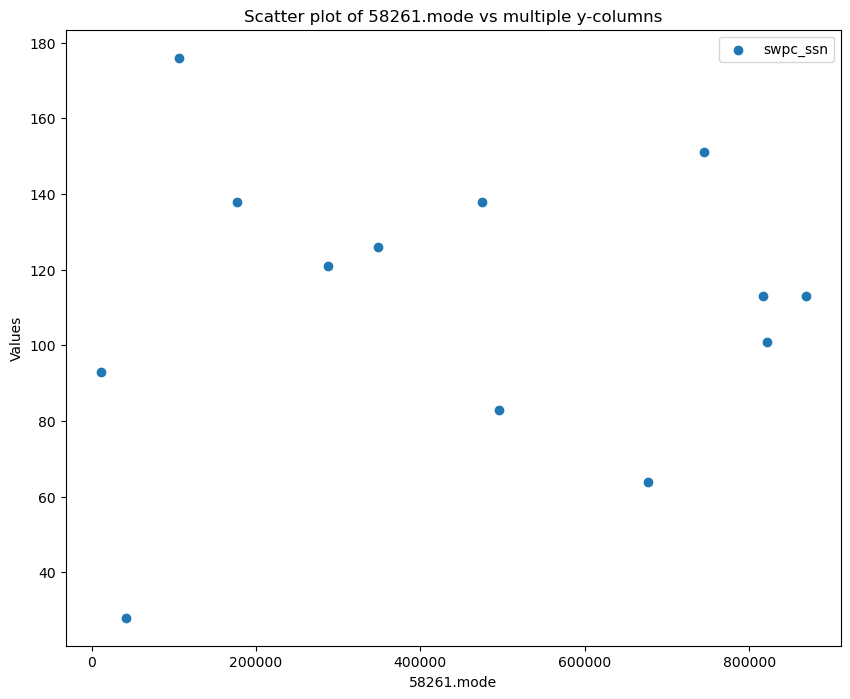

Analyzing ../data/veronika/UHF Uptime (s)-data-2024-02-04 18 23 00.csv
Correlation 58261.mode vs swpc_ssn: (0.06104289922773398, -0.0519524333466131, -0.024793482509275887)


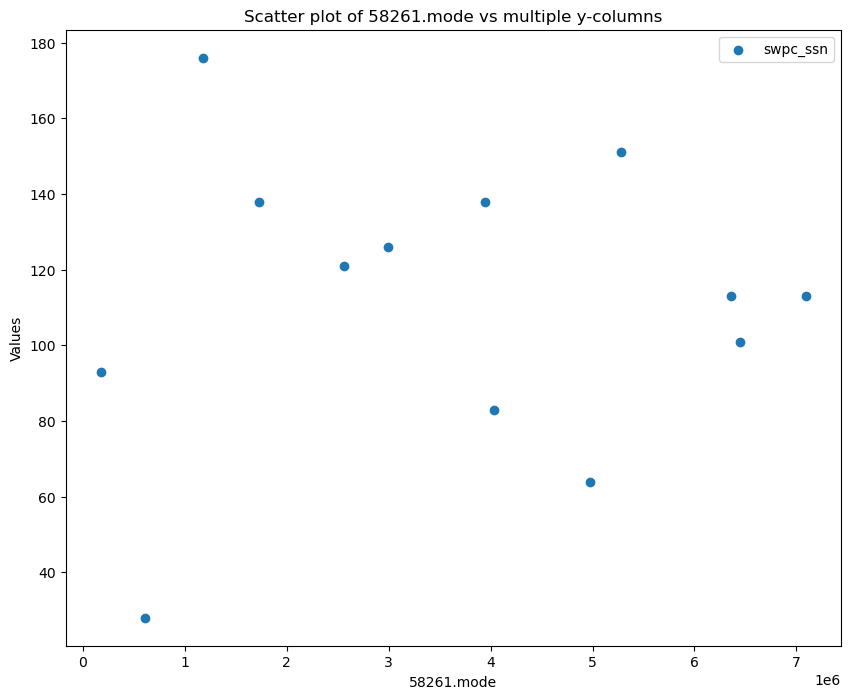

Analyzing ../data/veronika/UHF Uptime Tot. (s)-data-2024-02-04 18 23 02.csv
Correlation 58261.mode vs swpc_ssn: (0.06104289922773398, -0.0519524333466131, -0.024793482509275887)


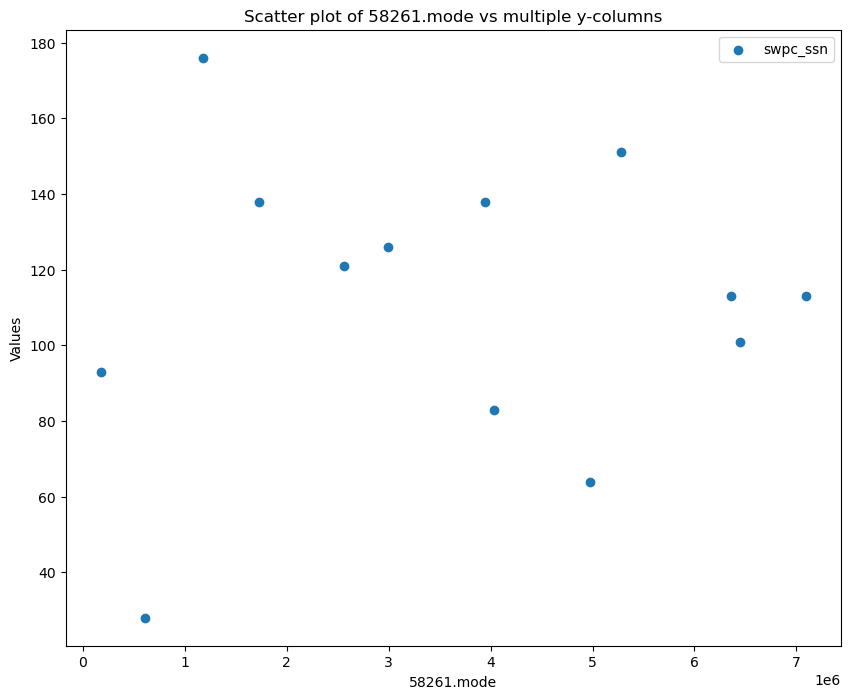

Analyzing ../data/veronika/UHF Uptime Tot.-data-2024-02-04 18 23 06.csv
Analyzing ../data/veronika/UHF Uptime-data-2024-02-04 18 23 04.csv
Analyzing ../data/veronika/Battery Current (mA)-data-2024-02-04 18 22 20.csv
Correlation In vs swpc_ssn: (0.15434589669793236, 0.09558988911273407, 0.11166604821026613)


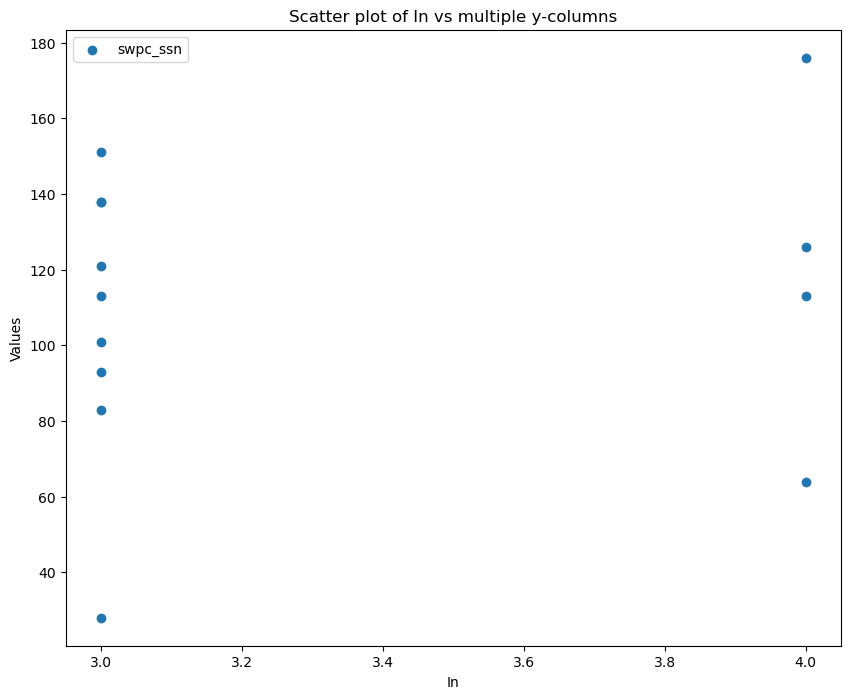

Analyzing ../data/veronika/Battery-data-2024-02-04 18 22 42.csv
Correlation PSU Battery vs swpc_ssn: (0.08267204859082576, 0.05729111949685366, 0.07306307810220292)


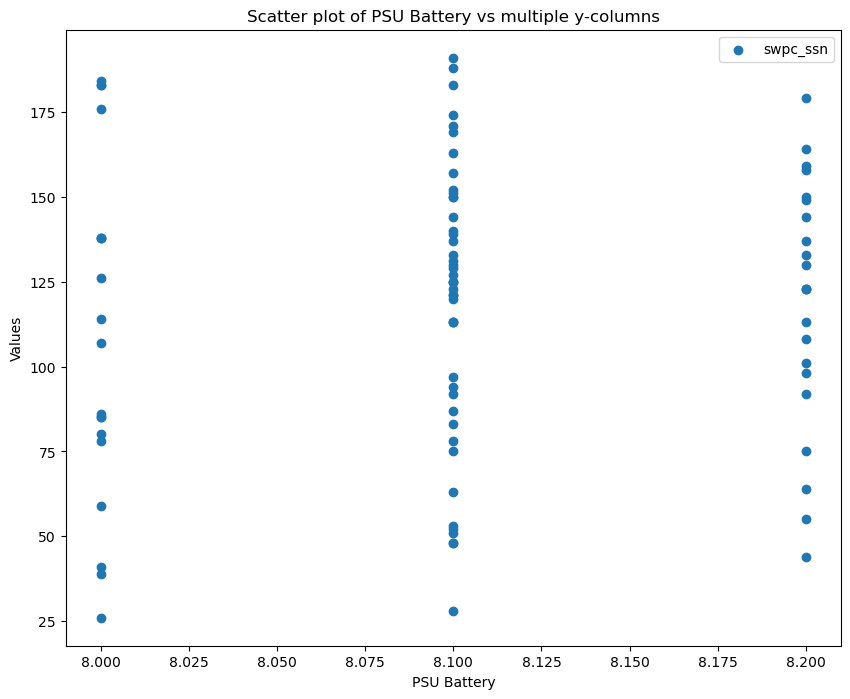

Analyzing ../data/veronika/Internal Magnetometer-data-2024-02-04 18 23 31.csv
Correlation X vs swpc_ssn: (0.10656617888267522, 0.055165208946249426, 0.07785607654783727)


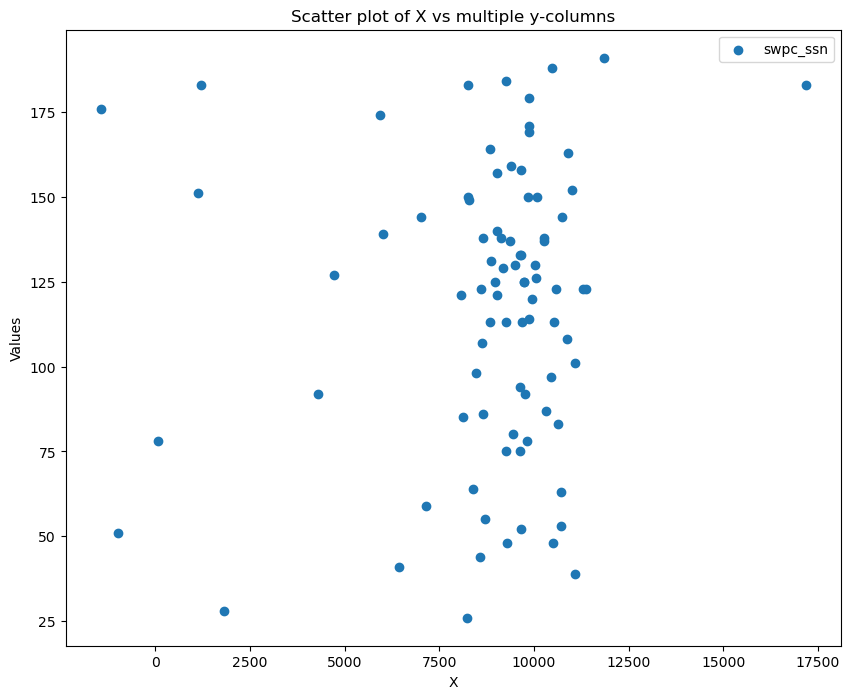

Analyzing ../data/veronika/Internal Temperatures (°C)-data-2024-02-04 18 22 44.csv
Correlation OBC MCU vs swpc_ssn: (-0.07738839142308253, -0.009419414567963686, -0.02689116944947489)


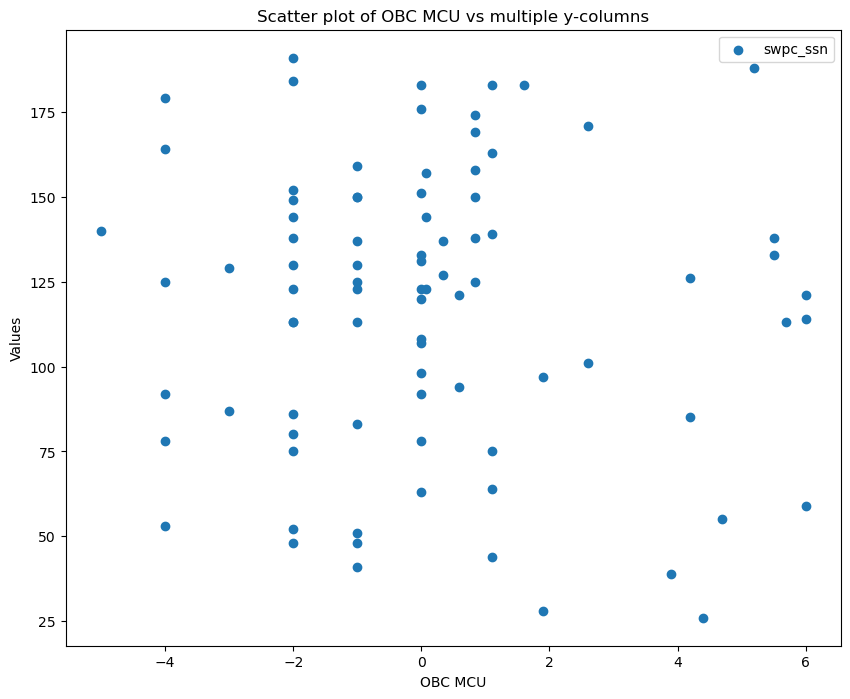

Analyzing ../data/veronika/Last Frame Received-data-2024-02-04 18 23 20.csv
Correlation 58261.pid vs swpc_ssn: (nan, nan, nan)


/tmp/ipykernel_4449/2181950077.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


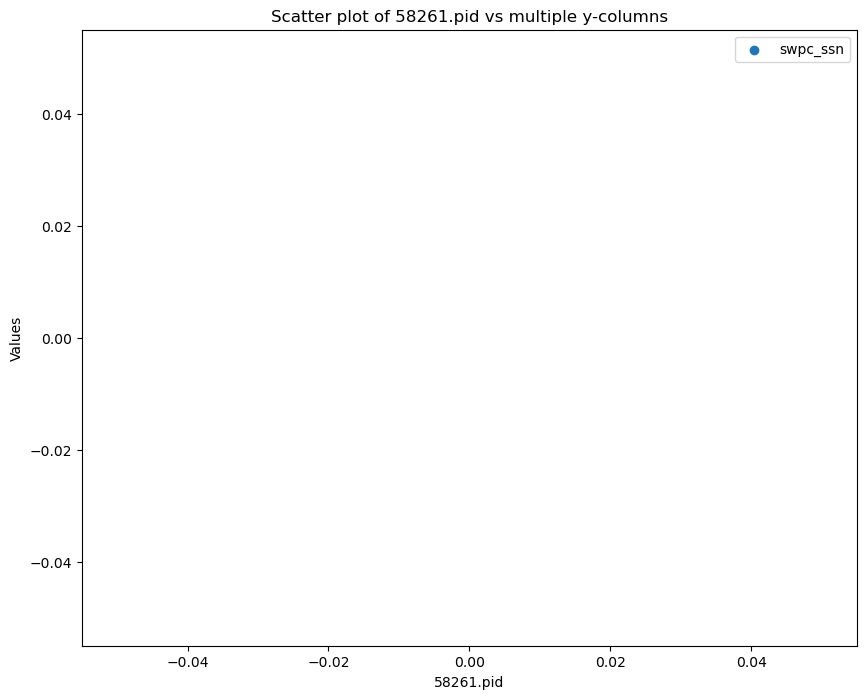

Analyzing ../data/veronika/OBC Free Storage-data-2024-02-04 18 22 39.csv
Analyzing ../data/veronika/OBC Resets in orbit-data-2024-02-04 18 22 31.csv
Correlation 58261.mode vs swpc_ssn: (-0.02240157210217952, 0.013425540338526366, 0.029167116779966643)


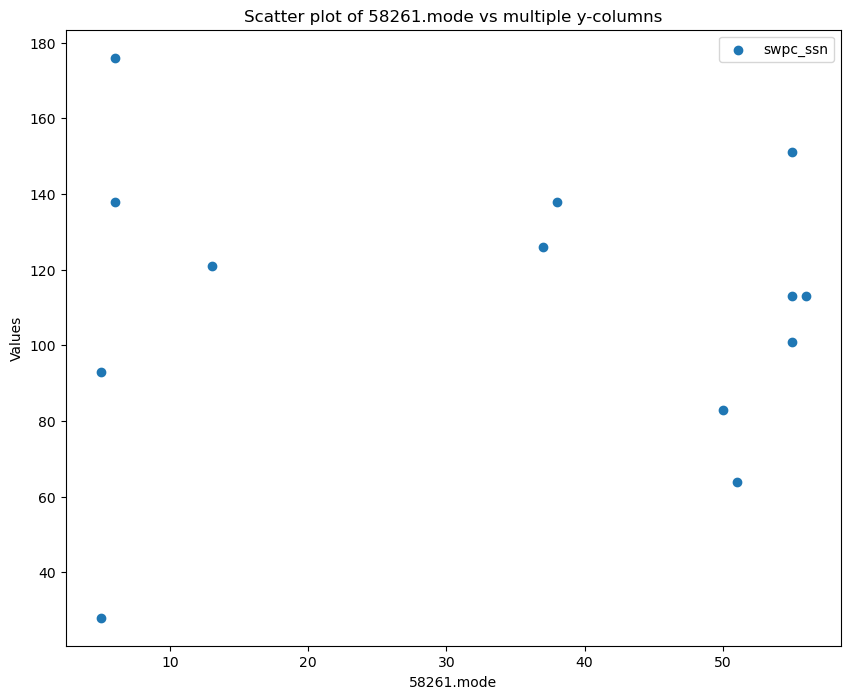

Analyzing ../data/veronika/OBC Uptime (s)-data-2024-02-04 18 22 34.csv
Correlation 58261.mode vs swpc_ssn: (-0.0785525113362002, 0.02597621667330655, 0.05234179640847132)


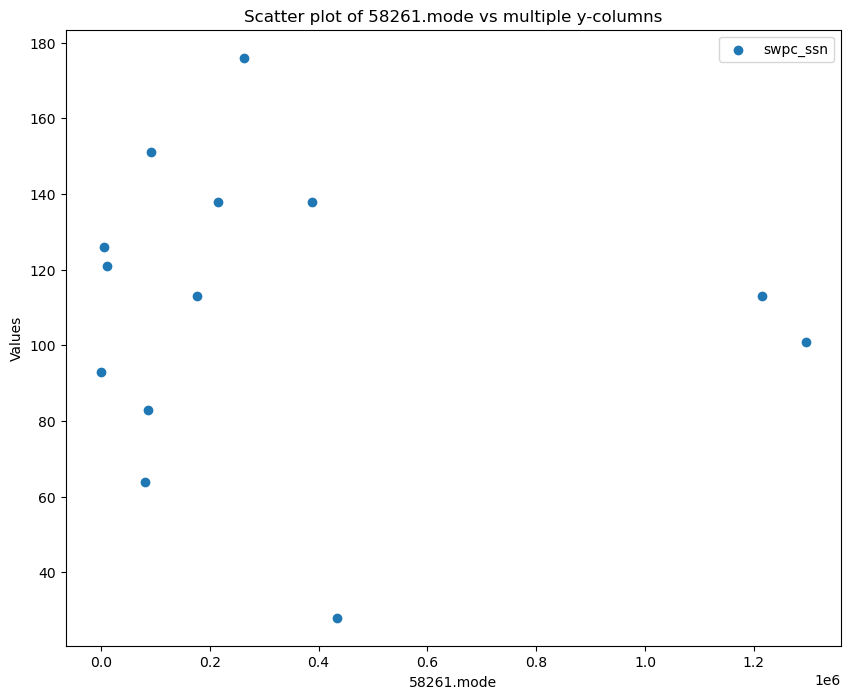

Analyzing ../data/veronika/OBC Uptime Tot. (s)-data-2024-02-04 18 22 37.csv
Correlation 58261.mode vs swpc_ssn: (0.057084269825552196, -0.0519524333466131, -0.024793482509275887)


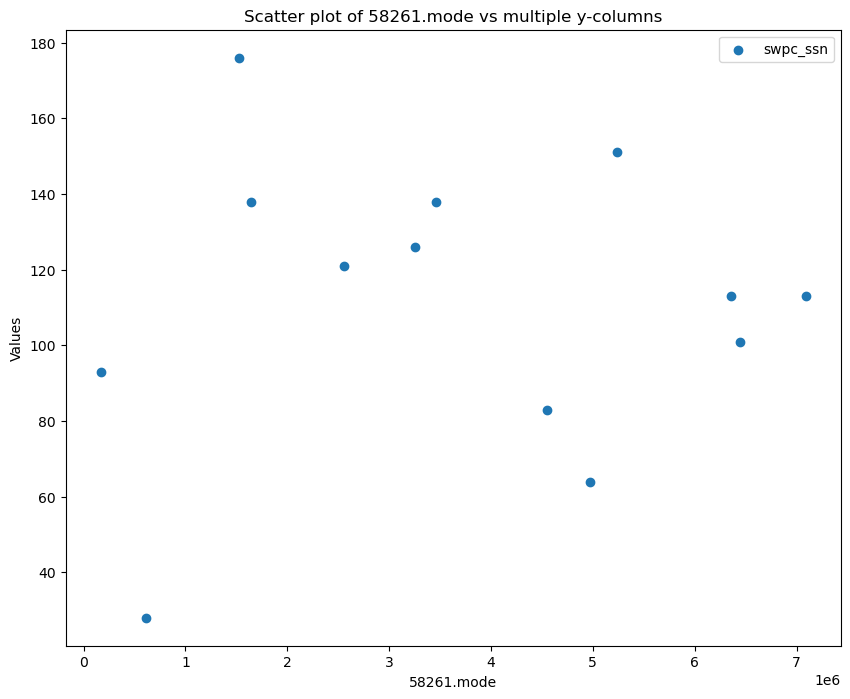

Analyzing ../data/veronika/OBC Uptime Tot.-data-2024-02-04 18 22 56.csv
Analyzing ../data/veronika/OBC Uptime-data-2024-02-04 18 22 54.csv
Analyzing ../data/veronika/PSU Cur. In-data-2024-02-04 18 22 26.csv


In [232]:
analyze_satellite('veronika')

Analyzing ../data/vzlusat-2/Battery Temperature-data-2024-02-04 18 16 02.csv
Analyzing ../data/vzlusat-2/Battery Voltage-data-2024-02-04 18 15 46.csv
Analyzing ../data/vzlusat-2/Data Frames-data-2024-02-04 18 15 56.csv
Correlation Chunk vs swpc_ssn: (-0.34520058199900483, -0.44199569608786393, -0.6094613148925725)


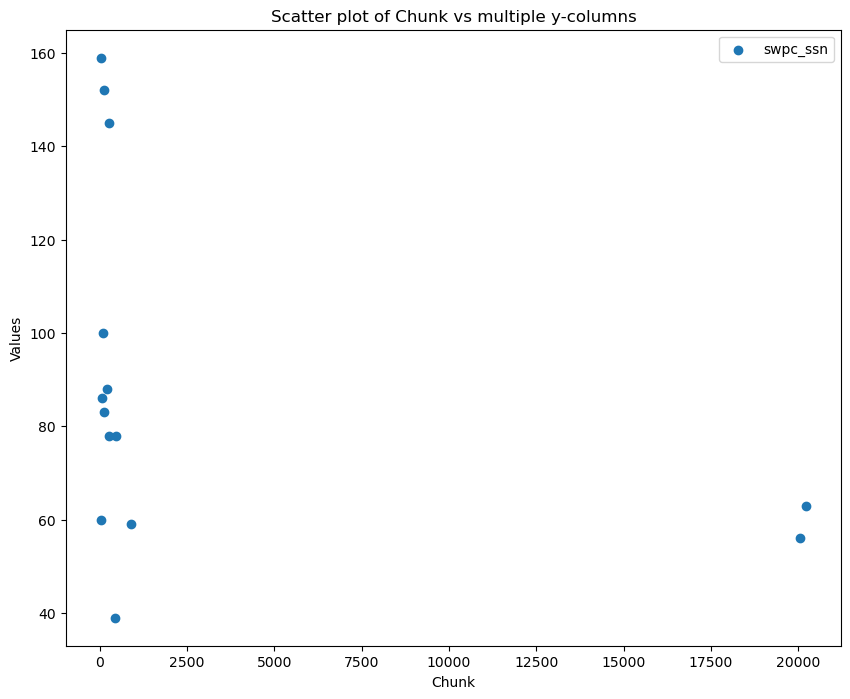

Analyzing ../data/vzlusat-2/Ground Stations Leaderboard By Observed Data Frames-data-2024-02-04 18 15 52.csv
Correlation ArgusNavis vs swpc_ssn: (0.6769388307506162, 0.5426949001388413, 0.6572751707931487)


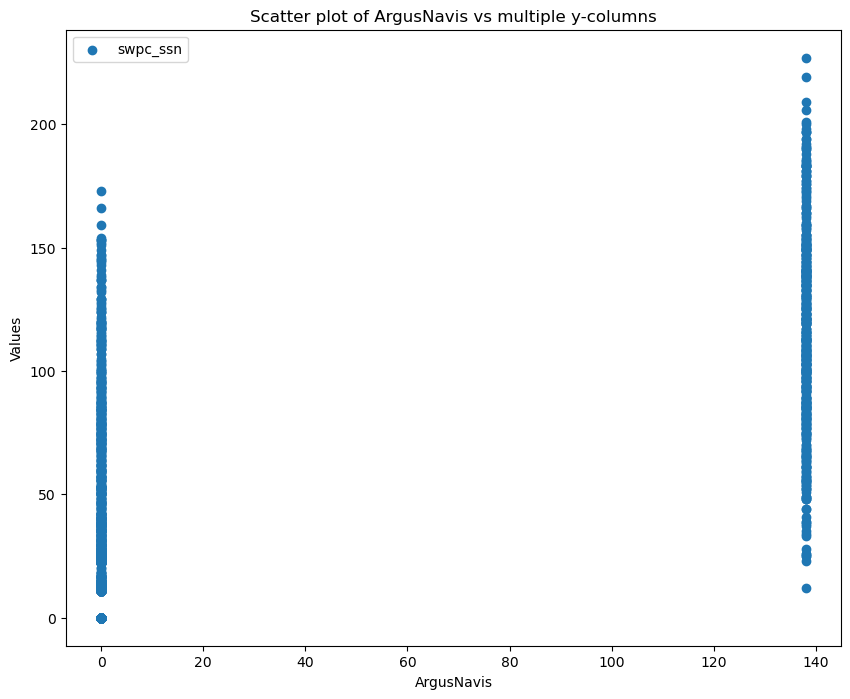

Analyzing ../data/vzlusat-2/Last Beacon Received By-data-2024-02-04 18 16 03.csv
Correlation last vs swpc_ssn: (nan, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


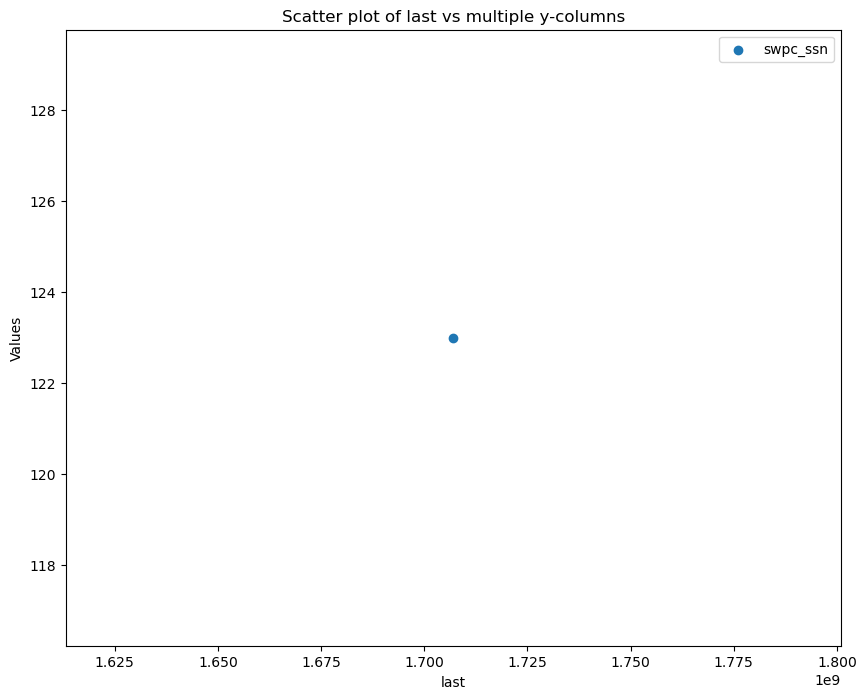

Analyzing ../data/vzlusat-2/Number of in-orbit OBC resets-data-2024-02-04 18 16 07.csv
Correlation 51085.last vs swpc_ssn: (0.4208822649348228, 0.2810224745735555, 0.40885491516883415)


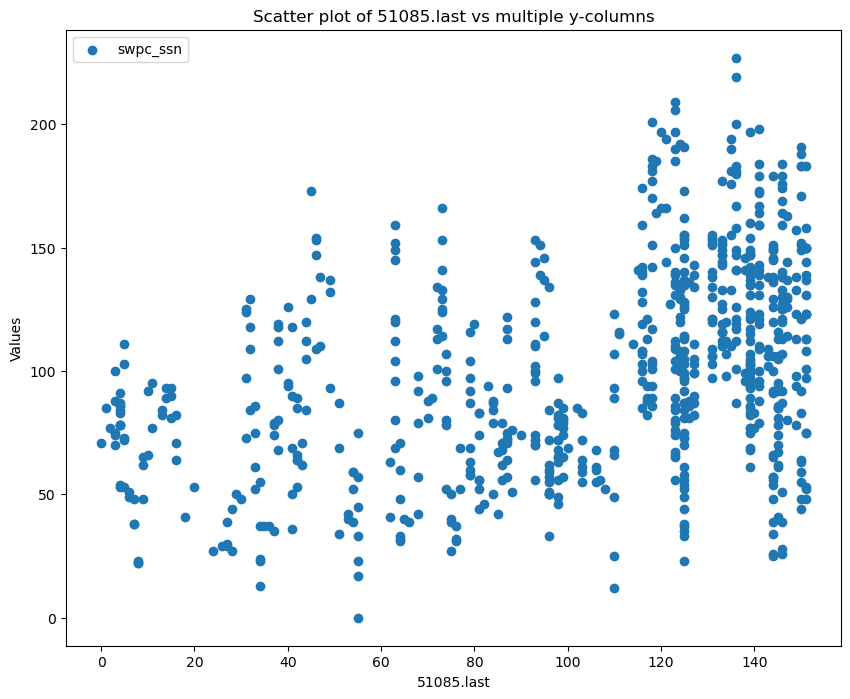

Analyzing ../data/vzlusat-2/Number of received beacon frames-data-2024-02-04 18 15 59.csv
Correlation 51085.cumulative_sum vs swpc_ssn: (0.7194781500359015, 0.6050055321470738, 0.787216346481029)


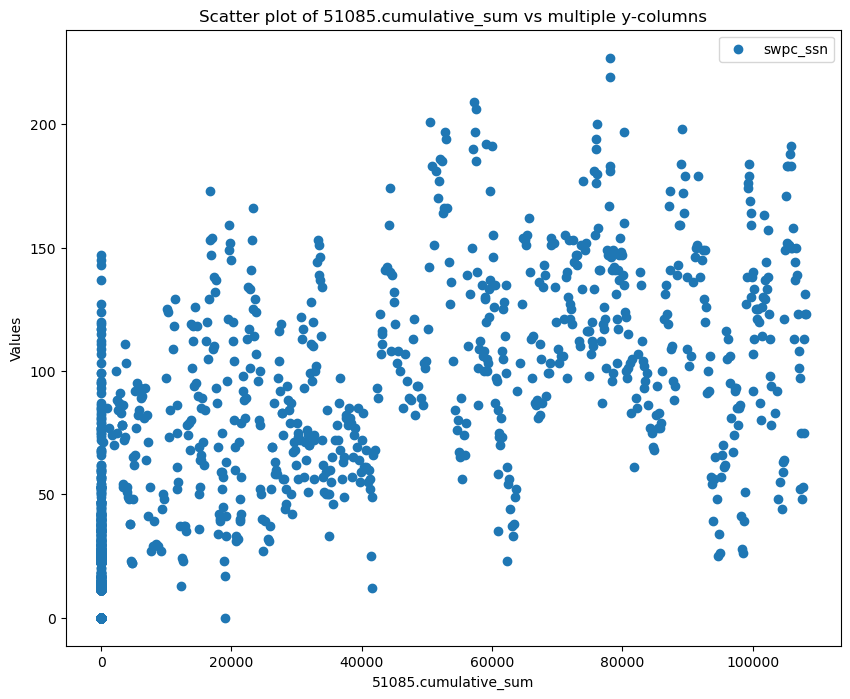

Analyzing ../data/vzlusat-2/Radio PA Temperature-data-2024-02-04 18 15 50.csv
Analyzing ../data/vzlusat-2/Solar Current-data-2024-02-04 18 15 47.csv
Analyzing ../data/vzlusat-2/System Current-data-2024-02-04 18 15 49.csv


In [235]:
analyze_satellite('vzlusat-2')